In [1]:
# Masters Thesis willem

import pypsa
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib import cm
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
import glob
from dtw import *
import itertools

plt.style.use ("bmh")
from pprint import *
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
#logger.setLevel(logging.CRITICAL)


    
#from sklearn_extra.cluster import KMedoids

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Masters Thesis willem

import pypsa
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
import glob
from dtw import *
import itertools

plt.style.use ("bmh")
from pprint import *
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
#logger.setLevel(logging.CRITICAL)


    
#from sklearn_extra.cluster import KMedoids

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

# Manual objective analysis -> redispatch cost reduction
# ---------------------

# Plot MANUAL objective insights
# --------------

def plot_objective(df_obj, df_obj_day, df_obj_week):
    """
    Function to plot objective analysis insights
    """

    colors = ["royalblue","navy","lightgreen"]

    # Redispatch cost difference per day
    cols = ["redispatch_cost","redispatch_cost_bat"]
    fig, ax  = plt.subplots(figsize = (20, 5))
    ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_obj_day[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                       color = colors, legend = True, linewidth = 2, fontsize = 12)
    df_obj_day["delta_rd_cost"].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                       color = "lightgreen", legend = True, linewidth = 2.5, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Redispatch cost difference per week
    cols = ["redispatch_cost","redispatch_cost_bat"]
    fig, ax1  = plt.subplots(figsize = (20, 5))
    ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
    ax1.set_xlabel("Time horizon (week)", fontsize = 12)
    ax1 = df_obj_week[cols].plot.line(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                       color = colors, legend = True, linewidth = 2.5, fontsize = 12)
    df_obj_week["delta_rd_cost"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                       color = "lightgreen", legend = True, width = 0.4, fontsize = 12)
    ax1.set_facecolor('white')
    ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
    ax1.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Relative redispatch cost savings vs absolute savings
    fig, ax2  = plt.subplots(figsize = (20, 5))
    ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
    ax2.set_xlabel("Time horizon (day)", fontsize = 12)
    ax2 = df_obj_day["delta_rd_cost"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
                                       color = ["lightgreen"], legend = True, fontsize = 12)
    ax2.set_facecolor('white')
    ax2.legend(loc = "upper left")
    ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
    ax2.set_axisbelow(True)

    # TODO: REMOVE GRAPH OFFSET
    
    ax2_ = ax2.twinx()
    abs(df_obj_day["delta_rd_cost_rel"]).abs().plot.line(ax = ax2_, linewidth = 1.2, 
                                               color = "crimson", legend = True, fontsize = 12)
    ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
    #ax2_.set_ylim(0,1.0)
    fig.tight_layout()
    plt.show()
    
def plot_objective_rd(df_obj, df_obj_day, df_obj_week):
    """
    Function to plot objective analysis insights
    """

    colors = ["royalblue","navy","lightgreen"]

    # Redispatch cost per 
    fig, ax  = plt.subplots(figsize = (20, 5))
    ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_obj_day["redispatch_cost"].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                       color = colors, legend = True, linewidth = 2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Redispatch cost  per week
    fig, ax1  = plt.subplots(figsize = (20, 5))
    ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
    ax1.set_xlabel("Time horizon (week)", fontsize = 12)
    ax1 = df_obj_week["redispatch_cost"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                       color = colors, legend = True, linewidth = 1.5, fontsize = 12)
    ax1.set_facecolor('white')
    ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
    ax1.set_axisbelow(True)
    fig.tight_layout()
    plt.show()



def analyze_objective(network_rd, network_rd_bat):
    # Calculate the hourly realized redispatch cost for every generator 
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
    cols_rd_b = [column for column in list(network_rd_bat.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p = network_rd.generators_t.p[cols_rd]
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd_b]
    
    # positive redispatch cost
    d_marg_cost = pd.Series(network_rd.generators.marginal_cost.values,index=network_rd.generators.index).to_dict()
    df_ramp = df_rd_p[[column for column in list(df_rd_p) if "pos" in column]]
    df_ramp_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "pos" in column]]
    for col in list(df_ramp):
        df_ramp.loc[:,col] = df_ramp[col] * d_marg_cost[col]
        df_ramp_bat.loc[:,col] = df_ramp_bat [col] * d_marg_cost[col]
    df_ramp_cost = df_ramp.copy()
    df_ramp_cost_bat = df_ramp_bat.copy()
    df_ramp_cost["sum_ramp_cost"] = df_ramp_cost.sum(axis = 1)
    df_ramp_cost_bat["sum_ramp_cost_bat"] = df_ramp_cost_bat.sum(axis = 1)

    # negative redispatch cost
    df_marginal_cost = network_rd.generators_t.marginal_cost.round(2)
    for col in list(df_marginal_cost):
        if "wind" in col or "solar" in col:
            df_marginal_cost[col] = 0
    
    df_marginal_cost_bat = network_rd_bat.generators_t.marginal_cost.round(2)
    for col in list(df_marginal_cost_bat):
        if "wind" in col or "solar" in col:
            df_marginal_cost_bat[col] = 0
    
    df_curtail = df_rd_p[[column for column in list(df_rd_p) if "neg" in column]]
    df_curtail_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "neg" in column]]
    #
    df_curtail_cost = df_curtail * df_marginal_cost
    df_curtail_cost_bat = df_curtail_bat * df_marginal_cost_bat
    # add sums
    df_curtail_cost["sum_curtailment_cost"] = df_curtail_cost.sum(axis = 1)
    df_curtail_cost_bat["sum_curtailment_cost_bat"] = df_curtail_cost_bat.sum(axis = 1)
    
    # ---------------
    # For bat only: Compute redispatch costs for batteries: 
    
    '''BUT: Makes no sense to include batteries in "conventional" redispatch cost reduction!!!
       maybe add them as another spot.
    '''
    
    # only includes links for bess charger/discharger -> sum of charger and discharger redispatch cost 
    # (forced energy payment for neg redispatch + lcos&energy compensation for pos redispatch
#     bat_link_cost = pd.Series(network_rd_bat.links.filter(like='BESS', axis=0).marginal_cost.values,
#                               index=network_rd_bat.links.filter(like='BESS', axis=0).index).to_dict()
#     cols_bat = [column for column in list(network_rd_bat.links_t.p0) if "BESS" in column]
#     df_bat_links_t = network_rd_bat.links_t.p0[cols_bat].copy()
#     for col in df_bat_links_t:
#         if col in bat_link_cost.keys():
#             df_bat_links_t[col] = df_bat_links_t[col]*bat_link_cost[col]
#     df_bat_links_t["sum_BESS_cost"] = df_bat_links_t.sum(axis = 1)
#     sum_bat = df_bat_links_t["sum_BESS_cost"].sum()
    
    # df for comparison bat vs. no bat
    df_obj = pd.concat([df_curtail_cost["sum_curtailment_cost"].round(2), df_curtail_cost_bat["sum_curtailment_cost_bat"].round(2),
                                  df_ramp_cost["sum_ramp_cost"].round(2), df_ramp_cost_bat["sum_ramp_cost_bat"].round(2), 
                                  df_bat_links_t["sum_BESS_cost"].round(2)], axis = 1)
    df_obj["redispatch_cost"] = df_obj["sum_curtailment_cost"] + df_obj["sum_ramp_cost"]
    df_obj["redispatch_cost_bat"] = df_obj["sum_curtailment_cost_bat"] + df_obj["sum_ramp_cost_bat"] + df_obj["sum_BESS_cost"]
    df_obj["delta_ramp_cost"] = df_obj["sum_ramp_cost_bat"] - df_obj["sum_ramp_cost"]
    df_obj["delta_curtailment_cost"] = df_obj["sum_curtailment_cost_bat"].round(2) - \
                                                 df_obj["sum_curtailment_cost"].round(2)
    df_obj["delta_rd_cost"] = df_obj["delta_curtailment_cost"] + df_obj["delta_ramp_cost"]
    df_obj["delta_rd_cost_rel"] = (df_obj["delta_rd_cost"] / df_obj["redispatch_cost"]).replace([np.inf, -np.inf], 0).fillna(0)\
    .where((df_obj["delta_rd_cost"] / df_obj["redispatch_cost"]).replace([np.inf, -np.inf], 0).fillna(0).lt(0),0)
    obj_year = df_obj["redispatch_cost"].sum()
    obj_year_bat = df_obj["redispatch_cost_bat"]
    
    # create dataframe for DAILY redispatch 
    df_obj_day = df_obj.iloc[:,:-1].groupby(np.arange(len(df_obj))//24).sum()
    df_obj_day["delta_rd_cost_rel"] = df_obj_day["delta_rd_cost"] / df_obj_day["redispatch_cost"]

    df_obj_day.index.rename("Time horizon (day)", inplace = True)
    # create dataframe for WEEKLY redispatch
    df_obj_week= df_obj_day.groupby(np.arange(len(df_obj_day))//7).sum()[:-1]
    df_obj_week.index.rename("Time horizon (week)", inplace = True)
    print(obj_year)
    print(obj_year_bat)
    
    plot_objective(df_obj, df_obj_day, df_obj_week)
    return df_obj, df_obj_day

def analyze_objective_rd(network_rd):
    # Calculate the hourly realized redispatch cost for every generator 
    print("Total cost: Objective value")
    print(network_rd.objective)
    obj_year = network_rd.objective
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p = network_rd.generators_t.p[cols_rd]    

    # for sum of curtailed renewables
    cols_offwind = [column for column in list(df_rd_p) if "offwind-ac" in column or "offwind-dc" in column]
    cols_onwind =  [column for column in list(df_rd_p) if "onwind" in column]
    cols_solar =   [column for column in list(df_rd_p) if "solar" in column]
    cols_ror =     [column for column in list(df_rd_p) if "ror" in column]
    
    # for sum of redispatch'd energy (EXLCUDE RENEWABLES)
    cols_gas =     [column for column in list(df_rd_p) if "CCGT" in column or "OCGT" in column]
    cols_oil =     [column for column in list(df_rd_p) if "oil" in column]
    cols_lignite = [column for column in list(df_rd_p) if "lignite" in column]
    cols_nuclear = [column for column in list(df_rd_p) if "nuclear" in column]
    cols_coal =    [column for column in list(df_rd_p) if "coal" in column]
    cols_biomass = [column for column in list(df_rd_p) if "biomass" in column]
    cols_conv = cols_gas + cols_oil + cols_lignite + cols_nuclear + cols_coal + cols_biomass
    
    # sum conv redispatch energy
    sum_conv = df_rd_p[cols_conv].abs().sum(axis=1).sum()
    
    # sum of phs redispatch energy 
    sum_phs = network_rd.storage_units_t.p.abs().sum(axis=0).sum()
    print("\n\nPHS\n\n")
    display(sum_phs)

    
    # Fluctuating renewables: "Positive redispatch" is actually mitigated curtailment => not counting abs(df), because neg columns
    # are substracted. The sum should therefore be negative (=> curtailment) .The sum could also be > 0, if more curtailment
    # could be mitigated. Therefore the total sum is max(abs(...),0). 
    sum_offwind = max(abs(df_rd_p[cols_offwind].sum(axis=1).sum()),0)
    sum_onwind = max(abs(df_rd_p[cols_onwind].sum(axis=1).sum()),0)
    sum_solar = max(abs(df_rd_p[cols_solar].sum(axis=1).sum()),0)
    sum_ror = max(abs(df_rd_p[cols_solar].sum(axis=1).sum()),0)
    sum_renew = sum_offwind + sum_onwind + sum_solar + sum_ror
    
    # total redispatch energy conv + renew
    sum_rd = sum_conv + sum_renew
    # Renewables
    print("offwind")
    display(sum_offwind)
    display(df_rd_p[cols_offwind].abs().sum(axis=1).sum())
    print("onwind")
    display(sum_onwind)
    display(df_rd_p[cols_onwind].abs().sum(axis=1).sum())
    print("solar")
    display(df_rd_p[cols_solar].sum(axis=1).sum())
    display(df_rd_p[cols_solar].abs().sum(axis=1).sum())
    print("ror")
    display(df_rd_p[cols_ror].sum(axis=1).sum())
    display(df_rd_p[cols_ror].abs().sum(axis=1).sum())
    # Conventionals
    print("coal")
    display(df_rd_p[cols_coal].sum(axis=1).sum())
    display(df_rd_p[cols_coal].abs().sum(axis=1).sum())
    print("lignite")
    display(df_rd_p[cols_lignite].abs().sum(axis=1).sum())
    print("nuclear")
    display(df_rd_p[cols_nuclear].abs().sum(axis=1).sum())
    print("Gas")
    display(df_rd_p[cols_gas].abs().sum(axis=1).sum())
    print("Biomass")
    display(df_rd_p[cols_biomass].abs().sum(axis=1).sum())
    
    print("Redispatch energy conventional + renewable")
    display(sum_rd)
    
    print("Redispatch energy convetional")
    display(sum_conv)
    
    
    
    # positive redispatch cost
    d_marg_cost = pd.Series(network_rd.generators.marginal_cost.values,index=network_rd.generators.index).to_dict()

    # negative redispatch cost
    df_marginal_cost = network_rd.generators_t.marginal_cost.round(2)
    
    # ramp up cost sum conv
    df_ramp = df_rd_p[[column for column in list(df_rd_p) if "pos" in column]]
    for col in list(df_ramp):
        df_ramp.loc[:,col] = df_ramp[col] * d_marg_cost[col]
    df_ramp_cost = df_ramp.copy()
    display(df_ramp_cost.sum(axis=1).sum())
    df_ramp_cost["sum_ramp_cost"] = df_ramp_cost.sum(axis = 1)
    

    # curtailment cost sum conv
    df_curtail = df_rd_p[[column for column in list(df_rd_p) if "neg" in column]]
    print("cost renew curtailment")
    for col in list(df_marginal_cost):
        if "wind" in col or "solar" in col:
            df_marginal_cost[col] = 0
    df_curtail_cost = df_curtail * df_marginal_cost 
    df_curtail_cost["sum_curtailment_cost"] = df_curtail_cost.sum(axis = 1)

    # Phs redispatch cost
    df_phs_cost = network_rd.storage_units_t.p.where(network_rd.storage_units_t.p.ge(0),0) * network_rd.storage_units.marginal_cost
    df_phs_cost["sum_phs_cost"] = df_phs_cost.sum(axis=1)
    
    # df for comparison between different redispatch networks
    df_obj = pd.concat([df_curtail_cost["sum_curtailment_cost"], df_ramp_cost["sum_ramp_cost"],df_phs_cost["sum_phs_cost"]], axis = 1)
    df_obj["redispatch_cost"] = df_obj["sum_curtailment_cost"] + df_obj["sum_ramp_cost"] + df_obj["sum_phs_cost"]
    
    # create dataframe for DAILY redispatch 
    df_obj_day = df_obj.groupby(np.arange(len(df_obj))//24).sum()
    df_obj_day.index.rename("Time horizon (day)", inplace = True)
    # create dataframe for WEEKLY redispatch
    df_obj_week= df_obj_day.groupby(np.arange(len(df_obj_day))//7).sum()[:-1]
    df_obj_week.index.rename("Time horizon (week)", inplace = True)
    obj_conv = df_obj.redispatch_cost.sum()
    print("Redispatch cost only convetional")
    print(obj_conv)
    
    #plot_objective_rd(df_obj, df_obj_day, df_obj_week)
    return sum_rd, sum_conv, obj_year, obj_conv, df_obj, df_obj_day

    
    
# Reduction of redispatch energy (positive and negative)
# ---------------

def analyze_dynamic_time_warping(network_rd, network_rd_bat, df_obj, df_obj_day):
    """
    Function to analyze total change in redispatch, curtailment, ramp up energy.
    Function to map time series distance between redispatch energy time series and time series of biggest 
    redispatch cost savings -> map correlation.
    """
    # Redispatch power dataframe
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
    df_rd_p = network_rd.generators_t.p[cols_rd]
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]
    # sum of positive redispatch
    cols_pos = [column for column in list(df_rd_p) if "pos" in column]
    df_rd_p["Positive redispatch"] = df_rd_p.loc[:,cols_pos].sum(axis = 1)
    df_rd_p_bat["Positive redispatch bat"] = df_rd_p_bat.loc[:,cols_pos].sum(axis = 1)
    # sum of negative redispatch
    cols_neg = [column for column in list(df_rd_p_bat) if "neg" in column]
    df_rd_p["Negative redispatch"] = df_rd_p.loc[:,cols_neg].sum(axis = 1)
    df_rd_p_bat["Negative redispatch bat"] = df_rd_p_bat.loc[:,cols_neg].sum(axis = 1)

    # Difference of redispatch (pos/neg) and total redispatch datarame
    df_bat_nobat = pd.concat([df_rd_p[["Negative redispatch", "Positive redispatch"]], 
                                 df_rd_p_bat[["Negative redispatch bat", "Positive redispatch bat"]]], 
                                axis = 1)

    # differences in redispatch bat vs no bat
    df_bat_nobat = df_bat_nobat.round(2)
    # diff curtailment: old - new => so that + = more curtailment & - = less curtialment
    df_bat_nobat["Difference in curtailment"] = df_bat_nobat.iloc[:,0] - df_bat_nobat.iloc[:,2]
    df_bat_nobat["Difference in ramp-up"] = df_bat_nobat.iloc[:,3] - df_bat_nobat.iloc[:,1]
    df_bat_nobat["Total redispatch"] = abs(df_bat_nobat["Negative redispatch"]) + abs(df_bat_nobat["Positive redispatch"])
    df_bat_nobat["Total redispatch bat"] = abs(df_bat_nobat["Negative redispatch bat"]) + abs(df_bat_nobat["Positive redispatch bat"])
    df_bat_nobat["Total redispatch difference"] = df_bat_nobat["Total redispatch bat"] - df_bat_nobat["Total redispatch"]
    df_bat_nobat.index.rename("Time horizon (hour)", inplace = True)
    df_bat_nobat = df_bat_nobat.append(df_bat_nobat.sum(axis = 0), ignore_index = True)

    # Create daily dataframe 
    df_bat_nobat_day = df_bat_nobat.iloc[:-1].groupby(np.arange(len(df_obj))//24).sum()
    df_bat_nobat_day.index.rename("Time horizon (day)", inplace = True)
    display(df_bat_nobat_day)
    print(df_bat_nobat_day["Difference in curtailment"].sum())

    # Analyze: are the days of most cost reduction also the days of most redispatch power in the no_bat scenario?
    # --------------

    def get_dtw_diff_matrix(cols:list, df_dtw):
        """
        From a list of column names referring to a pandas dataframe with series as columns, compute a distance matrix by computing the 
        DTW distance of all pairwise combinations of series. I take the column names as input so it does reduce the complexity when indexing.
        """
        diff_matrix = {}
        cross = itertools.product(cols, cols)
        for (col1, col2) in cross:
            series1 = df_dtw[col1]
            series2 = df_dtw[col2]
            #print(series1,series2)
            # measure difference dtw
            diff = dtw(series1, 
                       series2, 
                       keep_internals=True, 
                       step_pattern=rabinerJuangStepPattern(2, "c")).normalizedDistance
            diff_matrix[(col1 , col2)] = [diff]
        # convert to pandas dataframe    
        dtw_diff_df = pd.DataFrame(diff_matrix).T.reset_index()\
          .rename(columns = {"level_0":"Delta_obj_day", "level_1":"Total redispatch", 0:"diff"})\
          .pivot_table(index = "Delta_obj_day", columns = "Total redispatch", values = "diff")
        return dtw_diff_df

    # Create dtw dataframe for comparison of redispatch cost savings and total redispatch energy in nobat scenario
    df_dtw = pd.concat([df_bat_nobat_day["Total redispatch"], - df_obj_day["delta_rd_cost"]], axis = 1).round(2)
    df_dtw[df_dtw == -0.0] = 0
    scaler = MinMaxScaler()
    df_dtw[["Total redispatch","delta_rd_cost"]] = scaler.fit_transform(df_dtw[["Total redispatch","delta_rd_cost"]])
    # distance object
    dtw_diff = dtw(df_dtw.iloc[-40:, 0], df_dtw.iloc[-40:, 1], keep_internals=True, 
                   step_pattern=rabinerJuangStepPattern(2, "b"))
    # Distance matrix
    dtw_diff_df = get_dtw_diff_matrix(list(df_dtw), df_dtw)
    display(dtw_diff_df)

    # WHy dynamic time warping? Because dtw can not only identify direct euclidian similarities for every point but also determine wheather
    # two time series have a similar trend (which is just zeitversetzt), e.g. a very high total redispatch in t = T is usually followed by 
    # a large delta_rd_costs every t = T + 2. Euclidian distance would measure no similarity here!
    
    # Plots of objective and redispatch power reduction
    # ------------
    colors = ["royalblue","navy"]
    
    # Dynamic time warping distance between cost difference per day (examplary)
    ax = dtw_diff.plot(type="twoway")
    ax = dtw_diff.plot(type="twoway", offset = -0.5)

    # Negative and positive redispatch w/o bat
    cols = ["Negative redispatch","Positive redispatch"]
    fig, ax  = plt.subplots(figsize = (15, 6))
    ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_bat_nobat_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                       color = colors, legend = True, linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Negative and positive redispatch WITH bat
    cols = ["Negative redispatch bat","Positive redispatch bat"]
    fig, ax  = plt.subplots(figsize = (15, 6))
    ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_bat_nobat_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                       color = colors, legend = True, linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot difference in curtailment energy bat vs nobat
    cols = ["Difference in curtailment"]
    fig, ax  = plt.subplots(figsize = (15, 6))
    ax.set_ylabel('Hourly difference in curtailment power (MW)',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_bat_nobat_day[cols].where(df_bat_nobat_day[cols].ge(0), 0)\
                               .plot.line(stacked = False, ax = ax, title = "Difference in curtailment energy", 
                                          color = "red", legend = True, linewidth = 1, fontsize = 12)
    df_bat_nobat_day[cols].where(df_bat_nobat_day[cols].lt(0), 0).plot.line(ax = ax, color = "green", linewidth = 0.8)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()
    
# Map the change in merit order
# ------------------

def plot_merit_order(s_dispatch_p_t, s_merit, s_redispatch_p_t, colorarray=["blue","green"]):
    '''
    Plots merit order curve as step function.
    -----
    Param:
    s_dispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_redispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_merit: series with marginal generator prices
    '''
    if s_dispatch_p_t["oil"].sum() == 0:
        np_x = np.cumsum(s_dispatch_p_t.iloc[:-2].to_numpy())
    else:
        np_x = np.cumsum(s_dispatch_p_t.iloc[:-1].to_numpy())
    
    if s_redispatch_p_t["oil"].sum() == 0:
        np_x2 = np.cumsum(s_redispatch_p_t.iloc[:-2].to_numpy())
    else: 
        np_x2 = np.cumsum(s_redispatch_p_t.iloc[:-1].to_numpy())
    
    if s_dispatch_p_t["oil"].sum() == 0 and s_dispatch_p_t["oil"].sum() == 0:
        np_y = s_merit.iloc[:-2].to_numpy()
    else:
        np_y = s_merit.iloc[:-1].to_numpy()
    
    # Plot merit order of dispatch & redispatch
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.step(np_x, np_y, color = colorarray[0], linewidth = 1.2)
    ax.step(np_x2, np_y, color = colorarray[1], linewidth = 1.2)
    ax.set_ylabel('Marginal generation price (€)',  fontsize = 12)
    ax.set_xlabel("Dispatched power (MW)", fontsize = 12)
    ax.set_title("Shift in power plant dispatch from merit order to post-redispatch",  fontsize = 14)
    ax.set_facecolor('white')
    ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    fig.tight_layout()
    plt.show()

def analyze_merit_order_shift(network_d, network_rd, network_rd_bat, df_obj):
    # Generate Merit order per day
    df_gen = network_d.generators.copy()
    dict_prices = df_gen.groupby(["carrier"]).mean()["marginal_cost"].round(4).to_dict()
    dict_prices["offwind"] = dict_prices.pop("offwind-ac")
    dict_prices.pop("offwind-dc")
    for key in dict_prices:
        if dict_prices[key] == 0:
            dict_prices.update({key: 0.01})
    pprint(dict_prices)

    # Create dataframe with dispatch by carrier
    df_dispatch = network_d.generators_t.p.copy()
    cols_CCGT = [column for column in list(df_dispatch) if "CCGT" in column]
    cols_OCGT = [column for column in list(df_dispatch) if "OCGT" in column]
    cols_oil = [column for column in list(df_dispatch) if "oil" in column]
    cols_lignite = [column for column in list(df_dispatch) if "lignite" in column]
    cols_nuclear = [column for column in list(df_dispatch) if "nuclear" in column]
    cols_coal = [column for column in list(df_dispatch) if "coal" in column]
    cols_biomass = [column for column in list(df_dispatch) if "biomass" in column]
    cols_offwind = [column for column in list(df_dispatch) if "offwind" in column]
    cols_onwind = [column for column in list(df_dispatch) if "onwind" in column]
    cols_solar = [column for column in list(df_dispatch) if "solar" in column]
    cols_runofriver = [column for column in list(df_dispatch) if "ror" in column]

    df_dispatch["OCGT"] = df_dispatch[cols_OCGT].sum(axis = 1)
    df_dispatch["CCGT"] = df_dispatch[cols_CCGT].sum(axis = 1)
    df_dispatch["oil"] = df_dispatch[cols_oil].sum(axis = 1)
    df_dispatch["lignite"] = df_dispatch[cols_lignite].sum(axis = 1)
    df_dispatch["nuclear"] = df_dispatch[cols_nuclear].sum(axis = 1)
    df_dispatch["coal"] = df_dispatch[cols_coal].sum(axis = 1)
    df_dispatch["biomass"] = df_dispatch[cols_biomass].sum(axis = 1)
    df_dispatch["offwind"] = df_dispatch[cols_offwind].sum(axis = 1)
    df_dispatch["onwind"] = df_dispatch[cols_onwind].sum(axis = 1)
    df_dispatch["solar"] = df_dispatch[cols_solar].sum(axis = 1)
    df_dispatch["ror"] = df_dispatch[cols_runofriver].sum(axis = 1)
    df_merit = df_dispatch.loc[:,"OCGT":"ror"]

    # Map Marginal prices and sort dataframe for merit order
    df_merit = df_merit.T.round(4)
    df_merit['Marginal price'] = df_merit.index.map(dict_prices)
    df_merit = df_merit.sort_values(by = "Marginal price", axis = 0)
    df_merit = df_merit.T
    # Control sum
    df_merit["sum"] = df_merit.sum(axis = 1)

    # Generate Merit order AFTER REDISPATCH
    df_redis = network_rd.generators_t.p.copy()
    cols_CCGT =    [column for column in list(df_redis) if "CCGT" in column]
    cols_OCGT =    [column for column in list(df_redis) if "OCGT" in column]
    cols_oil =     [column for column in list(df_redis) if "oil" in column]
    cols_lignite = [column for column in list(df_redis) if "lignite" in column]
    cols_nuclear = [column for column in list(df_redis) if "nuclear" in column]
    cols_coal =    [column for column in list(df_redis) if "coal" in column]
    cols_biomass = [column for column in list(df_redis) if "biomass" in column]
    cols_offwind = [column for column in list(df_redis) if "offwind" in column]
    cols_onwind =  [column for column in list(df_redis) if "onwind" in column]
    cols_solar =   [column for column in list(df_redis) if "solar" in column]
    cols_runofriver = [column for column in list(df_redis) if "ror" in column]
    df_redis["OCGT"] =    df_redis[cols_OCGT].sum(axis = 1)
    df_redis["CCGT"] =    df_redis[cols_CCGT].sum(axis = 1)
    df_redis["oil"] =     df_redis[cols_oil].sum(axis = 1)
    df_redis["lignite"] = df_redis[cols_lignite].sum(axis = 1)
    df_redis["nuclear"] = df_redis[cols_nuclear].sum(axis = 1)
    df_redis["coal"] =    df_redis[cols_coal].sum(axis = 1)
    df_redis["biomass"] = df_redis[cols_biomass].sum(axis = 1)
    df_redis["offwind"] = df_redis[cols_offwind].sum(axis = 1)
    df_redis["onwind"] =  df_redis[cols_onwind].sum(axis = 1)
    df_redis["solar"] =   df_redis[cols_solar].sum(axis = 1)
    df_redis["ror"] =     df_redis[cols_runofriver].sum(axis = 1)
    df_merit_rd = df_redis.loc[:,"OCGT":"ror"]
    df_merit_rd = df_merit_rd.T.round(4)
    df_merit_rd['Marginal price'] = df_merit_rd.index.map(dict_prices)
    df_merit_rd = df_merit_rd.sort_values(by = "Marginal price", axis = 0)
    df_merit_rd = df_merit_rd.T
    df_merit_rd["sum"] = df_merit_rd.sum(axis = 1)

    # Generate Merit order AFTER REDISPATCH with BAT
    df_redis_bat = network_rd_bat.generators_t.p.copy()
    cols_CCGT =    [column for column in list(df_redis_bat) if "CCGT" in column]
    cols_OCGT =    [column for column in list(df_redis_bat) if "OCGT" in column]
    cols_oil =     [column for column in list(df_redis_bat) if "oil" in column]
    cols_lignite = [column for column in list(df_redis_bat) if "lignite" in column]
    cols_nuclear = [column for column in list(df_redis_bat) if "nuclear" in column]
    cols_coal =    [column for column in list(df_redis_bat) if "coal" in column]
    cols_biomass = [column for column in list(df_redis_bat) if "biomass" in column]
    cols_offwind = [column for column in list(df_redis_bat) if "offwind" in column]
    cols_onwind =  [column for column in list(df_redis_bat) if "onwind" in column]
    cols_solar =   [column for column in list(df_redis_bat) if "solar" in column]
    cols_runofriver = [column for column in list(df_redis_bat) if "ror" in column]
    df_redis_bat["OCGT"] =    df_redis_bat[cols_OCGT].sum(axis = 1)
    df_redis_bat["CCGT"] =    df_redis_bat[cols_CCGT].sum(axis = 1)
    df_redis_bat["oil"] =     df_redis_bat[cols_oil].sum(axis = 1)
    df_redis_bat["lignite"] = df_redis_bat[cols_lignite].sum(axis = 1)
    df_redis_bat["nuclear"] = df_redis_bat[cols_nuclear].sum(axis = 1)
    df_redis_bat["coal"] =    df_redis_bat[cols_coal].sum(axis = 1)
    df_redis_bat["biomass"] = df_redis_bat[cols_biomass].sum(axis = 1)
    df_redis_bat["offwind"] = df_redis_bat[cols_offwind].sum(axis = 1)
    df_redis_bat["onwind"] =  df_redis_bat[cols_onwind].sum(axis = 1)
    df_redis_bat["solar"] =   df_redis_bat[cols_solar].sum(axis = 1)
    df_redis_bat["ror"] =     df_redis_bat[cols_runofriver].sum(axis = 1)
    df_merit_rd_bat = df_redis_bat.loc[:,"OCGT":"ror"]
    df_merit_rd_bat = df_merit_rd_bat.T.round(4)
    df_merit_rd_bat['Marginal price'] = df_merit_rd_bat.index.map(dict_prices)
    df_merit_rd_bat = df_merit_rd_bat.sort_values(by = "Marginal price", axis = 0)
    df_merit_rd_bat = df_merit_rd_bat.T
    df_merit_rd_bat["sum"] = df_merit_rd_bat.sum(axis = 1)

    # Generate DAILY merit order dataframes
    df_merit_day = df_merit.iloc[:-1].groupby(np.arange(len(df_merit.iloc[:-1]))//24).sum()
    df_merit_rd_day = df_merit_rd.iloc[:-1].groupby(np.arange(len(df_merit_rd.iloc[:-1]))//24).sum()
    df_merit_rd_bat_day = df_merit_rd_bat.iloc[:-1].groupby(np.arange(len(df_merit_rd_bat.iloc[:-1]))//24).sum()

    # METHODOLOGIE: Untersuche den shift der merit order dispatch -> redispatch (bat vs. nobat) an Tagen mit 
    # a) den GRÖSSTEN  Ensparungen an redispatch kosten
    # b) biggest grid loads
    # c) smallest grid loads

    # a) Gather 5 (10) days with biggest redispatch cost savings
    df_obj_l = df_obj.nsmallest(10, "delta_rd_cost")
    l_obj_largest = df_obj_l.index.to_list()
    df_merit_obj = df_merit.loc[l_obj_largest]
    df_merit_rd_obj = df_merit_rd.loc[l_obj_largest]
    df_merit_rd_bat_obj = df_merit_rd_bat.loc[l_obj_largest]

    # b) & c) Gather 5 days with biggest & smallest loads
    df_merit_s = df_merit.iloc[:-1].nsmallest(5, 'sum')
    df_merit_l = df_merit.iloc[:-1].nlargest(5, 'sum')
    l_nlargest = df_merit_l.index.to_list()
    l_nsmallest = df_merit_s.index.to_list()

    # Generate redispatch & rd_bat dataframes with merit order of these days
    df_merit_rd_l = df_merit_rd.loc[l_nlargest]
    df_merit_rd_bat_l = df_merit_rd_bat.loc[l_nlargest]
    
    # series for marginal prices
    s_merit = df_merit.iloc[-1,:]
    
    # Plot market price (hourly)
    network_d.buses_t.marginal_price.mean(axis=1).plot(figsize=(15,7))
    
    # plot hours with largest loads
    for i in range(len(l_nlargest)):
        # plot for with and without bat
        print("\n\n" + str(l_nlargest[i]))
        
        plot_merit_order(df_merit_l.iloc[i,:], s_merit, df_merit_rd_l.iloc[i,:])
        plot_merit_order(df_merit_l.iloc[i,:], s_merit, df_merit_rd_bat_l.iloc[i,:])
        print("taste")
        plot_merit_order(df_merit_rd_l.iloc[i,:], s_merit, df_merit_rd_bat_l.iloc[i,:], colorarray=["red","green"])

    # plot hours with biggest rd cost saving
    for i in range(len(l_obj_largest)):
        plot_merit_order(df_merit_obj.iloc[i,:], s_merit, df_merit_rd_obj.iloc[i,:])
        plot_merit_order(df_merit_obj.iloc[i,:], s_merit, df_merit_rd_bat_obj.iloc[i,:])
        plot_merit_order(df_merit_rd_obj.iloc[i,:], s_merit, df_merit_rd_bat_obj.iloc[i,:], colorarray=["red","green"])

# CO2 ANALYSIS
# ------------

def map_values(row, values_dict):
    if row != "load":
        return values_dict[row]
    else:
        return 0

def analyze_co2_reduction(network_rd,network_rd_bat):
    """
    Function to analyze and plot co2 related metrics
    """

    # W/o bat
    df_gen = network_rd.generators.copy()
    dict_co2 = pd.Series(network_rd.carriers["co2_emissions"].values,index=network_rd.carriers.index).to_dict()
    df_gen["co2_emissions"] = df_gen["carrier"].apply(map_values, args = (dict_co2,)) 
    dict_co2_gen = pd.Series(df_gen["co2_emissions"].values,index=df_gen.index).to_dict()
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    # assign co2 emissions to the redispatch energy dataframe
    for col in list(df_rd_p):
        df_rd_p[col] = df_rd_p[col] * dict_co2_gen[col]
    df_rd_p["co2_sum"] = df_rd_p.sum(axis = 1)
    df_rd_p.index.rename("Time horizon (hour)", inplace = True)
    
    # With Bat
    df_gen_bat = network_rd_bat.generators.copy()
    dict_co2 = pd.Series(network_rd_bat.carriers["co2_emissions"].values,index=network_rd_bat.carriers.index).to_dict()
    df_gen_bat["co2_emissions"] = df_gen_bat["carrier"].apply(map_values, args = (dict_co2,))
    dict_co2_gen = pd.Series(df_gen_bat["co2_emissions"].values,index=df_gen_bat.index).to_dict()
    cols_rd = [column for column in list(network_rd_bat.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    # assign co2 emissions to the redispatch energy dataframe
    for col in list(df_rd_p_bat):
        df_rd_p_bat[col] = df_rd_p_bat[col] * dict_co2_gen[col]
    df_rd_p_bat["co2_sum_bat"] = df_rd_p_bat.sum(axis = 1)
    df_rd_p_bat.index.rename("Time horizon (hour)", inplace = True)

    # Df for direct co2 comparison
    df_co2 = pd.concat([df_rd_p["co2_sum"], df_rd_p_bat["co2_sum_bat"]], axis = 1)
    df_co2["co2_difference"] = df_co2["co2_sum_bat"] - df_co2["co2_sum"]
    df_co2.index.rename("Time horizon (hour)", inplace = True)
    diff_co2_sum = df_co2["co2_difference"].sum()
    
    # Df for daily co2 comparison
    df_co2_day = df_co2.iloc[:-1].groupby(np.arange(len(df_co2.iloc[:-1]))//24).sum()
    co2_sum_day = df_co2_day["co2_difference"].sum()

    display(diff_co2_sum)

    # Wind curtailment analysis -> reduction in wind curtailment
    # -------------
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    cols_wind = [column for column in list(df_rd_p) if "wind" in column]
    df_rd_wind = df_rd_p[cols_wind]
    df_rd_bat_wind = df_rd_p_bat[cols_wind]
    df_rd_diff_wind = df_rd_wind - df_rd_bat_wind # > 0 more curtailment < 0 less curtailment
    df_rd_diff_wind["sum_diff_curtailment"] = df_rd_diff_wind.sum(axis = 1)
    # add row with curtailment sums
    df_rd_diff_wind = df_rd_diff_wind.append(df_rd_diff_wind.sum(axis = 0), ignore_index=True)

    # DAILY wind curtailment analysis
    df_rd_diff_wind_day = df_rd_diff_wind.iloc[:-1].groupby(np.arange(len(df_rd_diff_wind.iloc[:-1]))//24).sum()
    df_rd_diff_wind_day.index.rename("Time horizon (day)", inplace = True)

    # WEEKLY wind curtailment analysis
    df_rd_diff_wind_week = df_rd_diff_wind_day.groupby(np.arange(len(df_rd_diff_wind_day))//7).sum()[:-1]
    df_rd_diff_wind_week.index.rename("Time horizon (week)", inplace = True)


    # Conventional analysis -> reduction in conventional ramp up
    # -------------
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    cols_pos = [column for column in list(df_rd_p) if "pos" in column]
    df_ramp_p = df_rd_p[cols_pos]
    df_ramp_p_bat = df_rd_p_bat[cols_pos]
    # Only extract columns with conventional carriers 
    cols_gas = [column for column in list(df_ramp_p) if "CCGT" in column or "OCGT" in column]
    cols_oil = [column for column in list(df_ramp_p) if "oil" in column]
    cols_lignite = [column for column in list(df_ramp_p) if "lignite" in column]
    cols_nuclear = [column for column in list(df_ramp_p) if "nuclear" in column]
    cols_coal = [column for column in list(df_ramp_p) if "coal" in column]
    cols_conv = cols_gas + cols_oil + cols_lignite + cols_nuclear + cols_coal + cols_coal
    df_ramp_conv = df_ramp_p[cols_conv]
    df_ramp_conv_bat = df_ramp_p_bat[cols_conv]
    df_ramp_diff_conv = df_ramp_conv_bat - df_ramp_conv # < 0 less ramp up > 0 more ramp up
    df_ramp_diff_conv["sum_diff_ramp_up"] = df_ramp_diff_conv.sum(axis = 1)
    # column for sums of diff per energy carrier
    df_ramp_diff_conv["gas_diff_ramp_up"] = df_ramp_diff_conv[cols_gas].sum(axis = 1)
    df_ramp_diff_conv["oil_diff_ramp_up"] = df_ramp_diff_conv[cols_oil].sum(axis = 1)
    df_ramp_diff_conv["lignite_diff_ramp_up"] = df_ramp_diff_conv[cols_lignite].sum(axis = 1)
    df_ramp_diff_conv["nuclear_diff_ramp_up"] = df_ramp_diff_conv[cols_nuclear].sum(axis = 1)
    df_ramp_diff_conv["coal_diff_ramp_up"] = df_ramp_diff_conv[cols_coal].sum(axis = 1)
    # add row with ramp up sums 
    df_ramp_diff_conv = df_ramp_diff_conv.append(df_ramp_diff_conv.sum(axis = 0), ignore_index=True)

    # DAILY conv ramp up analysis
    df_ramp_diff_conv_day = df_ramp_diff_conv.iloc[:-1].groupby(np.arange(len(df_ramp_diff_conv.iloc[:-1]))//24).sum()
    df_ramp_diff_conv_day.index.rename("Time horizon (day)", inplace = True)

    # WEEKLY conv ramp up analysis
    df_ramp_diff_conv_week = df_ramp_diff_conv_day.groupby(np.arange(len(df_ramp_diff_conv_day))//7).sum()[:-1]
    df_ramp_diff_conv_week.index.rename("Time horizon (week)", inplace = True)

    
    # Plot Co2 insights
    # --------------
    colors = ["navy","green","lightgreen"]

    # CO2 balance with bat vs. w/o bat DAILY
    cols = ["co2_sum","co2_sum_bat"]
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_co2_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                       color = colors, legend = True, linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()
    
#     # Differences in CO2 balances bat vs. no bat 
#     cols = ["co2_difference"]
#     fig, ax  = plt.subplots(figsize =(15, 7))
#     ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
#     ax.set_xlabel("Time horizon (hour)", fontsize = 12)
#     ax = df_co2["co2_difference"].where(df_co2["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
#                                        color = "red", legend = True, linewidth = 1.2, fontsize = 12)
#     df_co2["co2_difference"].where(df_co2["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()
    
    # Differences in CO2 balances bat vs. no bat DAILY
    cols = ["co2_difference"]
    fig, ax  = plt.subplots(figsize =(15, 6))
    ax.set_ylabel('Difference in CO2 balance of redispatch',  fontsize = size)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_co2_day["co2_difference"].where(df_co2_day["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Daily Co2 balance of redispatch operations", 
                                       color = "red", legend = True, linewidth = 1.2, fontsize = size)
    df_co2_day["co2_difference"].where(df_co2_day["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()


#     # Differences in conventional ramp up (without sum row) DAILY
#     fig, ax  = plt.subplots(figsize = (15, 7))
#     ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
#     ax.set_xlabel("Time horizon (day)", fontsize = 12)
#     ax = df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].ge(0), 0)\
#     .plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
#                color = "red", legend = True, linewidth = 1.2, fontsize = 12)
#     df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].lt(0), 0).plot.line(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()

    # Differences in conventional ramp up (without sum row) WEEKLY
    fig, ax  = plt.subplots(figsize = (15, 6))
    ax.set_ylabel('Difference in conventional ramp up',  fontsize = size)
    ax.set_xlabel("Time horizon (hour)", fontsize = size)
    ax = df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].ge(0), np.NaN)\
    .plot.bar(stacked = False, ax = ax, title = "Weekly conventional ramp up difference", 
               color = "red", legend = True, fontsize = size)
    df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].lt(0), 
                                                     0).plot.bar(ax = ax, color = "green")
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Wind curtailment

#     # Difference in wind curtailment DAILY
#     cols = ["sum_diff_curtailment"]
#     fig, ax  = plt.subplots(figsize = (15, 7))
#     ax.set_ylabel('Difference in wind curtailment',  fontsize = 12)
#     ax.set_xlabel("Time horizon (hour)", fontsize = 12)
#     ax = df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind_day["sum_diff_curtailment"].ge(0), np.NaN)\
#                 .plot.line(stacked = False, ax = ax, title = "Daily wind curtailment difference", 
#                            color = "red", legend = True, linewidth = 1.2, fontsize = 12)
#     df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind_day["sum_diff_curtailment"].lt(0), 0).plot.line(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()
    
    # Difference in wind curtailment WEEKLY
       
    fig2, ax2  = plt.subplots(figsize = (15, 6))
    size = 18
    # scale y-axis to Million €
    ax2.set_ylabel('Curtailment energy [MWh]',  fontsize = size)
    ax2.set_xlabel("Time horizon [week]", fontsize = size)
    ax2 = df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].ge(0), 0)\
                .plot.bar(stacked = False, ax = ax2, title = "Wind curtailment reduction per week", 
                           color = "red", legend = False, fontsize = size)
    df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].lt(0), 0).plot.bar(ax = ax2, color = "green")
    
    ax2.set_facecolor('white')
    #ax2.legend(loc = "upper left", fontsize = size)
    ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
    ax2.set_axisbelow(True)
    fig2.tight_layout()

    plt.show()
    
    
    
    
def analyze_congestion(network_rd, network_rd_bat):
    """
    Function for congestion analysis
    """
    df_line_p = network_rd.lines_t.p0.copy()
    df_line_loading = (network_rd.lines_t.p0.abs()/(network_rd.lines.s_nom*network_rd.lines.s_max_pu).sort_index().fillna(0.)).copy()
    df_shadows = abs(network_rd.lines_t.mu_upper.copy())
    
    
    # NO BATTERIES
    # Loading analysis: Only keep lines with loading == 1
    cols_overload = []
    for col in list(df_line_loading):
        if df_line_loading[col].max() >= 0.999999:
            cols_overload.append(col)
    df_line_overload = df_line_loading[cols_overload]
    df_line_overload["mean_load_all_lines"] = df_line_overload.mean(axis=1)
    
    # Append number of overloaded hours
    dict_overload={}
    for col in list(df_line_overload):
        count_overload = df_line_overload[col].value_counts().values[0]
        dict_overload[col] = count_overload
    s_overload = pd.Series(dict_overload, name = "Number overloaded h")
    df_line_overload = df_line_overload.append(s_overload)
    display(df_line_overload)
    
    # dataframe for maximum daily load of overloaded lines (hoy many days is a line overloaded)
    df_line_overload_day = df_line_overload.groupby(np.arange(len(df_line_overload))//24).max()
    # Get shadow prices of overloaded lines
    df_shadows_overload = df_shadows[cols_overload]
    # Get lines with biggest mean shadow prices
    s_shadows_overload_mean = df_shadows_overload.mean(axis=0).sort_values()
    
    # BATTERIES
    df_line_loading_bat = (network_rd_bat.lines_t.p0.abs()/(network_rd_bat.lines.s_nom*network_rd_bat.lines.s_max_pu).sort_index().fillna(0.)).copy()
    df_shadows_bat = abs(network_rd_bat.lines_t.mu_upper.copy())
    
    # Loading analysis: Only keep lines with loading == 1
    cols_overload = []
    for col in list(df_line_loading_bat):
        if df_line_loading_bat[col].max(axis=0) >= 0.999999:
            cols_overload.append(col)
    df_line_overload_bat = df_line_loading_bat[cols_overload]
    df_line_overload_bat["mean_load_all_lines"] = df_line_overload_bat.mean(axis=1)
    
    # dataframe for maximum daily load of overloaded lines (hoy many days is a line overloaded)
    df_line_overload_bat_day = df_line_overload_bat.groupby(np.arange(len(df_line_overload_bat))//24).max()
    # Get shadow prices of overloaded lines
    df_shadows_bat_overload = df_shadows_bat[cols_overload]
    
    # Get lines with biggest mean shadow prices
    s_shadows_bat_overload_mean = df_shadows_bat_overload.mean(axis=0).sort_values()
    line_worst = abs(network_rd.lines_t.mu_upper.mean(axis=0).round(2)).nlargest(1).index.values[0]
    
    # DATAFRAMES FOR DIRECT COMPARISON
    
    
    
    # Reduction in mean shadow price
    df_shadows_mean_diff = pd.concat([df_shadows.mean(axis=0), df_shadows_bat.mean(axis=0)], axis=1)
    df_shadows_mean_diff.columns = ["Mean shadow price", "Mean shadow price w/ batteries"]
    df_shadows_mean_diff["difference"] = df_shadows_mean_diff["Mean shadow price w/ batteries"] - df_shadows_mean_diff["Mean shadow price"]
    df_shadows_mean_diff = df_shadows_mean_diff.sort_values(by=["difference"])
    display(df_shadows_mean_diff)
    
    
    # Plot line congestion analysis
    # -----------------------------
    
    # Plot line loadings of overloaded lines
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Line loadings [p.u.]',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_line_overload.iloc[:-1].plot.line(stacked = False, ax = ax, cmap = "YlOrRd", legend = True, 
                                          title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot line loadings of most overloaded line
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Line loadings [p.u.]',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax.set_ylim((0, 1.2))
    ax = df_line_overload[line_worst].iloc[:-1].plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
                                          title = "Loadings of partially overloaded lines", linewidth = 1, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot MAX line loadings of overloaded lines DAILY
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Line loadings [p.u.]',  fontsize = 12)
    ax.set_xlabel("Time horizon (day)", fontsize = 12)
    ax = df_line_overload_day.max(axis=1).plot.line(stacked = False, ax = ax, cmap = "YlOrRd", legend = True, 
                                          title = "Max loadings of partially overloaded lines per day", linewidth = 0.6, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()


    # Plot shadow prices of overloaded lines
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Shadow prices [€/MWh]',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_shadows_overload.plot.line(stacked = False, ax = ax, cmap = "YlOrRd", legend = True, 
                                          title = "Shadow prices of partially overloaded lines", linewidth = 0.6, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()  
    
#     # Plot reduction in mean shadow prices w/ and w/o batteries
#     fig, ax  = plt.subplots(figsize = (15, 7))
#     ax.set_ylabel('Line loadings',  fontsize = 12)
#     ax.set_xlabel("Time horizon (hour)", fontsize = 12)
#     ax = df_shadows_mean_diff["Mean shadow price", "Mean shadow price w/ batteries"].plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
#                                           title = "Shadow prices of partially overloaded lines", linewidth = 0.6, fontsize = 12)
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show() 


# Load analysis
# -------------

def analyze_loads(n_d,n_rd,n_rd_bat):
    
    df_loads_p = n_rd.loads_t.p.copy()
    df_loads_p_bat = n_rd_bat.loads_t.p.copy()

    df_loads_p["sum"] = df_loads_p.sum(axis = 1)
    df_loads_p["avg"] = df_loads_p.iloc[:,:-1].mean(axis = 1)
    df_loads_p_bat["sum"] = df_loads_p_bat.sum(axis = 1)
    df_loads_p_bat["avg"] = df_loads_p_bat.iloc[:,:-1].mean(axis = 1)

    # Df for daily loads
    df_loads_p_day = df_loads_p.groupby(np.arange(len(df_loads_p))//24).mean()
    df_loads_p_day.index.rename("Time horizon (day)", inplace = True)
    df_loads_p_bat_day = df_loads_p_bat.groupby(np.arange(len(df_loads_p_bat))//24).mean()
    df_loads_p_bat_day.index.rename("Time horizon (day)", inplace = True)

    # Load shedding analysis (validity check for model)
    # load shedding measured in kw!!!!
    # ----------------------

    # Load shedding validity check w/o bat
    df_gen_shed = n_rd.generators_t.p.copy()
    cols_shed = [column for column in list(df_gen_shed) if "load" in column] 
    df_gen_shed["load_shedding"] = df_gen_shed[cols_shed].sum(axis = 1)
    df_gen_shed["sum"] = df_gen_shed.iloc[:,:-1].sum(axis = 1)
    df_gen_shed["load_shedding_share"] = df_gen_shed["load_shedding"] / df_gen_shed["sum"]
    df_gen_shed.index.rename("Time horizon (hour)", inplace = True)
    # With bat
    df_gen_shed_bat = n_rd_bat.generators_t.p.copy()
    cols_shed = [column for column in list(df_gen_shed_bat) if "load" in column] 
    # My own load shedding given in MW not kW
    df_gen_shed_bat["load_shedding_bat"] = df_gen_shed_bat[cols_shed].sum(axis = 1)
    df_gen_shed_bat["sum"] = df_gen_shed_bat.iloc[:,:-1].sum(axis = 1)
    df_gen_shed_bat["load_shedding_share_bat"] = df_gen_shed_bat["load_shedding_bat"] / df_gen_shed_bat["sum"]
    df_gen_shed_bat.index.rename("Time horizon (hour)", inplace = True)


    # DAILY load shedding average w/o bat
    df_gen_shed_day = df_gen_shed.iloc[:,:-2].groupby(np.arange(len(df_gen_shed.iloc[:,:-2]))//24).sum()
    df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
    df_gen_shed_day = df_gen_shed_day.append(df_gen_shed_day.sum(axis = 0), ignore_index = True)
    # Sum all columns with load shedding data (given in kW!) and transform it to MW
    # NOPE: had to add my own load shedding, given in MW
    cols_shed = [column for column in list(df_gen_shed_day) if "load" in column] 
    df_gen_shed_day["load_shedding"] = df_gen_shed_day[cols_shed].sum(axis = 1)
    df_gen_shed_day["sum"] = df_gen_shed_day.iloc[:,:-1].sum(axis = 1)
    df_gen_shed_day["load_shedding_share"] = df_gen_shed_day["load_shedding"] / df_gen_shed_day["sum"]
    df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
    # Maximum load shedding:
    print("Maximal relative load shedding per day: " + str(round(df_gen_shed_day["load_shedding_share"].iloc[:-1].max(), 8)))

    df_gen_shed_bat_day = df_gen_shed_bat.iloc[:,:-2].groupby(np.arange(len(df_gen_shed_bat.iloc[:,:-2]))//24).sum()
    df_gen_shed_bat_day.index.rename("Time horizon (day)", inplace = True)
    df_gen_shed_bat_day = df_gen_shed_bat_day.append(df_gen_shed_bat_day.sum(axis = 0), ignore_index = True)

    # Sum all columns with load shedding data (given in kW!) and transform it to MW
    # NOPE: had to add my own load shedding, given in MW
    cols_shed = [column for column in list(df_gen_shed_bat_day) if "load" in column] 
    df_gen_shed_bat_day["load_shedding_bat"] = df_gen_shed_bat_day[cols_shed].sum(axis = 1)
    df_gen_shed_bat_day["sum"] = df_gen_shed_bat_day.iloc[:,:-1].sum(axis = 1)
    df_gen_shed_bat_day["load_shedding_share_bat"] = df_gen_shed_bat_day["load_shedding_bat"] / df_gen_shed_bat_day["sum"]
    df_gen_shed_bat_day.index.rename("Time horizon (day)", inplace = True)
    # Maximum load shedding:
    print("Maximal relative load shedding per day with bat: " + str(round(df_gen_shed_bat_day["load_shedding_share_bat"].iloc[:-1].max(), 8)))

    # Dataframe for load shedding comparison
    df_gen_shed_diff = pd.concat([df_gen_shed[["load_shedding","load_shedding_share"]], 
                                  df_gen_shed_bat[["load_shedding_bat","load_shedding_share_bat"]]], axis = 1)
    df_gen_shed_diff["difference"] = df_gen_shed_diff["load_shedding_bat"] - df_gen_shed_diff["load_shedding"]

    # Dataframe for load shedding comparison DAILY
    df_gen_shed_diff_day = pd.concat([df_gen_shed_day[["load_shedding","load_shedding_share"]].iloc[:-1], 
                                      df_gen_shed_bat_day[["load_shedding_bat","load_shedding_share_bat"]].iloc[:-1]], axis = 1)
    df_gen_shed_diff_day["difference"] = df_gen_shed_diff_day["load_shedding_bat"] - df_gen_shed_diff_day["load_shedding"]

    display(df_gen_shed_diff)

    # Plot load analysis
    # ------------------

    # Hourly load SUM in germany
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Network loads',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_loads_p["sum"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                     title = "Total load at buses", linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Hourly load SUM in germany
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Network loads',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_loads_p_bat["sum"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                     title = "Total load at buses", linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()


    # Average load in germany
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Network loads',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_loads_p["avg"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                     title = "Average load at buses", linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Average load in germany DAILY
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Network loads',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_loads_p_day["avg"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                     title = "Average load at buses", linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot aggregated load shedding 
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Network loads',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_gen_shed["load_shedding"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                     title = "Aggregate load shedding", linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gray', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()

    # Plot aggregated load shedding DAY
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Network loads',  fontsize = 12)
    ax.set_xlabel("Time horizon (hour)", fontsize = 12)
    ax = df_gen_shed_day["load_shedding"].iloc[:-1].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                     title = "Aggregate load shedding", linewidth = 1.2, fontsize = 12)
    ax.set_facecolor('white')
    ax.grid(color = 'gray', linestyle = '--', linewidth = 1.0)
    ax.set_axisbelow(True)
    fig.tight_layout()
    plt.show()
    
    
    
    
# Plot functions for spatially distributed plots

"""
Plots map with pie charts and cost box bar charts.

"""


import logging
import sys
# sys.path.append("C:\\Users\\Willem\\pypsa-eur\\scripts")
from _helpers import (mock_snakemake, aggregate_p, aggregate_costs)

import pandas as pd
import numpy as np
from six.moves import zip

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
to_rgba = mpl.colors.colorConverter.to_rgba

logger = logging.getLogger(__name__)

def load_network_for_plots(n_rd, config, combine_hydro_ps=True):
    import pypsa
    n = n_rd
    n.loads["carrier"] = n.loads.bus.map(n.buses.carrier) + " load"
    n.stores["carrier"] = n.stores.bus.map(n.buses.carrier)
    n.links["carrier"] = (n.links.bus0.map(n.buses.carrier) + "-" + n.links.bus1.map(n.buses.carrier))
    n.lines["carrier"] = "AC line"
    n.transformers["carrier"] = "AC transformer"
    #n.lines['s_nom'] = n.lines['s_nom_min']
    n.links['p_nom'] = n.links['p_nom_min']
    if combine_hydro_ps:
        n.storage_units.loc[n.storage_units.carrier.isin({'PHS', 'hydro'}), 'carrier'] = 'hydro+PHS'
    Nyears = n.snapshot_weightings.sum() / 8760.
    return n

def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()
    def axes2pt():
        return np.diff(ax.transData.transform([(0,0), (1,1)]), axis=0)[0] * (72./fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses: e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5*width-0.5*xdescent, 0.5*height-0.5*ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}

def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0,0), radius=(s/scale)**0.5, **kw) for s in sizes]


def set_plot_style():
    plt.style.use(['classic', 'seaborn-white',
                {'axes.grid': False, 'grid.linestyle': '--', 'grid.color': u'0.6',
                    'hatch.color': 'white',
                    'patch.linewidth': 0.5,
                    'font.size': 18,
                    'legend.fontsize': 18,
                    'lines.linewidth': 1.8,
                    'pdf.fonttype': 42}])
    
#[5.5, 16, 47,  55]

























def plot_map(n, ax=None, attribute='p_nom', opts={}, bussize=9e+4):
    if ax is None:
        ax = plt.gca()
    ## DATA
    line_colors = {'cur': "black",'exp': "black"}
    tech_colors = opts['tech_colors']

    if attribute == 'p_nom':
        bus_sizes = pd.concat((n.generators.query('carrier != "load"').groupby(['bus', 'carrier']).p_nom_opt.sum(),
                               n.storage_units.groupby(['bus', 'carrier']).p_nom_opt.sum()))
        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
    else:
        raise 'plotting of {} has not been implemented yet'.format(attribute)

    line_colors_with_alpha = \
    dict(Line=(line_widths_cur['Line'] / n.lines.s_nom_min > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
        Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))
    # FORMAT SIZE
    # ------------
    linewidth_factor = opts['map'][attribute]['linewidth_factor']
    bus_size_factor  = bussize
    # -----------
    # PLOT
    n.plot(line_widths=line_widths_exp['Line']/linewidth_factor, link_widths=line_widths_exp['Link']/linewidth_factor,
           line_colors=line_colors['exp'], link_colors=line_colors['exp'],
           bus_sizes=bus_sizes/bus_size_factor, bus_colors=tech_colors,
           boundaries=map_boundaries, geomap=True, ax=ax)
    n.plot(line_widths=line_widths_cur['Line']/linewidth_factor,
           link_widths=line_widths_cur['Link']/linewidth_factor,
           line_colors='black',
           link_colors='black',
           bus_sizes=0,
           boundaries=map_boundaries,
           geomap=False,
           ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    # --------------
    # Legend for Lines
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'], linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper right", bbox_to_anchor=(0.2, 0.97), 
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    ax.add_artist(l1_1)
    
    # Legend for energy pies
    handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=1.5e-5, facecolor="white")
    labels = ["{} GW".format(s) for s in (10, 5, 3)]
    l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.92, 1.01), frameon=False, labelspacing=3, 
                   title='Generation', handler_map=make_handler_map_to_scale_circles_as_in(ax))
    ax.add_artist(l2)

    techs =  (bus_sizes.index.levels[1]) & pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs'])
    display(techs)
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
        labels.append(opts['nice_names'].get(t, t))
    l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.), handletextpad=0., columnspacing=0.5, ncol=4, title='Technology')
    return fig







def plot_total_energy_pie(n, ax=None):
    if ax is None: ax = plt.gca()
    ax.set_title('Net energy generation per technology', fontdict=dict(fontsize="medium"))
    e_primary = pd.concat((n.generators_t.p.sum().groupby(n.generators.carrier).sum().drop('load', errors='ignore'),
                          n.storage_units_t.p.sum().groupby(n.storage_units.carrier).sum())) \
                          .groupby("carrier").sum()
    e_primary = e_primary.where(e_primary.ge(0), 0)
    patches, texts, autotexts = ax.pie(e_primary,
        startangle=90,
        labels = e_primary.rename(opts['nice_names']).index,
        autopct='%.0f%%',
        shadow=False,
        colors = [opts['tech_colors'][tech] for tech in e_primary.index])
    for t1, t2, i in zip(texts, autotexts, e_primary.index):
        if e_primary.at[i] < 0.04 * e_primary.sum():
            t1.remove()
            t2.remove()


            
            
            
            
            
            
            
def plot_redispatch_energy_future(n, ax=None, carrier = "split", attribute='ramp up', opts={}, bussize = 10):

    ## DATA
    line_colors = {'cur': "black",'exp': "black"}
    tech_colors = opts['tech_colors']
        
    if carrier == "split":
        
        if attribute == "ramp up":
            cols_rd = [column for column in list(n.generators_t.p) if "pos" in column or "neg" in column]
            bus_sizes = pd.concat((n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum() \
                            .where(n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().ge(0), 0),
                                   n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum() \
                            .where(n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().ge(0), 0))) \
                            .groupby(["bus","carrier"]).sum()
            display(bus_sizes)
            line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
            line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
            bus_colors = tech_colors
            
        elif attribute == "curtailment":
            cols_rd = [column for column in list(n.generators_t.p) if "pos" in column or "neg" in column]
            bus_sizes = abs(pd.concat((n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().sort_values() \
                            .where(n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().sort_values().lt(0), 0),
                                   n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().sort_values() \
                            .where(n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().sort_values().lt(0), 0))) \
                            .groupby(["bus","carrier"]).sum())
            display(bus_sizes)
            line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
            line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
            bus_colors = tech_colors           
            
    elif carrier == "sum":

        cols_rd = [column for column in list(n.generators_t.p) if "pos" in column or "neg" in column]

        bus_sizes1 = pd.concat((n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values() \
                               .where(n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values().ge(0), 0),
                               n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values() \
                               .where(n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values().ge(0), 0))) \
                               .groupby("bus").sum()

        bus_sizes2 = abs(pd.concat((n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values() \
                               .where(n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values().lt(0), 0),
                               n.storage_units_t.p.sum().groupby([n.storage_units.bus]).sum().sort_values() \
                               .where(n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values().lt(0), 0))) \
                               .groupby("bus").sum())

        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)    
        bus_colors2 = "green"
        bus_colors1 = "darkred"
    else:
        raise 'Attribute option of {} not possible, choose "ramp up" or "curtailment".'.format(carrier)        
        

    line_colors_with_alpha = \
    dict(Line=(line_widths_cur['Line'] / n.lines.s_nom_min > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
        Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))
    # FORMAT SIZE
    # ------------
    linewidth_factor = 2.5e+3
    bus_size_factor  = bussize*1e+6
    # -----------
    # PLOT
    if carrier == "sum":
        n.plot(line_widths=line_widths_exp['Line']/linewidth_factor, link_widths=line_widths_exp['Link']/linewidth_factor,
               line_colors=line_colors['exp'], link_colors=line_colors['exp'],
               bus_sizes=bus_sizes1/bus_size_factor,bus_colors=bus_colors1,
               boundaries=map_boundaries, geomap=True, ax=ax)
        n.plot(line_widths=line_widths_cur['Line']/linewidth_factor, link_widths=line_widths_cur['Link']/linewidth_factor,
               line_colors='black', link_colors='black',
               bus_sizes=0, boundaries=map_boundaries, geomap=False, ax=ax)   
        n.plot(line_widths=line_widths_exp['Line']/linewidth_factor, link_widths=line_widths_exp['Link']/linewidth_factor,
               line_colors=line_colors['exp'], link_colors=line_colors['exp'],
               bus_sizes=bus_sizes2/bus_size_factor,bus_colors=bus_colors2,
               boundaries=map_boundaries, geomap=True, ax=ax)    
        
    elif carrier == "split":
        n.plot(line_widths=line_widths_exp['Line']/linewidth_factor, link_widths=line_widths_exp['Link']/linewidth_factor,
               line_colors=line_colors['exp'], link_colors=line_colors['exp'],
               bus_sizes=bus_sizes/bus_size_factor,bus_colors=bus_colors,
               boundaries=map_boundaries, geomap=True, ax=ax)
        n.plot(line_widths=line_widths_cur['Line']/linewidth_factor, link_widths=line_widths_cur['Link']/linewidth_factor,
        line_colors='black', link_colors='black',
        bus_sizes=0, boundaries=map_boundaries, geomap=False, ax=ax)

    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    # --------------
    # Legend for Lines
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'], linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper right", bbox_to_anchor=(0.2, 1.01), 
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    ax.add_artist(l1_1)
    
    # Legend for energy pies
    handles = make_legend_circles_for([12e3, 6e3, 1.2e3], scale=2e-5, facecolor="white")
    labels = ["{} TWh".format(s) for s in (4, 2, 0.4)]
    l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.92, 1.01), frameon=False, labelspacing=4,
                   title='Generation', handler_map=make_handler_map_to_scale_circles_as_in(ax))
    ax.add_artist(l2)
    handles = []
    labels = []
    if attribute == "split":
        techs =  (bus_sizes.index.levels[1]) & pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs'])
        for t in techs:
            handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
            labels.append(opts['nice_names'].get(t, t))
    else:
        l_operations = ["ramp up","curtailment"]
        d_operations = {"ramp up":"darkred", "curtailment":"green"}
        for t in l_operations:
            handles.append(plt.Line2D([0], [0], color=d_operations[t], marker='o', markersize=16, linewidth=0))
            labels.append(t)
        l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.), # bbox_to_anchor=(0.72, -0.05),
                    handletextpad=0., columnspacing=0.5, ncol=4, title='Technology', fontsize = 18)
    return fig
          
            
            
            
            
            
            
            
            
            
            
            
            
# def plot_redispatch_energy(n, ax=None, carrier = "split", attribute='ramp up', opts={}):

#     ## DATA
#     line_colors = {'cur': "black",'exp': "black"}
#     tech_colors = opts['tech_colors']
            
#     if attribute == "ramp up":
#         cols_rd = [column for column in list(n.generators_t.p) if "pos" in column or "neg" in column]
        
#         if carrier == "split":
#             bus_sizes = pd.concat((n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum() \
#                             .where(n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().ge(0), 0),
#                                    n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum() \
#                             .where(n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().ge(0), 0))) \
#                             .groupby(["bus","carrier"]).sum()
#             display(bus_sizes)
#             line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
#             line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
#             bus_colors = tech_colors
            
#         elif carrier == "sum":
            
#             #bus_sizes = abs(n.stores_t.p.where(n.stores_t.p.lt(0),0)).fillna(0).sum().groupby(n.stores.bus).sum().sort_values()
            
#             bus_sizes = pd.concat((n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values() \
#                                    .where(n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values().ge(0), 0),
#                                    n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values() \
#                                    .where(n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values().ge(0), 0))) \
#                                    .groupby("bus").sum()
#             display(bus_sizes)
#             line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
#             line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
#             bus_colors = "darkred"
            
#     elif attribute == "curtailment":
#         cols_rd = [column for column in list(n.generators_t.p) if "pos" in column or "neg" in column]
        
#         if carrier == "split":
#             bus_sizes = abs(pd.concat((n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().sort_values() \
#                             .where(n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().sort_values().lt(0), 0),
#                                    n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().sort_values() \
#                             .where(n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().sort_values().lt(0), 0))) \
#                             .groupby(["bus","carrier"]).sum())
#             display(bus_sizes)
#             line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
#             line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
#             bus_colors = tech_colors
            
#         elif carrier == "sum":
#             bus_sizes = abs(pd.concat((n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values() \
#                                    .where(n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values().lt(0), 0),
#                                    n.storage_units_t.p.sum().groupby([n.storage_units.bus]).sum().sort_values() \
#                                    .where(n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values().lt(0), 0))) \
#                                    .groupby("bus").sum())
#             display(bus_sizes)
#             line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
#             line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)    
#             bus_colors = "green"
        
#     else:
#         raise 'Attribute option of {} not possible, choose "ramp up" or "curtailment".'.format(carrier)        
        

#     line_colors_with_alpha = \
#     dict(Line=(line_widths_cur['Line'] / n.lines.s_nom_min > 1e-3)
#         .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
#         Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
#         .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))
#     # FORMAT SIZE
#     # ------------
#     linewidth_factor = 2.5e+3
#     bus_size_factor  = 10e+6
#     # -----------
#     # PLOT
#     n.plot(line_widths=line_widths_exp['Line']/linewidth_factor, link_widths=line_widths_exp['Link']/linewidth_factor,
#            line_colors=line_colors['exp'], link_colors=line_colors['exp'],
#            bus_sizes=bus_sizes/bus_size_factor,bus_colors=bus_colors,
#            boundaries=map_boundaries, geomap=True, ax=ax)
#     n.plot(line_widths=line_widths_cur['Line']/linewidth_factor, link_widths=line_widths_cur['Link']/linewidth_factor,
#            line_colors='black', link_colors='black',
#            bus_sizes=0, boundaries=map_boundaries, geomap=False, ax=ax)
#     ax.set_aspect('equal')
#     ax.axis('off')

#     # Rasterize basemap
#     for c in ax.collections[:2]: c.set_rasterized(True)

#     # LEGEND
#     # --------------
#     # Legend for Lines
#     handles = []
#     labels = []
#     for s in (10, 5):
#         handles.append(plt.Line2D([0],[0],color=line_colors['cur'], linewidth=s*1e3/linewidth_factor))
#         labels.append("{} GW".format(s))
#     l1_1 = ax.legend(handles, labels,
#                      loc="upper right", bbox_to_anchor=(0.2, 1.01), 
#                      frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
#     ax.add_artist(l1_1)
    
#     # Legend for energy pies
#     handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=2e-5, facecolor="white")
#     labels = ["{} GWh".format(s) for s in (10, 5, 3)]
#     l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.01, 1.01), frameon=False, labelspacing=4,
#                    title='Generation', handler_map=make_handler_map_to_scale_circles_as_in(ax))
#     ax.add_artist(l2)
#     handles = []
#     labels = []
#     if attribute == "split":
#         techs =  (bus_sizes.index.levels[1]) & pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs'])
#         for t in techs:
#             handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
#             labels.append(opts['nice_names'].get(t, t))
#     l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.), # bbox_to_anchor=(0.72, -0.05),
#                 handletextpad=0., columnspacing=0.5, ncol=4, title='Technology')
#     return fig










def plot_redispatch_difference(n, n_bat, ax=None, carrier = "split", attribute='ramp up', opts={}):

    ## DATA
    line_colors = {'cur': "black",'exp': "black"}
    tech_colors = opts['tech_colors']
    
    ## DATA
    line_colors = {'cur': "black",'exp': "black"}
    tech_colors = opts['tech_colors']
            
    if attribute == "ramp up":
        cols_rd = [column for column in list(n.generators_t.p) if "pos" in column or "neg" in column]
        
        if carrier == "split":
            # why diff = old - new? -> this way reduction in ramp up is displayed positive (-> can be plotted), if ramp up is increased, it becomes negative -> not plotted (trick)
            bus_sizes = pd.concat((n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum() \
                            .where(n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().ge(0), 0),
                                   n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum() \
                            .where(n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().ge(0), 0))) \
                            .groupby(["bus","carrier"]).sum() - \
                        pd.concat((n_bat.generators_t.p[cols_rd].sum().groupby([n_bat.generators.bus, n_bat.generators.carrier]).sum() \
                            .where(n_bat.generators_t.p[cols_rd].sum().groupby([n_bat.generators.bus, n_bat.generators.carrier]).sum().ge(0), 0),
                                   n_bat.storage_units_t.p.sum().groupby([n_bat.storage_units.bus, n_bat.storage_units.carrier]).sum() \
                            .where(n_bat.storage_units_t.p.sum().groupby([n_bat.storage_units.bus, n_bat.storage_units.carrier]).sum().ge(0), 0))) \
                            .groupby(["bus","carrier"]).sum()
            display(bus_sizes)
            line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
            line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
            bus_colors = tech_colors
            
        elif carrier == "sum":
            
            #bus_sizes = abs(n.stores_t.p.where(n.stores_t.p.lt(0),0)).fillna(0).sum().groupby(n.stores.bus).sum().sort_values()
            
            bus_sizes = pd.concat((n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values() \
                                   .where(n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values().ge(0), 0),
                                   n.storage_units_t.p.sum().groupby([n.storage_units.bus]).sum().sort_values() \
                                   .where(n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values().ge(0), 0))) \
                                   .groupby("bus").sum() - \
                        pd.concat((n_bat.generators_t.p[cols_rd].sum().groupby(n_bat.generators.bus).sum().sort_values() \
                                   .where(n_bat.generators_t.p[cols_rd].sum().groupby(n_bat.generators.bus).sum().sort_values().ge(0), 0),
                                   n_bat.storage_units_t.p.sum().groupby([n_bat.storage_units.bus]).sum().sort_values() \
                                   .where(n_bat.storage_units_t.p.sum().groupby(n_bat.storage_units.bus).sum().sort_values().ge(0), 0))) \
                                   .groupby("bus").sum()
            display(bus_sizes)
            line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
            line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
            bus_colors = "darkred"
            
    elif attribute == "curtailment":
        cols_rd = [column for column in list(n.generators_t.p) if "pos" in column or "neg" in column]
        
        if carrier == "split":
            bus_sizes = abs(pd.concat((n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().sort_values() \
                            .where(n.generators_t.p[cols_rd].sum().groupby([n.generators.bus, n.generators.carrier]).sum().sort_values().lt(0), 0),
                                   n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().sort_values() \
                            .where(n.storage_units_t.p.sum().groupby([n.storage_units.bus, n.storage_units.carrier]).sum().sort_values().lt(0), 0))) \
                            .groupby(["bus","carrier"]).sum()) - \
                        abs(pd.concat((n_bat.generators_t.p[cols_rd].sum().groupby([n_bat.generators.bus, n_bat.generators.carrier]).sum().sort_values() \
                            .where(n_bat.generators_t.p[cols_rd].sum().groupby([n_bat.generators.bus, n_bat.generators.carrier]).sum().sort_values().lt(0), 0),
                                   n_bat.storage_units_t.p.sum().groupby([n_bat.storage_units.bus, n_bat.storage_units.carrier]).sum().sort_values() \
                            .where(n_bat.storage_units_t.p.sum().groupby([n_bat.storage_units.bus, n_bat.storage_units.carrier]).sum().sort_values().lt(0), 0))) \
                            .groupby(["bus","carrier"]).sum())
            display(bus_sizes)
            line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
            line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
            bus_colors = tech_colors
            
        elif carrier == "sum":
            bus_sizes = abs(pd.concat((n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values() \
                                   .where(n.generators_t.p[cols_rd].sum().groupby(n.generators.bus).sum().sort_values().lt(0), 0),
                                   n.storage_units_t.p.sum().groupby([n.storage_units.bus]).sum().sort_values() \
                                   .where(n.storage_units_t.p.sum().groupby(n.storage_units.bus).sum().sort_values().lt(0), 0))) \
                                   .groupby("bus").sum()) - \
                        abs(pd.concat((n_bat.generators_t.p[cols_rd].sum().groupby(n_bat.generators.bus).sum().sort_values() \
                                   .where(n_bat.generators_t.p[cols_rd].sum().groupby(n_bat.generators.bus).sum().sort_values().lt(0), 0),
                                   n_bat.storage_units_t.p.sum().groupby([n_bat.storage_units.bus]).sum().sort_values() \
                                   .where(n_bat.storage_units_t.p.sum().groupby(n_bat.storage_units.bus).sum().sort_values().lt(0), 0))) \
                                   .groupby("bus").sum())
            display(bus_sizes)
            line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
            line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)    
            bus_colors = "green"
        
    else:
        raise 'Attribute option of {} not possible, choose "ramp up" or "curtailment".'.format(carrier)        

    line_colors_with_alpha = \
    dict(Line=(line_widths_cur['Line'] / n.lines.s_nom_min > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
        Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))
    # FORMAT SIZE
    # ------------
    linewidth_factor = 2.5e+3
    bus_size_factor  = 10e+5
    # -----------
    # PLOT
    n.plot(line_widths=line_widths_exp['Line']/linewidth_factor, link_widths=line_widths_exp['Link']/linewidth_factor,
           line_colors=line_colors['exp'], link_colors=line_colors['exp'],
           bus_sizes=bus_sizes/bus_size_factor,bus_colors=bus_colors,
           boundaries=map_boundaries, geomap=True, ax=ax)
    n.plot(line_widths=line_widths_cur['Line']/linewidth_factor, link_widths=line_widths_cur['Link']/linewidth_factor,
           line_colors='black', link_colors='black',
           bus_sizes=0, boundaries=map_boundaries, geomap=False, ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    # --------------
    # Legend for Lines
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'], linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper right", bbox_to_anchor=(0.2, 1.01), 
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    ax.add_artist(l1_1)
    
    # Legend for energy pies
    handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=2e-5, facecolor="white")
    labels = ["{} GW".format(s) for s in (10, 5, 3)]
    l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.01, 1.01), frameon=False, labelspacing=3,
                   title='Generation', handler_map=make_handler_map_to_scale_circles_as_in(ax))
    ax.add_artist(l2)
    handles = []
    labels = []
    if attribute == "split":
        techs =  (bus_sizes.index.levels[1]) & pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs'])
        for t in techs:
            handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
            labels.append(opts['nice_names'].get(t, t))
    l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.), # bbox_to_anchor=(0.72, -0.05),
                handletextpad=0., columnspacing=0.5, ncol=4, title='Technology')
    return fig




def plot_line_loadings(network_rd, config, axe, opts={}):
    """
    Function to plot the average line loadings of lines on a map
    """
    set_plot_style()
    n = load_network_for_plots(network_rd, config)
    
    # Data for plotting
    tech_colors = opts['tech_colors']
    display(n.lines_t.p0.abs().max().sort_values())
    loading = (n.lines_t.p0.abs().mean().sort_index() / (n.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)
    print(loading.sort_values())
    # in case cmap needs to be reversed
    cmap_reversed = plt.cm.get_cmap("nipy_spectral")

    # Plot network
    n.plot(line_widths=n.lines.s_nom/2e3, link_widths=0.8, line_colors = loading, line_cmap= "YlOrRd", link_colors='black',
           bus_colors ="grey", bus_sizes=0, boundaries=map_boundaries, geomap=True, ax=axe)
    axe.set_aspect('equal')
    axe.axis('off')                                  
    # Rasterize basemap
    for c in axe.collections[:2]: c.set_rasterized(True)
    
    # Legend for Lines
    # ----------------
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color="darkred", linewidth=s*1e3/3e3))
        labels.append("{} GW".format(s))
    l1_1 = axe.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.2, 1.01),
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    axe.add_artist(l1_1)
    return fig


def plot_shadow_prices(network_rd, config, axe, opts={}):
    """
    Function to plot the average shadow costs on each line
    """
    set_plot_style()
    n = load_network_for_plots(network_rd, config)
    
    # Data for plotting
    tech_colors = opts['tech_colors']
    shadow_cost = abs(n.lines_t.mu_upper.mean().sort_index())
    # in case cmap needs to be reversed
    cmap_reversed = plt.cm.get_cmap("nipy_spectral")
    # Plot network
    n.plot(line_widths=1, link_widths=n.links.p_nom/3e3, line_colors = shadow_cost, line_cmap= "YlOrRd", link_colors='black',
           bus_colors ="white", bus_sizes=0, boundaries=map_boundaries, geomap=True, ax=axe)
    axe.set_aspect('equal')
    axe.axis('off')                                
    # Rasterize basemap
    for c in axe.collections[:2]: c.set_rasterized(True)
    
    # Legend for Lines
    # ----------------
    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color="darkred", linewidth=s*1e3/3e3))
        labels.append("{} GW".format(s))
    l1_1 = axe.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.2, 1.01),
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    axe.add_artist(l1_1)
    return fig                                        






#################################################


def energymix_analysis(n, nrd, size, opts={}, figsize = (20,6)):
    """
    Plotting total yearly energy mix before & after redispatch & compare with real life value from 2018
    """
    tech_colors = opts['tech_colors']
    strommix_d = pd.concat((n.generators_t.p.sum().groupby(n.generators.carrier).sum().drop('load', errors='ignore'),
                          n.storage_units_t.p.sum().groupby(n.storage_units.carrier).sum())) \
                          .groupby("carrier").sum()
    strommix_rd = pd.concat((nrd.generators_t.p.sum().groupby(nrd.generators.carrier).sum().drop('load', errors='ignore'),
                          nrd.storage_units_t.p.sum().groupby(nrd.storage_units.carrier).sum())) \
                          .groupby("carrier").sum()
    strommix_real = pd.Series(dict(CCGT=40e+06, biomass = 44.79e+06, onwind=11.1e+07*0.85, coal=75e+06,
                                 ror= 17.04e+06, offwindac=11.1e+07*0.05, offwinddc=11.1e+07*0.1,
                                 nuclear=72.08e+06, solar=45.75e+06, lignite=131.28e+06))
    strommix_real = strommix_real.rename(index={"offwindac":"offwind-ac", "offwinddc":"offwind-dc"})
    
    strommix = pd.concat((strommix_real, strommix_d, strommix_rd),axis=1)
    #strommix = pd.concat((strommix_d, strommix_rd),axis=1)
    
    strommix=strommix.reindex(["lignite","nuclear","coal","biomass","CCGT","OCGT", "ror","hydro","onwind",
                     "offwind-dc","offwind-ac","solar"])
    strommix.columns = ["Real 2018","Market Results","Post Redispatch"]
    
    colors = [opts['tech_colors'][tech] for tech in strommix.index]
    # "Elbow curve" (redispatch cost depending on number of clusters)
    fig, ax  = plt.subplots(figsize = figsize)
    scale_y = 1e6
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_ylabel('Energy generation (TWh)',  fontsize = size)
    ax.set_xlabel("", fontsize = size)
    ax = strommix.T.plot.bar(stacked = True, ax = ax, 
                                      color = colors, legend = True, width = 0.9, fontsize = size)
    ax.set_title(label = "Total net energy generation",fontsize=size)
    ax.set_facecolor('white')
    ax.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
    ax.set_xticklabels(strommix.T.index, rotation=0, ha='center', fontsize = size)
    ax.set_axisbelow(True)
    
    techs =  strommix.index
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
        labels.append(opts['nice_names'].get(t, t))
    l = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.1), fontsize=size, 
                  handletextpad=0., columnspacing=0.5, ncol=6, title='Technology')
    
    
    fig.tight_layout()
    plt.show() 
    
    strommix = strommix / strommix.sum(axis=0)
    display(strommix)
    return fig



def energymix_analysis_future(n, nrd, nrdb, size, opts={}, figsize = (20,6)):
    """
    Plotting total yearly energy mix before & after redispatch & compare with real life value from 2018
    """
    tech_colors = opts['tech_colors']
    strommix_d = pd.concat((n.generators_t.p.sum().groupby(n.generators.carrier).sum().drop('load', errors='ignore'),
                          n.storage_units_t.p.sum().groupby(n.storage_units.carrier).sum())) \
                          .groupby("carrier").sum()
    strommix_rd = pd.concat((nrd.generators_t.p.sum().groupby(nrd.generators.carrier).sum().drop('load', errors='ignore'),
                          nrd.storage_units_t.p.sum().groupby(nrd.storage_units.carrier).sum())) \
                          .groupby("carrier").sum()
    strommix_bat = pd.concat((nrdb.generators_t.p.sum().groupby(nrdb.generators.carrier).sum().drop('load', errors='ignore'),
                          nrdb.storage_units_t.p.sum().groupby(nrdb.storage_units.carrier).sum())) \
                          .groupby("carrier").sum()
    
    strommix = pd.concat((strommix_d, strommix_rd,strommix_bat),axis=1)
    
    strommix=strommix.reindex(["lignite","nuclear","coal","biomass","CCGT","OCGT", "ror","hydro","onwind",
                     "offwind-dc","offwind-ac","solar"])
    strommix.columns = ["Market Results","Post Redispatch", "Post redispatch bat"]
    
    colors = [opts['tech_colors'][tech] for tech in strommix.index]
    # "Elbow curve" (redispatch cost depending on number of clusters)
    fig, ax  = plt.subplots(figsize = figsize)
    scale_y = 1e6
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_ylabel('Energy generation (TWh)',  fontsize = size)
    ax.set_xlabel("", fontsize = size)
    ax = strommix.T.plot.bar(stacked = True, ax = ax, 
                                      color = colors, legend = True, width = 0.9, fontsize = size)
    ax.set_title(label = "Total net energy generation",fontsize=size)
    ax.set_facecolor('white')
    ax.set_ylim(0,600000000)
    ax.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
    ax.set_xticklabels(strommix.T.index, rotation=0, ha='center', fontsize = size)
    ax.set_axisbelow(True)
    
    techs =  strommix.index
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
        labels.append(opts['nice_names'].get(t, t))
    l = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.1), fontsize=size, 
                  handletextpad=0., columnspacing=0.5, ncol=6, title='Technology')
    
    
    fig.tight_layout()
    
    strommix = strommix / strommix.sum(axis=0)
    display(strommix)
    return fig


###########################


def plot_battery_throughput(n, ax=None, attribute='total', opts={},size=18, bussize=5):
    """
    Function to plot spatially distributed battery insides. Four plotting options:
    install: bus sizes = installed battery capacity
    total: bus sizes = aggregate throughput over snapshots
    wh/wh: bus sizes = wh throughput per wh installed
    
    """
    ## DATA
    line_colors = {'cur': "black",'exp': "black"}
            
    if attribute == "install": # installed battery capacity
        bus_sizes = n.stores.e_nom.groupby(n.stores.bus).sum().sort_values()
        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
        
    elif attribute == "total": # annual throughput per battery
        bus_sizes = abs(n.stores_t.p.where(n.stores_t.p.lt(0),0)).fillna(0).sum().groupby(n.stores.bus).sum().sort_values()
        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min) 
        
    elif attribute == "wh/wh": # annual throughput per bat / wh installed    
        bus_sizes = (abs(n.stores_t.p.where(n.stores_t.p.lt(0),0)).sum()/n.stores.e_nom).fillna(0).groupby(n.stores.bus).sum().sort_values()
        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
    else:
        raise 'Attribute option of {} not possible, choose "total", "wh/wh" or "wh/wh-day".'.format(carrier)        

    line_colors_with_alpha = dict(Line=(line_widths_cur['Line'] / n.lines.s_nom_min > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
        Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))
    
    # FORMAT SIZE
    # ------------
    linewidth_factor = 2.5e+3
    if attribute == "install": 
        bus_size_factor  = bussize*1e+3
    elif attribute == "total":
        bus_size_factor  = bussize*1e+10
    elif attribute == "wh/wh":
        bus_size_factor  = bussize*1e+2
    
    # -----------
    # PLOT
    n.plot(line_widths=line_widths_exp['Line']/linewidth_factor, link_widths=line_widths_exp['Link']/linewidth_factor,
           line_colors=line_colors['exp'], link_colors=line_colors['exp'], bus_colors="#A8322D", 
           bus_sizes=bus_sizes/bus_size_factor, boundaries=map_boundaries, geomap=True, ax=ax)
    n.plot(line_widths=line_widths_cur['Line']/linewidth_factor, link_widths=line_widths_cur['Link']/linewidth_factor,
           line_colors='black', link_colors='black', bus_sizes=0, boundaries=map_boundaries, geomap=False, ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    # --------------
    # Legend for Lines
    

    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'], linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper right", bbox_to_anchor=(0.2, 1.01), 
                     frameon=False, labelspacing=0.8, handletextpad=1.5, title='Lines')
    ax.add_artist(l1_1)
    
    if attribute == "install":
        handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=2e-5, facecolor="white")
        labels = ["{} MWh".format(s) for s in (500, 250, 50)]
        l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.92, 1.01), frameon=False, labelspacing=3,
                       title='Installed battery capacity', handler_map=make_handler_map_to_scale_circles_as_in(ax))
        ax.add_artist(l2)
    elif attribute == "total":
        handles = make_legend_circles_for([12e3, 6e3, 1.2e3], scale=2e-5, facecolor="white")
        labels = ["{} MWh".format(s) for s in (200, 100, 50)]
        l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.92, 1.01), frameon=False, labelspacing=3,
                       title='Annual battery throughput', handler_map=make_handler_map_to_scale_circles_as_in(ax))
        ax.add_artist(l2)
    elif attribute == "wh/wh":
        handles = make_legend_circles_for([12e3, 6e3, 1.2e3], scale=2e-5, facecolor="white")
        labels = ["{} Wh/Wh-installed".format(s) for s in (1, 0.5, 0.1)]
        l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.92, 1.01), frameon=False, labelspacing=3,
                       title='Annual throughput per Wh-installed', handler_map=make_handler_map_to_scale_circles_as_in(ax))
        ax.add_artist(l2)
    
    return fig



# analyze battery utilization
def analyze_batteries(n_rd_bat, size, bussize):
    """
    Plot battery utilization analysis.
    """
    display(n_rd_bat.stores)
    display(n_rd_bat.stores.e_nom.sort_values())
    # annual throughput per battery
    s_throughput_each = abs(n_rd_bat.stores_t.p.where(n_rd_bat.stores_t.p.lt(0),0)).sum(axis=0)
    #display(s_throughput_each.sort_values())
    
    # annual throughput per battery
    #display(abs(n_rd_bat.stores_t.p.where(n_rd_bat.stores_t.p.lt(0),0)).sum().groupby(n_rd_bat.stores.bus).sum().sort_values())
    # annual throughput per bat / wh installed    
    display((abs(n_rd_bat.stores_t.p.where(n_rd_bat.stores_t.p.lt(0),0)).sum()/n_rd_bat.stores.e_nom).fillna(0).groupby(n_rd_bat.stores.bus).sum().sort_values())
    # Lazard used LCOS/compared LCOS: 1 full DOD cycle per day -> 365 cycles per year -> plot wh/wh-day
    #display(((abs(n_rd_bat.stores_t.p.where(n_rd_bat.stores_t.p.lt(0),0)).sum()/n_rd_bat.stores.e_nom).fillna(0)/(len(n_rd_bat.snapshots)/24)).groupby(n_rd_bat.stores.bus).sum().sort_values())
    
    # annual throughput per bat / wh installed
    s_throughput_wh_per_wh = (s_throughput_each / n_rd_bat.stores.e_nom).fillna(0)
    
    # Lazard used LCOS/compared LCOS: 1 full DOD cycle per day -> 365 cycles per year -> plot wh/wh-day
    s_wh_per_wh_day = s_throughput_wh_per_wh/(len(n_rd_bat.snapshots)/24)
    #display(s_wh_per_wh_day.sort_values())
    
    # PLOT
    # ----
    
    # Plot SPATIAL installation of batteries
    fig, ax = plt.subplots(figsize=(15,15), subplot_kw={"projection": ccrs.Mollweide()})
    plot_battery_throughput(n_rd_bat, ax, attribute='install', opts=opts, size=size, bussize=bussize)
    plt.show()
    
    ###################### EXPORT
    savename = "Installed battery capacity 2030"
    fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
    fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
    ######################
    
    # Plot SPATIAL distribution of battery energy throughput
    fig, ax = plt.subplots(figsize=(15,15), subplot_kw={"projection": ccrs.Mollweide()})
    plot_battery_throughput(n_rd_bat, ax, attribute='total', opts=opts, size=size, bussize=bussize+50) 
    plt.show()
    
    fig, ax = plt.subplots(figsize=(15,15), subplot_kw={"projection": ccrs.Mollweide()})
    plot_battery_throughput(n_rd_bat, ax, attribute='wh/wh', opts=opts, size=size, bussize=bussize+20) 
    plt.show()    
    
    # Plot aggregate wh throughput
    fig, ax  = plt.subplots(figsize = (15, 7))
    ax.set_ylabel('Mean energy throughput [Wh/Wh-day]',  fontsize = size)
    ax.set_xlabel("Battery", fontsize = size)
    ax = s_wh_per_wh_day.sort_values().plot.bar(stacked = False, ax = ax, color = "blue", legend = True, 
                                     title = "ean energy throughput Wh/Wh per day", linewidth = 1.2, fontsize = size+1)
    ax.set_facecolor('white')
    ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
    fig.tight_layout()
    plt.show()
    
    
    

# jupyter notebook has to be run from cd\users/willem/pypsa-eur/scripts
# Set plotting options:
# -----------------ene
snakemake = mock_snakemake('plot_network', network='elec', simpl='300', clusters='50', ll='copt', opts='1H-noex',
                           attr='p_nom', ext="pdf")
set_plot_style()
opts = snakemake.config['plotting']
map_figsize = opts['map']['figsize']
map_boundaries = [6.2, 14.3, 47.3,  55]
scenario_opts = snakemake.wildcards.opts.split('-')

# Build future networks

# Redispatch Workflow: Prepare network for 2025 and 2030

Freiheitsgrade für networks in 2025 und 2030:

1.	Demand side ? (additional load curves by kit)
2.	Nuclear fade out
3.	Start of coal and lignite fade out (most utilized and largest stay): Auch: AUs Netzsicherheitsrechnungen heraus gibt es bedarfe. ÜNB können sagen: Im falle blackout oder fehlerfall, brauchen wir schwarzstartfähige kraftwerke (finden ggf im markt wenig verwendung)  (legitime vereinfachung)
4.	Wind power extensions: Adding 200 MW Generators is capacity is below 200 MW, then adding the remaining generator capacity proportionally to existing ones
5.  Solar power extensions
6.  Biomass extension
7.	Natural Gas extension (Steigerung erdgas): Adding 50 MW Generators is capacity is below 50 MW, then adding the remaining generator capacity proportionally to existing ones
8.  PHS extension (erweiterung waldeck: Streckenmaßnahme M353: Borken – Twistetal Die Maßnahme M353 wird bestätigt. Beschreibung: Im Rahmen der Maßnahme ist die Verstärkung der bestehenden 380-kV-Leitung zwischen Borken und Twistetal durch eine neue 380-kV-Leitung mit einer Stromtragfähigkeit von 4.000A vorgesehen (Netzverstärkung). Außerdem sind die Schaltanlagen in Borken und Twistetal zu verstärken (Netzverstärkung). Weiterhin ist die Schaltanlage in Waldeck voll einzuschleifen. In Waldeck ist außerdem eine Erweiterung des Pumpspeicherkraftwerks geplant. Problem: PHS projekte sehr individuell (sinnvollere annahme schwierig zu treffen)
9.  Transmission line extensions (HVDC Links)
10.  Marginal generation prices change

In [3]:
# Create networks out of old network for 2025 and 2030

# n_200 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_200_ec_lcopt_1H-noex.nc")
# n_200_optim = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_200_ec_lcopt_1H-noex.nc")
# n_200_links = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_200_ec_lcopt_1H-noex_2030links.nc")

import pypsa
import matplotlib.pyplot as plt
import math
import pandas as pd
import gc
import numpy as np
import pickle as pkl
import glob


def set_parameters_from_optimized(n, n_optim, ratio_wind, ratio_pv, sec_margin=1):
    '''
    Function to set optimized parameters from optimized network as nominal parameters
    of the operative network.

    CHANGE IN FUNCTION: wind power allocation esp. in the north was VERY weird. Therefore: Setting p_nom of wind generators
    to p_nom and NOT p_nom_opt
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    print("\n\n")
    print(ratio_wind)
    print(ratio_pv)
    
    # set line capacities to optimized
    n.lines['s_nom_extendable'] = False
    
    # correct incorrect line capacities
    
    line_typed_i = n.lines.index[n.lines.type != '']
    #cap_ac_type_i = 0.635
    l_shedding = abs(n_optim.lines_t.mu_upper.mean(axis=0).round(2)).nlargest(2).index.to_list()

    n.lines.loc[line_typed_i, "s_max_pu"] = sec_margin
    n.lines.loc[l_shedding, "s_max_pu"] = 1
    n.lines.loc[l_shedding, "num_parallel"] = 1

    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    if not n.links.empty:
        n.links['p_nom_extendable'] = False

    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]

    # Overwrite renewables with un-optimized capacities to approximate real life better
    gen_onwind = n.generators.index[n.generators.carrier == "onwind"]
    gen_offwind = n.generators.index[(n.generators.carrier == "offwind-ac") | (n.generators.carrier == "offwind-dc")]
    gen_solar = n.generators.index[n.generators.carrier == "solar"]
    gen_biomass = n.generators.index[n.generators.carrier == "biomass"]
    gen_coal = n.generators.index[n.generators.carrier == "coal"]

    # correct incorrect wind data:
    n.generators.loc[gen_onwind, 'p_nom'] = n.generators['p_nom'].reindex(gen_onwind, fill_value=0.) * ratio_wind + 0.01
    n.generators.loc[(n.generators["carrier"] == "onwind")&(n.generators["p_nom"] < 200), "p_nom"] = n.generators.p_nom + 50
    #display(n.generators.loc[(n.generators["carrier"] == "onwind"), "p_nom"])
    
    n.generators.loc[gen_offwind, 'p_nom'] = n.generators['p_nom_max'].reindex(gen_offwind, fill_value=0.) * 0.05 + 0.01
    n.generators.loc[gen_solar, 'p_nom'] = n.generators['p_nom'].reindex(gen_solar, fill_value=0.) * ratio_pv + 0.01
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False
    
    # correct biomass data:
    ratio_biomass = 9.058
    n.generators.loc[gen_biomass, 'p_nom'] = n.generators['p_nom'] * ratio_biomass + 0.01
    
    # correct coal data:
    ratio_coal =  25000 / n.generators.loc[gen_coal].p_nom.sum()
    print(ratio_coal)
    n.generators.loc[gen_coal, 'p_nom'] = n.generators['p_nom'] * ratio_coal + 0.01
    
    # Remove abgeschaltetes akw
    display(n.generators[n.generators.carrier=="nuclear"])
    display(n.generators.loc[(n.generators.carrier=="nuclear")&(n.generators.bus==n.buses[(n.buses.x == 8.390808) & (n.buses.y ==53.343173)].index[0]),
                            "p_nom"])
    # leistung des abgesch. akw: 1340 MW. Der entsprechende Bus ist erst ab > 120 buses existent. Darunter wird das kraftwerk nicht entfernt,
    # sondern nur die gesamtkapazität reduziert
    print(len(n.buses.index))
    if len(n.buses.index) > 120:
        n.generators.loc[(n.generators.carrier=="nuclear")&(n.generators.bus==n.buses[
            (n.buses.x == 8.390808) & (n.buses.y ==53.343173)].index[0]),"p_nom"] = 0.01
    
    
    display(n.generators[n.generators.carrier=="nuclear"])
    
    # correct nuclear data:
    ratio_nuc = 9500 / n.generators[n.generators.carrier=="nuclear"].p_nom.sum()
    n.generators.loc[n.generators.carrier=="nuclear", 'p_nom'] = n.generators['p_nom'] * ratio_nuc + 0.01

    
    # set extendable storage unit power to ooptimized
    n.storage_units['p_nom_extendable'] = False
    # start SOC of storage_units equals state of charge at last snapshot of previous day
    n.storage_units["cyclic_state_of_charge"] = True

    #display(n.generators.groupby("carrier").sum())

    return n

# Methodology: Iteratively remove rows until desired capacity reached
def remove_generator_until_capacity_reached(network, network_optim, cap_goal, carrier):
    """
    Heuristik:
    Function that removes the LEAST USED generators of a carrier until desired 
    capacity is reached (with 5% inaccuracy margin). This is done by ranking the generators by their mean utilization (loading)
    from the optimized input network.
    Param:
    cap_goal: Desired installed generator capacity
    """
    gen_names = network.generators[network.generators["carrier"] == carrier].index.tolist()
    s_gen_p_nom = network.generators[network.generators["carrier"] == carrier].p_nom

    df_gen_t = network_optim.generators_t.p[gen_names].append(s_gen_p_nom)
    s_utilization = (df_gen_t/df_gen_t.iloc[-1]).iloc[:-1].mean(axis=0)
    l_gen_remove = []

    df_gen = network.generators[network.generators["carrier"] == carrier]
    df_gen.loc[:,"utilization"] = s_utilization
    df_gen = df_gen.sort_values(by=["utilization"])
    for gen, next_gen in zip(df_gen.index, df_gen.index[1:]):
        # if sum of remaing generators fulfils desired capacity, remove current generator
        if df_gen["p_nom"].loc[next_gen:].sum() > cap_goal:
            l_gen_remove.append(gen)
    network.mremove("Generator", l_gen_remove)
    # display(network.generators[network.generators["carrier"] == carrier])
    return network


def build_future_network(year, filename):
    """
    Function to build the capacities of 2025 and 2030 network from network with 2025 lines or 2030 lines & links.
    
    Assumption: Taking in to account scenario B from Netzentwicklungsplan.
    Network needs to be solved first for least utilized generator identification.
    """
    
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    filename = filename
    if year == 2025:
        subfolder = "\\2025 lines\\"
    elif year == 2030:
        subfolder = "\\2030 links\\"
    path_n = folder + subfolder + filename + ".nc"
    path_n_optim = folder + "\\solved" + subfolder + filename + ".nc"

    # Define network and network_optim
    n = pypsa.Network(path_n)
    n_optim = pypsa.Network(path_n_optim)
    network = n.copy()
    network_optim = n_optim.copy()
    
    # build post-optimized base network with additional lines (and links)
    n_future = set_parameters_from_optimized(network, network_optim, ratio_wind = 2.2, ratio_pv=1.38)
    
    # 1. Adjust load curves
    # ---------------------
    load_2018 = network.loads_t.p_set.sum(axis=1).sum()
    # From NDP:
    load_2025 = 528400000
    load_2030 = 543900000
    if year == 2025:
        ratio_load = load_2025/load_2018
    elif year == 2030:
        ratio_load = load_2030/load_2018
    
    # Scale load curves accordingly
    # Proportional scaling: Why is this ok? It increases the loads at every point in time by x%. This is ok because it implicitely
    # accounts for demo/geographic change (cities getting bigger, loads grow faster & larger than loads in villages)
    n_future.loads_t.p_set = network.loads_t.p_set.copy() * ratio_load
    
    # Map generation capacities from NDP for 2025,2030
    # ------------------------------------------------
    # Conventionals
    c_coal, c_coal2025, c_coal2030 = 25000, 13500, 9800
    c_lignite,c_lignite2025,c_lignite2030 = 21200, 9400, 9300
    c_gas,c_gas2025,c_gas2030 = 29600, 32500, 35200
    c_oil, c_oil2025, c_oil2030 = 4400, 1300, 1200
    # PHES
    c_phs, c_phs2025, c_phs2030 = 9500, 11600, 11600
    # Renewable
    c_onwind, c_onwind2025,c_onwind2030 = 50500,70500,81500
    c_offwind,c_offwind2025,c_offwind2030 = 4300,10800, 17000
    c_biomass,c_biomass2025,c_biomass2030 = 7600, 7300,6000
    c_solar,c_solar2025,c_solar2030 = 42400,73300,91300
    
    # 2. Nuclear fade out
    # ---------------------
    # remove nuclear generators from network
    n_future.mremove("Generator", n_future.generators[n_future.generators["carrier"] == "nuclear"].index)
    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum())    

    # 3. Coal and lignite fade out
    # --------------------------
    # Adjust installed coal and lignite capacity to 2025 or 2030
    
    if year == 2025:
        n_future = remove_generator_until_capacity_reached(n_future, network_optim, c_coal2025, "coal")
        n_future = remove_generator_until_capacity_reached(n_future, network_optim, c_lignite2025, "lignite")
    elif year == 2030:
        n_future = remove_generator_until_capacity_reached(n_future, network_optim, c_coal2030, "coal")
        n_future = remove_generator_until_capacity_reached(n_future, network_optim, c_lignite2030, "lignite")
    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum())    
    
    # 4. Wind power extension
    # -----------------------
    # Methodology: Add a 100 MW wind generator at every bus where wind power is below 100*2 MW (to even out the distribution)
    # 150 MW

    # onwind extension    
    n_future.generators.loc[(n_future.generators["carrier"] == "onwind")&(n_future.generators["p_nom"] < 200), "p_nom"] = \
        n_future.generators.loc[(n_future.generators["carrier"] == "onwind")&(n_future.generators["p_nom"] < 200), "p_nom"] + 100

    c_onwind_from_network = n_future.generators[network.generators["carrier"] == "onwind"].p_nom.sum()
    display(c_onwind_from_network)
    
    if year == 2025:
        n_future.generators.loc[network.generators["carrier"] == "onwind", "p_nom"] = \
            n_future.generators.p_nom * c_onwind2025 / c_onwind_from_network
    elif year == 2030:
        n_future.generators.loc[network.generators["carrier"] == "onwind", "p_nom"] = \
            n_future.generators.p_nom * c_onwind2030 / c_onwind_from_network
    
    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum())    


    # offwind extension
    c_offwind_from_network = n_future.generators[(n_future.generators["carrier"] == "offwind-ac")|
                                               (network.generators["carrier"] == "offwind-dc")].p_nom.sum()
    if year == 2025:
        n_future.generators.loc[network.generators["carrier"].str.contains("offwind"), "p_nom"] = \
            n_future.generators.p_nom * c_offwind2025 / c_offwind_from_network
    elif year == 2030:
        n_future.generators.loc[network.generators["carrier"].str.contains("offwind"), "p_nom"] = \
            n_future.generators.p_nom * c_offwind2030 / c_offwind_from_network

     
    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum())  
    
    # 5. Solar power extension
    # ------------------------
    c_solar_from_network = n_future.generators[network.generators["carrier"] == "solar"].p_nom.sum()
    display(c_solar_from_network)
    if year == 2025:
        n_future.generators.loc[network.generators["carrier"] == "solar", "p_nom"] = \
            n_future.generators.p_nom * c_solar2025 / c_solar_from_network
    elif year == 2030:
        n_future.generators.loc[network.generators["carrier"] == "solar", "p_nom"] = \
            n_future.generators.p_nom * c_solar2030 / c_solar_from_network
        
    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum()) 
    
    # 6. Natural gas extention & oil reduction
    # ----------------------------------------

    # shift from oil generators to gas generators
    # Method: Existing oil generators are being removed according to "remove_generator_until_capacity_reached" rule,
    # existing gas generators are extended in 2 steps:
    #1. add 25 MW gas generator where gas capacity is lower than 25 MW
    #2. proportionally according to the ratio of ndp 2017 to ndp 2030

    # Adjust installed oil capacity to 2025 or 2030
    if year == 2025:
        n_future = remove_generator_until_capacity_reached(n_future, network_optim, c_oil2025, "oil")
    elif year == 2030:
        n_future = remove_generator_until_capacity_reached(n_future, network_optim, c_oil2030, "oil")
        
    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum()) 
    
    # Extend existing gas capacities
    n_future.generators.loc[((n_future.generators["carrier"] == "CCGT")|(network.generators["carrier"] == "OCGT"))
                            &(n_future.generators["p_nom"] < 25), "p_nom"] = \
                                                    n_future.generators.p_nom + 25
    
    df_gen_gas = n_future.generators[(n_future.generators["carrier"] == "CCGT")|(network.generators["carrier"] == "OCGT")]
    c_gas_from_network = df_gen_gas.p_nom.sum()
    display(c_gas_from_network)
    if year == 2025:
        n_future.generators.loc[(n_future.generators["carrier"] == "CCGT")|(network.generators["carrier"] == "OCGT"), "p_nom"] = \
            n_future.generators.p_nom * c_gas2025 / c_gas_from_network
    elif year == 2030:
        n_future.generators.loc[(n_future.generators["carrier"] == "CCGT")|(network.generators["carrier"] == "OCGT"), "p_nom"] = \
            n_future.generators.p_nom * c_gas2030 / c_gas_from_network

    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum())
    
    # 7. Biomass extension
    # ----------------------
    # Methodology: multiply p_nom capacities with the ratio between Network 2018 and 2030. 

    c_biomass_from_network = n_future.generators[network.generators["carrier"] == "biomass"].p_nom.sum()
    display(c_biomass_from_network)
    if year == 2025:    
        n_future.generators.loc[network.generators["carrier"] == "biomass", "p_nom"] = \
            n_future.generators.p_nom * c_biomass2025 / c_biomass_from_network
    elif year == 2030:
        n_future.generators.loc[network.generators["carrier"] == "biomass", "p_nom"] = \
            n_future.generators.p_nom * c_biomass2030 / c_biomass_from_network
    display(n_future.generators.groupby("carrier").p_nom.sum())
    display(n_future.generators.groupby("carrier").p_nom.sum().sum())
    print("test")
    
    # 8. PHS extension
    # --------------------------

    # Waldeck extension: Waldeck bus for some reason is doubled in the bus dataframe, so looking for that bus gives the index
    coordinates_waldeck = (9.053061, 51.168410)
    buses_PHS = n_future.storage_units.bus.to_list()
    df_buses_phs = n_future.buses.loc[buses_PHS].sort_values("y")
    bus_waldeck = df_buses_phs[df_buses_phs.duplicated(["x","y"])].index[0]
    display(bus_waldeck)
    
    # -> target actual today capacity: 623 MW + 300 MW extension
    # extension: 300 MW https://web.archive.org/web/20120708055151/http://www.eon.com/de/presse/news/pressemitteilungen/2011/12/21/e-dot-on-erhaelt-genehmigung-zum-ausbau-des-pumpspeicherkraftwerks-waldeck-2.html
    n_future.storage_units.loc[str(bus_waldeck + " PHS")]["p_nom"] = 623 + 300

    # rest of the desired extension: distributed proportionally
    c_phs_from_network = n_future.storage_units["p_nom"].sum()
    if year == 2025:        
        ratio_phs = (c_phs2025 - (623 + 300))/c_phs_from_network
    elif year == 2030:        
        ratio_phs = (c_phs2030 - (623 + 300))/c_phs_from_network    
    
    n_future.storage_units[n_future.storage_units.index != str(bus_waldeck + " PHS")]["p_nom"] = \
        n_future.storage_units[n_future.storage_units.index != str(bus_waldeck + " PHS")]["p_nom"] * ratio_phs
    display(n_future.storage_units["p_nom"].sum())

    #### VALIDITY CHECK - WRITE IN THESIS: check whether total installed capacity represents the ratio between total capacity 2017 in NDP and total capacity 2030 in NDP
    sum_generation_future = n_future.generators.groupby("carrier").p_nom.sum().sum() + \
                            n_future.storage_units["p_nom"].sum()
    display(sum_generation_future)
    

    
    # 9. Marginal price adjustment
    # -----------------------------
    display(n_future.generators.groupby("carrier").marginal_cost.mean())
    # Marginal generation prices already incorporated in pypsa-eur for 2030, incl. 20€/tCo2 price.
    # Price for 2025 is assumed to be linearly between 2018 and 2025
    if year == 2025: 
        n_future.generators.loc[n_future.generators["carrier"]=="OCGT","marginal_cost"] = (n_future.generators.marginal_cost + 79.56)/2
        n_future.generators.loc[n_future.generators["carrier"]=="CCGT","marginal_cost"] = (n_future.generators.marginal_cost + 79.56 * 47/58)/2
        n_future.generators.loc[n_future.generators["carrier"]=="coal","marginal_cost"] = (n_future.generators.marginal_cost + 43)/2
        n_future.generators.loc[n_future.generators["carrier"]=="lignite","marginal_cost"] = (n_future.generators.marginal_cost + 26.98)/2
        n_future.generators.loc[n_future.generators["carrier"]=="nuclear","marginal_cost"] = (n_future.generators.marginal_cost + 5)/2
        n_future.generators.loc[n_future.generators["carrier"]=="oil","marginal_cost"] = (n_future.generators.marginal_cost + 118.79)/2
        n_future.storage_units.marginal_cost = (n_future.storage_units.marginal_cost + 74.39)/2
        # Set Marginal costs of generators to TSO data from jacob


    display(n_future.generators.groupby("carrier").marginal_cost.mean())
    
    # Export future network
    export_path = folder 
    n_future.export_to_netcdf(path=export_path + "\\"+ filename + "_future.nc", export_standard_types=False, least_significant_digit=None)
    
#build_future_network(year=2025, filename="elec_s300_220_ec_lcopt_1H-Ep-noex_2025")
#build_future_network(year=2030, filename="elec_s300_220_ec_lcopt_1H-Ep-noex_2030")



In [11]:
# Test whether building future networks worked:
# ---------------------------------------------

n_2030_test = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future.nc")
n_2025_test = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_220_ec_lcopt_1H-Ep-noex_2025_future.nc")

display(n_2025_test.generators.groupby("carrier").p_nom.sum())
display(n_2025_test.generators.groupby("carrier").marginal_cost.mean())

# display(n_2025_test.generators.groupby("carrier").p_nom.sum().sum() + n_2025_test.storage_units["p_nom"].sum())
# display(n_2025_test.generators.groupby("carrier").marginal_cost.mean())
# display(n_2025_test.generators.sort_values(by="p_nom"))
# display(n_2025_test.storage_units.sort_values(by="p_nom"))
# display(n_2025_test.stores)
# display(n_2025_test.stores)

display(n_2030_test.generators.groupby("carrier").p_nom.sum())
display(n_2030_test.generators.groupby("carrier").marginal_cost.mean())




INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2025_future.nc has buses, carriers, generators, lines, loads, storage_units


carrier
CCGT          22052.365642
OCGT          10447.634358
biomass        7300.000000
coal          15178.152566
lignite       12121.000000
offwind-ac     2710.277192
offwind-dc     8089.722808
oil            1350.500000
onwind        70500.000000
ror            2907.579410
solar         73300.000000
Name: p_nom, dtype: float64

carrier
CCGT           59.575517
OCGT           73.767179
biomass        14.957265
coal           41.181034
lignite        27.705884
offwind-ac      0.015000
offwind-dc      0.015000
oil           130.818664
onwind          0.015000
ror             0.000000
solar           0.010000
Name: marginal_cost, dtype: float64

carrier
CCGT          23894.918744
OCGT          11305.081256
biomass        6000.000000
coal          11023.214406
lignite       12121.000000
offwind-ac     4266.177062
offwind-dc    12733.822938
oil            1223.600000
onwind        81500.000000
ror            2907.579410
solar         91300.000000
Name: p_nom, dtype: float64

carrier
CCGT           54.680000
OCGT           67.974359
biomass        14.957265
coal           39.362069
lignite        28.431767
offwind-ac      0.015000
offwind-dc      0.015000
oil           142.847328
onwind          0.015000
ror             0.000000
solar           0.010000
Name: marginal_cost, dtype: float64

In [4]:
# Redispatch workflow future networks

import pypsa
import matplotlib.pyplot as plt
import math
import pandas as pd
import gc
import numpy as np
import pickle as pkl
import glob

def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
#     network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()
#                                     if network.storage_units.loc[name]["carrier"] == "battery"])
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    network.mremove("Store", [name for name in network.stores.index.tolist()
                              if "BESS" in name])
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                            if "BESS" in name])


def add_BESS_load(network, network_dispatch, network_year, start_hour, start_hour_0, c_rate, flex_potential, 
                  s_SOC_batteries, lcos, n_dispatch_prev,mean_price):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads.
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    
    Update: Funktion für die batteriekosten jetzt (für positiven redispatch): LCOS + mean strompreis der letzten 24 stunden 
            (24 stunden aus dispatch networks)
            (Für negativen Redispatch):

    Sources: Alex paper, frontier study
    '''
    print("add_BESS_load")
    print(str(lcos) + "\n\n")

    # Flexibility potential
    
    # Clean up all previously saved battery components
    clean_batteries(network)
     
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads.copy()
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis=0)
    p_mean_sum = df_loads["p_mean"].sum()

    # Get mean market price of last 24h to estimate future DISCHARGING profit for battery operator that provides negative redispatch
    # (has to charge energy). For positive redispatch: it is assumed that the battery operator has to recharge at market price,
    # so he will try to charge at smallest possible price (not always possible to charge at total minimum)
        # Get mean market price of last 24h, if lcos is 0, run at no cost (no charging cost as well) for getting theoretical potential
    if lcos == 0:
        mean_price_24h = mean_price
        charge_price_24h = 0
    else:
        if type(n_dispatch_prev) != int:
            min_today = network_dispatch.buses_t.marginal_price.mean(axis=1).nsmallest(n=4)
            min_prev = n_dispatch_prev.buses_t.marginal_price.mean(axis=1).nsmallest(n=4)
            min_price = pd.concat((min_today,min_prev),axis=0).nsmallest(n=4).mean()
        else:
            min_price = network_dispatch.buses_t.marginal_price.mean(axis=1).nsmallest(n=4).mean()
        print(type(min_price))
        mean_price_24h = min(network_dispatch.buses_t.marginal_price.mean(axis=1).mean(), 
                             network_dispatch.generators[network_dispatch.generators["carrier"]=="lignite"].marginal_cost.mean())-1
        charge_price_24h = min(min_price, network_dispatch.generators[network_dispatch.generators["carrier"]=="lignite"].marginal_cost.mean())

    print("\n\n")
    print(mean_price_24h)
    print(charge_price_24h)
    
    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        
        # determine flexibility at bus: Total flexibility at bus equals share of mean load of aggregate mean load
        df_load_bus = df_loads[df_loads["bus"] == bus_name]
        p_mean_bus = df_load_bus["p_mean"].iloc[0] if not df_load_bus.empty else 0
        flex_share = p_mean_bus / p_mean_sum
        p_flex = flex_potential * flex_share   
        
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus", name=battery_bus, x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
        # add store
        network.add("Store", name="BESS_{}".format(i), bus=battery_bus,
                    e_nom=p_flex / c_rate, e_nom_extendable=False,
                    e_min_pu=0, e_initial= p_flex / c_rate * 0.5, e_cyclic=False,
                    p_set=p_flex, q_set=0.05, marginal_cost=0,
                    capital_cost=0, standing_loss=0)
        # discharge link with LCOS cost
        network.add("Link", name="BESS_{}_discharger".format(i),
                    bus0=battery_bus, bus1=bus_name, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost= lcos + charge_price_24h, efficiency=0.96)
        # charge link: Ensure that southern batteries might be charged before northern ones, by making their marginal cost slightly cheaper
        if network.buses.loc[bus_name, "y"] < 51:
            network.add("Link", name="BESS_{}_charger".format(i),
                        bus0=bus_name, bus1=battery_bus, capital_cost=0,
                        p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost= mean_price_24h*(-1) - 1, efficiency=0.96)
        else:
            network.add("Link", name="BESS_{}_charger".format(i),
                        bus0=bus_name, bus1=battery_bus, capital_cost=0,
                        p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost= mean_price_24h*(-1), efficiency=0.96)

    # If not first day: Set initial SOC of batteries to end soc of previous day.
    if start_hour != start_hour_0:
        network.stores["e_initial"] = s_SOC_batteries
    print("flex_potential:" + str(flex_potential))
    return network
        
        
        
        
def add_BESS_supply(network, network_dispatch, network_year, start_hour, start_hour_0, c_rate, plant_potential, 
                    s_SOC_batteries, lcos, n_dispatch_prev):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the Powerplants allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    -----
    Param:
    network: network from dispatch optimization
    network_year: full time resolution network (typically 1 year)
    s_SOC_batteries: Series of battery SOCs from LAST hour of previous day. Dafault = empty pandas series (for first day)
    '''
    print("\n\nsupply\n\n")
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    # get bus names
    bus_names = network.buses.index.tolist()
    
    # Get mean market price of last 24h, if lcos is 0, run at no cost (no charging cost as well) for getting theoretical potential
    if lcos == 0:
        mean_price_24h = 0
        charge_price_24h = 0
    else:
        if type(n_dispatch_prev) != int:
            min_today = network_dispatch.buses_t.marginal_price.mean(axis=1).nsmallest(n=4)
            min_prev = n_dispatch_prev.buses_t.marginal_price.mean(axis=1).nsmallest(n=4)
            min_price = pd.concat((min_today,min_prev),axis=0).nsmallest(n=4).mean()
        else:
            min_price = network_dispatch.buses_t.marginal_price.mean(axis=1).nsmallest(n=4).mean()
        print(type(min_price))
        mean_price_24h = min(network_dispatch.buses_t.marginal_price.mean(axis=1).mean(), 
                             network_dispatch.generators[network_dispatch.generators["carrier"]=="lignite"].marginal_cost.mean())-1
        charge_price_24h = min(min_price, network_dispatch.generators[network_dispatch.generators["carrier"]=="lignite"].marginal_cost.mean())
       
    # Add supply side storage at power plants according to NDP goal
    # ----------------
    min_gen_size = 500
    
    # Total large scale plant capcity (generators > 500)
    df_gen = network_year.generators[["p_nom_max", "p_nom", "bus"]].copy()
    df_gen["flex_plant"] = df_gen["p_nom"].apply(lambda x: x if x > min_gen_size else 0)
    p_gen_sum = df_gen["flex_plant"].sum()
    
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        gen_battery_bus = "{}_{}".format(bus_name, "generator_BESS")
        
        # determine powerplant sided storage: share of generation capacity of generation capacity added as storage 
        # ONLY if generation cap exceeds threshhold -> NDP: Large scale generation shall have storage for RD
        # Adds flexibility for each generator if p_nom > 100 -> flexibility is then aggregated to one storage
        df_gen_bus = df_gen[df_gen["bus"] == bus_name]

        p_flex_plant = df_gen_bus["flex_plant"].sum()
        p_flex_plant = plant_potential * p_flex_plant/p_gen_sum
        
        if p_flex_plant > 0:
            # add additional bus for battery at location of previous bus
            network.add("Bus", name=gen_battery_bus, 
                        x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
            # add store
            network.add("Store", name="generator_BESS_{}".format(i), bus=gen_battery_bus,
                        e_nom=p_flex_plant / c_rate, e_nom_extendable=False,                     
                        e_min_pu=0, e_max_pu=1, e_initial= p_flex_plant / c_rate * 0.5, e_cyclic=False,
                        p_set=p_flex_plant, 
                        q_set=0.05, marginal_cost=0,
                        capital_cost=0, standing_loss=0)            
            # discharge link
            network.add("Link", name="generator_BESS_{}_discharger".format(i),
                        bus0=gen_battery_bus, bus1=bus_name, capital_cost=0,
                        p_nom=p_flex_plant, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost= lcos + charge_price_24h, efficiency=0.96)
            # charge link
            if network.buses.loc[bus_name, "y"] < 51:
                network.add("Link", name="generator_BESS_{}_charger".format(i),
                            bus0=bus_name, bus1=gen_battery_bus, capital_cost=0,
                            p_nom=p_flex_plant, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                            marginal_cost= mean_price_24h*(-1) - 1, efficiency=0.96)
            else:
                network.add("Link", name="generator_BESS_{}_charger".format(i),
                            bus0=bus_name, bus1=gen_battery_bus, capital_cost=0,
                            p_nom=p_flex_plant, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                            marginal_cost= mean_price_24h*(-1), efficiency=0.96)           
            
            
            

    # If not first day: Set initial SOC of batteries to end soc of previous day.
    if start_hour != start_hour_0:
        network.stores["e_initial"] = s_SOC_batteries
    return network

        
def add_BESS_all(network, network_dispatch, network_year, start_hour, start_hour_0, c_rate, 
                 flex_potential, plant_potential, s_SOC_batteries, lcos, n_dispatch_prev):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads.
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    s_SOC_batteries: Series of battery SOCs from LAST hour of previous day. Dafault = empty pandas series (for first day)
    '''
    print("\n\nall\n\n")
    
    # Clean up all previously saved battery components
    clean_batteries(network)
     
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads.copy()
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis=0)
    p_mean_sum = df_loads["p_mean"].sum()

    # Get mean market price of last 24h
        # Get mean market price of last 24h, if lcos is 0, run at no cost (no charging cost as well) for getting theoretical potential
    if lcos == 0:
        mean_price_24h = 0
        charge_price_24h = 0
    else:
        if type(n_dispatch_prev) != int:
            min_today = network_dispatch.buses_t.marginal_price.mean(axis=1).nsmallest(n=4)
            min_prev = n_dispatch_prev.buses_t.marginal_price.mean(axis=1).nsmallest(n=4)
            min_price = pd.concat((min_today,min_prev),axis=0).nsmallest(n=4).mean()
        else:
            min_price = network_dispatch.buses_t.marginal_price.mean(axis=1).nsmallest(n=4).mean()
        print(type(min_price))
        mean_price_24h = min(network_dispatch.buses_t.marginal_price.mean(axis=1).mean(), 
                             network_dispatch.generators[network_dispatch.generators["carrier"]=="lignite"].marginal_cost.mean())-1
        charge_price_24h = min(min_price, network_dispatch.generators[network_dispatch.generators["carrier"]=="lignite"].marginal_cost.mean())

    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        
        # determine flexibility at bus: Total flexibility at bus equals share of mean load of aggregate mean load
        df_load_bus = df_loads[df_loads["bus"] == bus_name]
        p_mean_bus = df_load_bus["p_mean"].iloc[0] if not df_load_bus.empty else 0
        flex_share = p_mean_bus / p_mean_sum
        p_flex = flex_potential * flex_share   
        
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus", name=battery_bus, x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
        # add store
        network.add("Store", name="BESS_{}".format(i), bus=battery_bus,
                    e_nom=p_flex / c_rate, e_nom_extendable=False,
                    e_min_pu=0, 
                    e_initial= p_flex / c_rate * 0.5, e_cyclic=False,
                    p_set=p_flex, q_set=0.05, marginal_cost=0,
                    capital_cost=0, standing_loss=0)
        # discharge link with LCOS cost
        network.add("Link", name="BESS_{}_discharger".format(i),
                    bus0=battery_bus, bus1=bus_name, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost= lcos + charge_price_24h, efficiency=0.96)
        # charge link
        if network.buses.loc[bus_name, "y"] < 51:
            network.add("Link", name="BESS_{}_charger".format(i),
                        bus0=bus_name, bus1=battery_bus, capital_cost=0,
                        p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost= mean_price_24h*(-1) - 1, efficiency=0.96)
        else:
            network.add("Link", name="BESS_{}_charger".format(i),
                        bus0=bus_name, bus1=battery_bus, capital_cost=0,
                        p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost= mean_price_24h*(-1), efficiency=0.96)
    
    # Add supply side storage at power plants according to NDP goal
    # ----------------
    min_gen_size = 500
    
    # Total large scale plant capcity (generators > 500)
    df_gen = network_year.generators[["p_nom_max", "p_nom", "bus"]].copy()
    df_gen["flex_plant"] = df_gen["p_nom"].apply(lambda x: x if x > min_gen_size else 0)
    p_gen_sum = df_gen["flex_plant"].sum()
    
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        gen_battery_bus = "{}_{}".format(bus_name, "generator_BESS")
        
        # determine powerplant sided storage: share of generation capacity of generation capacity added as storage 
        # ONLY if generation cap exceeds threshhold -> NDP: Large scale generation shall have storage for RD
        # Adds flexibility for each generator if p_nom > 100 -> flexibility is then aggregated to one storage
        df_gen_bus = df_gen[df_gen["bus"] == bus_name]

        p_flex_plant = df_gen_bus["flex_plant"].sum()
        p_flex_plant = plant_potential * p_flex_plant/p_gen_sum
        
        if p_flex_plant > 0:
            # add additional bus for battery at location of previous bus
            network.add("Bus", name=gen_battery_bus, 
                        x=network.buses.loc[bus_name, "x"], y=network.buses.loc[bus_name, "y"], carrier="battery")
            # add store
            network.add("Store", name="generator_BESS_{}".format(i), bus=gen_battery_bus,
                        e_nom=p_flex_plant / c_rate, e_nom_extendable=False,                     
                        e_min_pu=0, e_max_pu=1, e_initial= p_flex_plant / c_rate * 0.5, 
                        e_cyclic=False, p_set=p_flex_plant, 
                        q_set=0.05, marginal_cost=0,
                        capital_cost=0, standing_loss=0)            
            # discharge link
            network.add("Link", name="generator_BESS_{}_discharger".format(i),
                        bus0=gen_battery_bus, bus1=bus_name, capital_cost=0,
                        p_nom=p_flex_plant, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                        marginal_cost= lcos + charge_price_24h, efficiency=0.96)
            # charge link
            if network.buses.loc[bus_name, "y"] < 51:
                network.add("Link", name="generator_BESS_{}_charger".format(i),
                            bus0=bus_name, bus1=gen_battery_bus, capital_cost=0,
                            p_nom=p_flex_plant, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                            marginal_cost= mean_price_24h*(-1) - 1, efficiency=0.96)
            else:
                network.add("Link", name="generator_BESS_{}_charger".format(i),
                            bus0=bus_name, bus1=gen_battery_bus, capital_cost=0,
                            p_nom=p_flex_plant, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                            marginal_cost= mean_price_24h*(-1), efficiency=0.96)  

    # If not first day: Set initial SOC of batteries to end soc of previous day.
    if start_hour != start_hour_0:
        network.stores["e_initial"] = s_SOC_batteries
    return network



def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])

    
def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)    
    
    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["coal", "lignite", "gas", "oil", "nuclear", "OCGT", "CCGT"]
    l_fluct_renew = ["onwind","offwind-dc", "offwind-ac","solar"]

    for generator in l_generators:
        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name="{}_pos".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=network.generators.loc[generator]["marginal_cost"],
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(1 - network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=0,
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
        elif network.generators.loc[generator]["carrier"] in l_fluct_renew:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name="{}_pos".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=network.generators.loc[generator]["marginal_cost"],
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(abs(network_dispatch.generators_t.p_max_pu[generator].round(2) - (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).round(2))).tolist(),
                                   p_min_pu=0,
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist()
                                  )
            #display(abs(network_dispatch.generators_t.p_max_pu[generator].round(2)))
            #display(abs((network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).round(2)))
            #display(abs((network_dispatch.generators_t.p_max_pu[generator]-network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).round(2)))

    
        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist()
                                   )
        
    # add load shedding
    bus_names = network_redispatch.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        # add load shedding generator at every bus
        network_redispatch.add("Generator",
                    name="load_{}".format(i + 1),
                    carrier = "load", 
                    bus = bus_name,
                    p_nom = 100000, # in pypsa-eur: 1*10^9 KW, marginal cost auch per kW angegeben
                    efficiency = 1,  
                    marginal_cost = 1000, # non zero marginal cost to ensure unique optimization result
                    capital_cost = 0,
                    p_nom_extendable = False,
                    p_nom_min = 0,
                    p_nom_max = math.inf)
    
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch



# def build_redispatch_network(network, network_dispatch):
#     '''
#     Uses predefined component building functions for building the redispatch network.
#     Passes the dispatch per generator as fixed generation for each generator.
#     Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
#     Adds a ramp down generator (curtailment) for each EE generator.
#     -----
#     Parameters:
#     network: network representing one day of snapshots (not optimized)
#     network_dispatch: network from dispatch optimization (one node market model)
#     '''
#     # Copy initial network and remove generators for redispatch step
#     network_redispatch = network.copy()
#     clean_generators(network_redispatch)    
    
#     # Add new generators for redispatch calculation
#     l_generators = network.generators.index.tolist()
#     l_conv_carriers = ["coal", "lignite", "gas", "oil", "nuclear", "OCGT", "CCGT"]
#     l_fluct_renew = ["onwind","offwind-dc", "offwind-ac","solar"]

#     for generator in l_generators:
#         # For each conventional generator in network: Add 3 generators in network_redispatch
#         if network.generators.loc[generator]["carrier"] in l_conv_carriers:
#             # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
#             network_redispatch.add("Generator",
#                                    name="{}".format(generator),
#                                    bus=network.generators.loc[generator]["bus"],
#                                    p_nom=network.generators.loc[generator]["p_nom"],
#                                    efficiency=network.generators.loc[generator]["efficiency"],
#                                    marginal_cost=0,
#                                    capital_cost=0,
#                                    carrier=network.generators.loc[generator]["carrier"],
#                                    p_max_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
#                                    p_min_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
#                                    )
#             # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
#             network_redispatch.add("Generator",
#                                    name="{}_pos".format(generator),
#                                    bus=network.generators.loc[generator]["bus"],
#                                    p_nom=network.generators.loc[generator]["p_nom"],
#                                    efficiency=network.generators.loc[generator]["efficiency"],
#                                    marginal_cost=network.generators.loc[generator]["marginal_cost"],
#                                    capital_cost=0,
#                                    carrier=network.generators.loc[generator]["carrier"],
#                                    p_max_pu=(1 - network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
#                                    p_min_pu=0,
#                                    )
#             # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
#             # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
#             network_redispatch.add("Generator",
#                                    name="{}_neg".format(generator),
#                                    bus=network.generators.loc[generator]["bus"],
#                                    p_nom=network.generators.loc[generator]["p_nom"],
#                                    efficiency=network.generators.loc[generator]["efficiency"],
#                                    marginal_cost=(network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
#                                    capital_cost=0,
#                                    p_max_pu=0,
#                                    carrier=network.generators.loc[generator]["carrier"],
#                                    p_min_pu=(- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
#                                    )
    
#         else:
#             # For renewable sources: Only add base and negative generator, representing the curtailment of EE
#             network_redispatch.add("Generator",
#                                    name="{}".format(generator),
#                                    bus=network.generators.loc[generator]["bus"],
#                                    p_nom=network.generators.loc[generator]["p_nom"],
#                                    efficiency=network.generators.loc[generator]["efficiency"],
#                                    marginal_cost=0,
#                                    capital_cost=0,
#                                    carrier=network.generators.loc[generator]["carrier"],
#                                    p_max_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
#                                    p_min_pu=(network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
#                                    )
#             # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
#             # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
#             network_redispatch.add("Generator",
#                                    name="{}_neg".format(generator),
#                                    bus=network.generators.loc[generator]["bus"],
#                                    p_nom=network.generators.loc[generator]["p_nom"],
#                                    efficiency=network.generators.loc[generator]["efficiency"],
#                                    marginal_cost=(network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
#                                    capital_cost=0,
#                                    p_max_pu=0,
#                                    carrier=network.generators.loc[generator]["carrier"],
#                                    p_min_pu=(- network_dispatch.generators_t.p[generator] /
#                                              network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
#                                    )
#     # add load shedding
#     bus_names = network_redispatch.buses.index.tolist()
#     for i in range(len(bus_names)):
#         bus_name = bus_names[i]
#         # add load shedding generator at every bus
#         network_redispatch.add("Generator",
#                     name="load_{}".format(i + 1),
#                     carrier = "load", 
#                     bus = bus_name,
#                     p_nom = 100000, # in pypsa-eur: 1*10^9 KW, marginal cost auch per kW angegeben
#                     efficiency = 1,  
#                     marginal_cost = 1000, # non zero marginal cost to ensure unique optimization result
#                     capital_cost = 0,
#                     p_nom_extendable = False,
#                     p_nom_min = 0,
#                     p_nom_max = math.inf)
    
#     network_redispatch.name = str(network_redispatch.name) + " redispatch"
#     return network_redispatch
    
    
    
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.
    For faster computation: Assign to first bus of dataset
    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''
    mode = "default"
    network_dispatch = network.copy()

    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses

    if mode == "cluster":
        # Cluster buses to 1 cluster & compute center
        np_busmap = df_busmap[["x", "y"]].to_numpy()
        k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
        score = k_medoids.fit(np_busmap)
        x_medoid = k_medoids.cluster_centers_[0][0]
        y_medoid = k_medoids.cluster_centers_[0][1]
        # find single medoid bus in dataframe
        market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)].squeeze()
        bus_name = str(market_bus.name)  # save bus name, remove brackets & quotemarks
    else:
        # bus_name = str(df_busmap[0].index.values)[2:-2]
        bus_name = df_busmap.iloc[0].name

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    
    #display(network_dispatch.generators[network_dispatch.generators["carrier"]=="oil"].marginal_cost.mean())
    
    # add load shedding generator at every bus
    network_dispatch.add("Generator",
                           name="load",
                           carrier="load",
                           bus=bus_name,
                           p_nom=100000,  # in pypsa-eur: 1*10^9 KW, marginal cost auch per kW angegeben
                           efficiency=1,
                           marginal_cost=network_dispatch.generators[network_dispatch.generators["carrier"]=="oil"].marginal_cost.mean() + 0.1,  # non zero marginal cost to ensure unique optimization result
                           capital_cost=0,
                           p_nom_extendable=False,
                           p_nom_min=0,
                           p_nom_max=math.inf)
    
    return network_dispatch


def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''    
    network_redispatch = build_redispatch_network(network, network_dispatch)
    network_redispatch.lopf(solver_name="gurobi", pyomo=True, formulation="kirchhoff")
    return network_redispatch


# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, start_hour, start_hour_0, c_rate, 
                                      storage_ops, flex_potential, plant_potential, s_SOC_batteries, lcos, n_dispatch_prev, mean_price):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Param:
    network: network from dispatch optimization
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    if storage_ops == "load":
        network_redispatch_bat = add_BESS_load(network_redispatch_bat, network_dispatch, network_year = network_year, start_hour = start_hour, start_hour_0 = start_hour_0, c_rate = c_rate,
                                               flex_potential = flex_potential, s_SOC_batteries = s_SOC_batteries, lcos = lcos, 
                                               n_dispatch_prev=n_dispatch_prev, mean_price=mean_price)
    elif storage_ops == "supply":
        network_redispatch_bat = add_BESS_supply(network_redispatch_bat, network_dispatch, network_year = network_year, start_hour = start_hour, start_hour_0 = start_hour_0, c_rate = c_rate, 
                                                 plant_potential = plant_potential, s_SOC_batteries = s_SOC_batteries, lcos = lcos, 
                                                 n_dispatch_prev=n_dispatch_prev, mean_price=mean_price)
    elif storage_ops == "all":
        network_redispatch_bat = add_BESS_all(network_redispatch_bat, network_dispatch, network_year = network_year, start_hour = start_hour, start_hour_0 = start_hour_0, c_rate = c_rate, 
                                              flex_potential = flex_potential, plant_potential = plant_potential, 
                                              s_SOC_batteries = s_SOC_batteries, lcos = lcos, n_dispatch_prev=n_dispatch_prev, mean_price=mean_price)
    return network_redispatch_bat


def solve_redispatch_network_with_bat(network, network_dispatch, network_year, start_hour, start_hour_0, c_rate, storage_ops, 
                                      flex_potential, plant_potential, s_SOC_batteries, lcos, n_dispatch_prev, mean_price):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    print(network_dispatch.snapshots)
    if type(n_dispatch_prev) != int:
        print(n_dispatch_prev.snapshots)
    network_redispatch_bat = build_redispatch_network_with_bat(network=network, network_dispatch=network_dispatch, network_year=network_year, start_hour=start_hour, 
                                                               start_hour_0=start_hour_0, c_rate=c_rate, storage_ops=storage_ops, flex_potential=flex_potential, 
                                                               plant_potential=plant_potential, s_SOC_batteries=s_SOC_batteries, lcos = lcos, 
                                                               n_dispatch_prev=n_dispatch_prev, mean_price=mean_price)
    network_redispatch_bat.lopf(solver_name="gurobi", pyomo=True, formulation="kirchhoff")

    return network_redispatch_bat





def concat_network(list_networks, ignore_standard_types=False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    # create new network out of first network of the list of identical networks
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------
    override_components, override_component_attrs = n_input._retrieve_overridden_components()
    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                           override_components=override_components,
                           override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(
            ["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        df = component.df
        # drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)
        import_components_from_dataframe(nw, df, component.name)

    # Time dependent components
    # --------------------
    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        component_t = component.list_name + "_t"

        for attr, timeseries in component.pnl.items():
            l_component = []
            for network in list_networks:
                # each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t), attr))
            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis=0)
            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)

    # catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw, attr, getattr(n_input, attr))

        # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj

    return nw


def redispatch_workflow_future(n_future, c_rate, flex_potential, plant_potential, storage_ops, scenario, 
                        ratio_wind, ratio_pv, lcos, mean_price):
    '''
    Function for executing the whole redispatch workflow.

    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    
    
    # Make a copy of the unsolved full year future network
    network = n_future.copy()
    display(network.snapshots)
    network_year = n_future.copy()
    display(network_year.snapshots)
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    start_hour_0 = 0
    
    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:, "capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(start_hour_0, start_hour_0+3*24, 24):

        print(start_hour)
        n_24 = network.copy(snapshots=network.snapshots[start_hour:start_hour + 24])
        
        # start SOC of storage_units equals state of charge at last snapshot of previous day
        n_24.storage_units["cyclic_state_of_charge"] = True
          
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        print("\n\nNow Dispatch\n\n")
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo=True, formulation="kirchhoff")

        # Call redispatch optimization and plot network insights
        # ---------------
        print("\n\nNow Redispatch\n\n")
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat" and start_hour == start_hour_0:
            print("flex_potential:" + str(flex_potential) + " " + str(plant_potential))
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, 
                                                             start_hour = start_hour, start_hour_0 = start_hour_0,
                                                             c_rate = c_rate, flex_potential = flex_potential, 
                                                             plant_potential = plant_potential, storage_ops = storage_ops, 
                                                             s_SOC_batteries=pd.Series([]), lcos = lcos, n_dispatch_prev = 0, 
                                                             mean_price=mean_price)
        elif scenario == "bat" and start_hour != start_hour_0:
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, 
                                                             start_hour = start_hour, start_hour_0 = start_hour_0,
                                                             c_rate = c_rate, flex_potential = flex_potential, 
                                                             plant_potential = plant_potential, storage_ops = storage_ops, 
                                                             s_SOC_batteries = s_SOC_batteries, lcos = lcos, n_dispatch_prev=n_dispatch_prev, 
                                                             mean_price=mean_price)
            
        n_redispatch.plot()
        plt.show()

        # Initialize series for passing the 24th snapshot SOC value to next day network
        # ---------------
        if scenario == "bat":
            s_SOC_batteries = n_redispatch.stores_t.e.iloc[-1].copy()
        
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
        
        n_dispatch_prev = n_dispatch

    # For each results list: Create a network out of daily networks for dispatch & redispatch
    # ---------------
    network_dispatch = concat_network(l_networks_dispatch)
    network_redispatch = concat_network(l_networks_redispatch)

    return network_dispatch, network_redispatch





def solve_redispatch_workflow_future(filename, year = 2030, c_rate=0.25):
    """
    Function to run the redispatch workflow for one network in the networks_redispatch folder.
    Used to compare bat and no bat scenario for a single network.
    """

    # folder = r'/cluster/home/wlaumen/Euler/pypsa-eur/networks_redispatch'
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    filename = filename

    # path_n = folder + "/" + filename + ".nc"
    
    path_n = folder + "\\" + filename + ".nc"

    # Define network 
    n_future = pypsa.Network(path_n)
    display(n_future.generators.groupby("carrier").sum())
    
    # Scenario parameters
    flex_potential = 8000
    plant_potential = 2000

    n_d_bat_1, n_rd_bat_1 = redispatch_workflow_future(n_future, c_rate=c_rate, storage_ops= "load",
                                   flex_potential = flex_potential, plant_potential=plant_potential, 
                                   scenario="bat", ratio_wind = 2.2, ratio_pv = 1.38, lcos = 0, mean_price=1)
    
    n_d, n_rd = redispatch_workflow_future(n_future, c_rate=c_rate,storage_ops="load", 
                                    flex_potential = flex_potential, plant_potential=plant_potential, 
                                    scenario="no bat", ratio_wind = 2.2, ratio_pv = 1.38, lcos=0, mean_price=0)
    
    n_d_bat, n_rd_bat = redispatch_workflow_future(n_future, c_rate=c_rate, storage_ops= "load",
                                       flex_potential = flex_potential, plant_potential=plant_potential, 
                                       scenario="bat", ratio_wind = 2.2, ratio_pv = 1.38, lcos = 0, mean_price=0)
    

    
#     # Run redispatch with batteries & export files
# #     n_d_bat_lcos, n_rd_bat_lcos = redispatch_workflow_future(n_future, c_rate=c_rate, storage_ops= "load",
# #                                        flex_potential = flex_potential, plant_potential=plant_potential, 
# #                                        scenario="bat", ratio_wind = 2.2, ratio_pv = 1.38, lcos = 35.77)
    
#     n_d_bat_lcos2, n_rd_bat_lcos2 = redispatch_workflow_future(n_future, c_rate=c_rate, storage_ops= "load",
#                                        flex_potential = flex_potential, plant_potential=plant_potential, 
#                                        scenario="bat", ratio_wind = 2.2, ratio_pv = 1.38, lcos = 38.58)
    


    


    
    # return statement to be excluded from cluster script
    return n_d, n_rd, n_rd_bat, n_rd_bat_1 #, n_d_bat, n_rd_bat, n_d_bat_lcos2,   



INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future.nc has buses, carriers, generators, lines, links, loads, storage_units


p_nom_max        weight         p_nom  capital_cost  \
carrier                                                              
CCGT                 inf      0.000000  23894.918744  0.000000e+00   
OCGT                 inf      0.000000  11305.081256  0.000000e+00   
biomass              inf      0.000000   6000.000000  0.000000e+00   
coal                 inf      0.000000  11023.214406  0.000000e+00   
lignite              inf      0.000000  12121.000000  0.000000e+00   
offwind-ac  2.250560e+04   8396.251642   4266.177062  2.041390e+06   
offwind-dc  6.718060e+04  32355.226944  12733.822938  9.240328e+05   
oil                  inf      0.000000   1223.600000  0.000000e+00   
onwind      4.499279e+05  82284.135389  81500.000000  2.295207e+07   
ror                  inf   2907.579410   2907.579410  3.224195e+07   
solar       3.604993e+05  41016.216281  91300.000000  1.161852e+07   

            marginal_cost  efficiency  p_nom_opt  p_nom_extendable  p_nom_min  \
carrier                                                                         
CCGT          2843.360000      26.000        0.0                 0        0.0   
OCGT          5234.025641      30.030        0.0                 0        0.0   
biomass        463.675214      14.508        0.0                 0        0.0   
coal           669.155172       7.888        0.0                 0        0.0   
lignite         56.863535       0.894        0.0                 0        0.0   
offwind-ac       0.150000      10.000        0.0                 0        0.0   
offwind-dc       0.060000       4.000        0.0                 0        0.0   
oil           2142.709924       5.895        0.0                 0        0.0   
onwind           3.150000     210.000        0.0                 0        0.0   
ror              0.000000     107.100        0.0                 0        0.0   
solar            2.110000     211.000        0.0                 0        0.0   

            p_min_pu  p_max_pu  p_set  q_set   sign  committable  \
carrier                                                            
CCGT             0.0      52.0    0.0    0.0   52.0            0   
OCGT             0.0      77.0    0.0    0.0   77.0            0   
biomass          0.0      31.0    0.0    0.0   31.0            0   
coal             0.0      17.0    0.0    0.0   17.0            0   
lignite          0.0       2.0    0.0    0.0    2.0            0   
offwind-ac       0.0      10.0    0.0    0.0   10.0            0   
offwind-dc       0.0       4.0    0.0    0.0    4.0            0   
oil              0.0      15.0    0.0    0.0   15.0            0   
onwind           0.0     210.0    0.0    0.0  210.0            0   
ror              0.0     119.0    0.0    0.0  119.0            0   
solar            0.0     211.0    0.0    0.0  211.0            0   

            start_up_cost  shut_down_cost  min_up_time  min_down_time  \
carrier                                                                 
CCGT                  0.0             0.0            0              0   
OCGT                  0.0             0.0            0              0   
biomass               0.0             0.0            0              0   
coal                  0.0             0.0            0              0   
lignite               0.0             0.0            0              0   
offwind-ac            0.0             0.0            0              0   
offwind-dc            0.0             0.0            0              0   
oil                   0.0             0.0            0              0   
onwind                0.0             0.0            0              0   
ror                   0.0             0.0            0              0   
solar                 0.0             0.0            0              0   

            up_time_before  down_time_before  ramp_limit_up  ramp_limit_down  \
carrier                                                                        
CCGT                    52                 0           

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=8760, freq=None)

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=8760, freq=None)

0


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 373606.30295687733
  Upper bound: 373606.30295687733
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x85849_copy
  Lower bound: 82096.9547709843
  Upper bound: 82096.9547709843
  Number of objectives: 1
  Number of constraints: 55465
  Number of variables: 85849
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 85849
  Number of nonzeros: 178461
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination mes

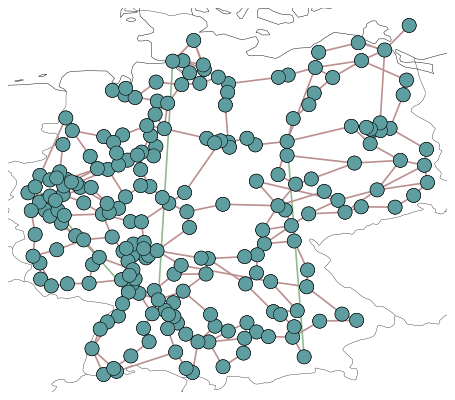

24


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 10004184.417528057
  Upper bound: 10004184.417528057
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x85849_copy
  Lower bound: 6712577.950909718
  Upper bound: 6712577.950909718
  Number of objectives: 1
  Number of constraints: 55465
  Number of variables: 85849
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 85849
  Number of nonzeros: 178461
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

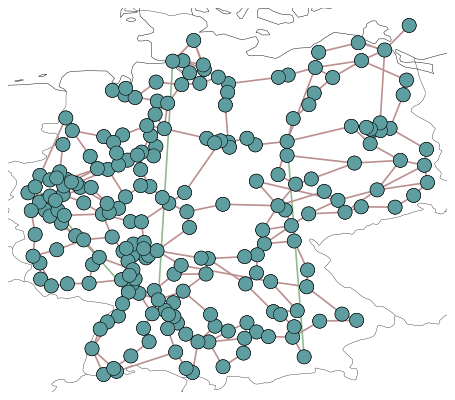

48


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 23246.969730570727
  Upper bound: 23246.969730570727
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x85849_copy
  Lower bound: -298921.91050163
  Upper bound: -298921.91050163
  Number of objectives: 1
  Number of constraints: 55465
  Number of variables: 85849
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 85849
  Number of nonzeros: 178461
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination mes

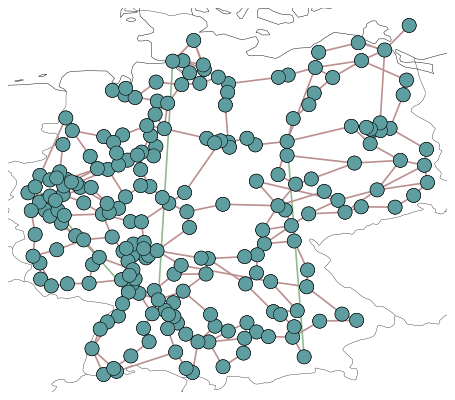

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=8760, freq=None)

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=8760, freq=None)

0


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 373606.30295687733
  Upper bound: 373606.30295687733
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi




Now Redispatch




INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x64729_copy
  Lower bound: 1058233.490206049
  Upper bound: 1058233.490206049
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 64729
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 64729
  Number of nonzeros: 115321
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

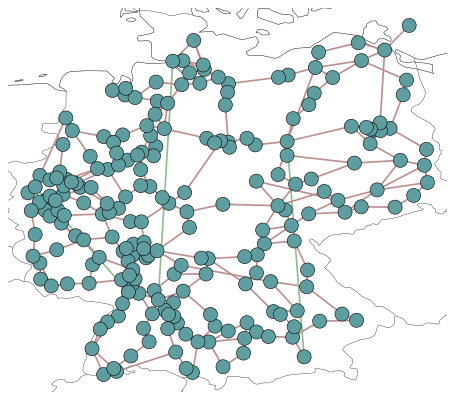

24


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 10004184.417528057
  Upper bound: 10004184.417528057
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x64729_copy
  Lower bound: 7215560.521916944
  Upper bound: 7215560.521916944
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 64729
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 64729
  Number of nonzeros: 115321
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

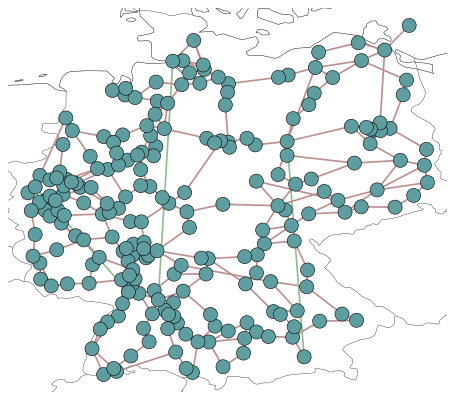

48


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 23246.969730570727
  Upper bound: 23246.969730570727
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x64729_copy
  Lower bound: 2296.6201843009067
  Upper bound: 2296.6201843009067
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 64729
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 64729
  Number of nonzeros: 115321
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

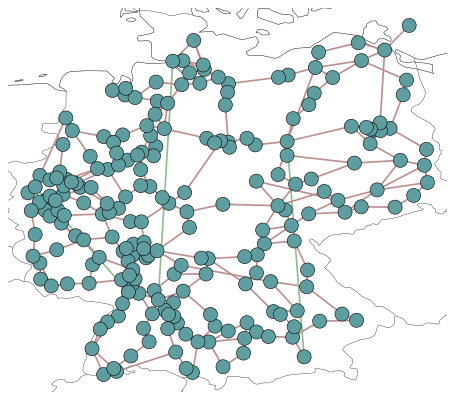

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=8760, freq=None)

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=8760, freq=None)

0


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 373606.30295687733
  Upper bound: 373606.30295687733
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x85849_copy
  Lower bound: 244133.81201493955
  Upper bound: 244133.81201493955
  Number of objectives: 1
  Number of constraints: 55465
  Number of variables: 85849
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 85849
  Number of nonzeros: 178461
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination

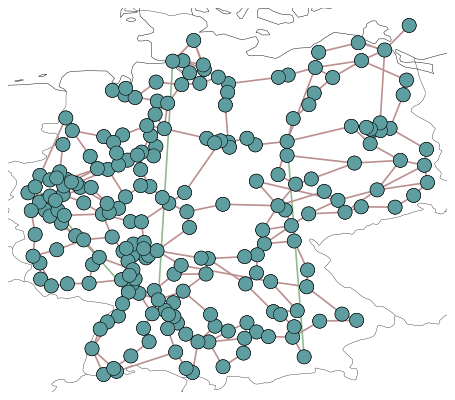

24


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 10004184.417528057
  Upper bound: 10004184.417528057
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x85849_copy
  Lower bound: 6748554.595364493
  Upper bound: 6748554.595364493
  Number of objectives: 1
  Number of constraints: 55465
  Number of variables: 85849
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 85849
  Number of nonzeros: 178461
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

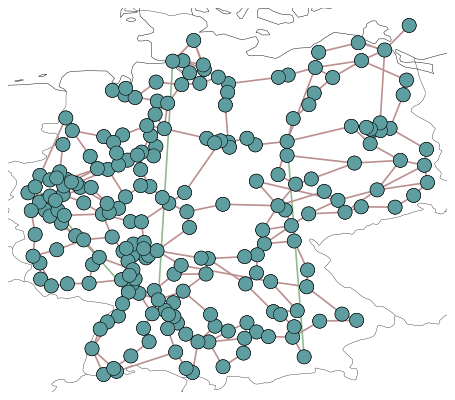

48


Now Dispatch




INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x27169_copy
  Lower bound: 23246.969730570727
  Upper bound: 23246.969730570727
  Number of objectives: 1
  Number of constraints: 23785
  Number of variables: 27169
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 27169
  Number of nonzeros: 77761
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x85849_copy
  Lower bound: -107047.66971253893
  Upper bound: -107047.66971253893
  Number of objectives: 1
  Number of constraints: 55465
  Number of variables: 85849
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 85849
  Number of nonzeros: 178461
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

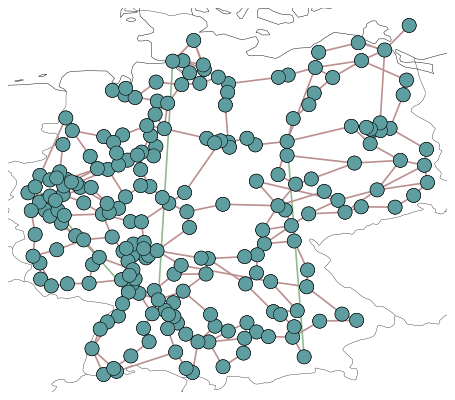

Total cost: Objective value
8276090.632307293


PHS




201941.28920704403

offwind


215616.0763803176

221873.1105838425

onwind


95946.52933592768

329760.5723456239

solar


0.0

0.0

ror


0.0

0.0

coal


53220.41050672756

64552.22294161396

lignite


61570.3206936087

nuclear


0.0

Gas


11268.268743625435

Biomass


8438.911288059653

Redispatch energy conventional + renewable


457392.329383153

Redispatch energy convetional


145829.72366690775

4687828.958817561

cost renew curtailment
Redispatch cost only convetional
4847896.247116875

//////


Total cost: Objective value
6885640.737666894


PHS




197753.53571945938

offwind


213832.997443859

220104.53397797258

onwind


121410.89222244441

348846.83371717756

solar


0.0

0.0

ror


0.0

0.0

coal


34802.94246441848

46134.75489930487

lignite


68813.98772747452

nuclear


0.0

Gas


0.0

Biomass


8578.933899978912

Redispatch energy conventional + renewable


458771.5661930617

Redispatch energy convetional


123527.6765267583

3553014.870893377

cost renew curtailment
Redispatch cost only convetional
3713082.1591926906

//////


Total cost: Objective value
6495752.995179072


PHS




201886.75401592068

offwind


214353.76660532813

220378.89151696095

onwind


133500.7435850993

364792.9791164196

solar


0.0

0.0

ror


0.0

0.0

coal


34830.84458206248

46162.65701694888

lignite


68816.67673801316

nuclear


0.0

Gas


0.0

Biomass


8578.933899978912

Redispatch energy conventional + renewable


471412.7778453684

Redispatch energy convetional


123558.26765494095

3554398.031182914

cost renew curtailment
Redispatch cost only convetional
3714465.3194822273


In [91]:
#### WITHOUT LCOS MIT renewable ramp up
n_d_, n_rd_, n_rd_bat_, n_rd_bat_1_ = solve_redispatch_workflow_future(filename = "elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future", year = 2030)

#n_d_bat, n_rd_bat, n_d_bat_lcos2, n_rd_bat_lcos2 = solve_redispatch_workflow_future(filename = "elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future", year = 2030)


# this time bat 0 lcos without charging compensaiton

sum_rd1, sum_conv1, obj_year1, obj_conv1, df_obj1, df_obj_day1 = analyze_objective_rd(n_rd_)
print("\n//////\n\n")
sum_rd1, sum_conv1, obj_year1, obj_conv1, df_obj1, df_obj_day1 = analyze_objective_rd(n_rd_bat_)
print("\n//////\n\n")
sum_rd1, sum_conv1, obj_year1, obj_conv1, df_obj1, df_obj_day1 = analyze_objective_rd(n_rd_bat_1_)

# print("\n//////\n\n")
# rd_sum, ob_year, df_obj, df_obj_day = analyze_objective_rd(n_rd_bat_lcos)


# n_d.buses_t.marginal_price.mean(axis=1).plot(figsize=(15,7))
# display(n_d.generators.groupby("carrier").marginal_cost.mean())

# display(n_rd.generators_t.p)

# analyze_co2_reduction(n_rd, n_rd_bat)
# analyze_co2_reduction(n_rd, n_rd_bat_lcos)

carrier
CCGT          7.139155e+05
OCGT          4.886920e+04
biomass       1.049745e+06
coal          1.030611e+06
lignite       1.866919e+06
load          0.000000e+00
offwind-ac    3.909448e+05
offwind-dc    1.308227e+06
oil           0.000000e+00
onwind        7.415238e+06
ror           6.978191e+05
solar         8.795855e+05
dtype: float64

carrier
CCGT          8.741011e+05
OCGT          5.782098e+04
biomass       1.011287e+06
coal          1.185961e+06
lignite       2.057543e+06
load          0.000000e+00
offwind-ac    3.487190e+05
offwind-dc    8.878050e+05
oil           0.000000e+00
onwind        7.388879e+06
ror           6.977024e+05
solar         8.795627e+05
dtype: float64

p_nom_max  weight     p_nom  capital_cost  marginal_cost  efficiency  \
load        inf     NaN  100000.0           0.0     142.947328         1.0   

        bus carrier control  p_nom_opt type  p_nom_extendable  p_nom_min  \
load  DE0 0    load      PQ   100000.0                  False        0.0   

      p_min_pu  p_max_pu  p_set  q_set  sign  committable  start_up_cost  \
load       0.0       1.0    0.0    0.0   1.0        False            0.0   

      shut_down_cost  min_up_time  min_down_time  up_time_before  \
load             0.0            0              0               1   

      down_time_before  ramp_limit_up  ramp_limit_down  ramp_limit_start_up  \
load                 0            NaN              NaN                  1.0   

      ramp_limit_shut_down  
load                   1.0

p_nom_max  weight     p_nom  capital_cost  marginal_cost  \
load_1          inf     NaN  100000.0           0.0         1000.0   
load_141        inf     NaN  100000.0           0.0         1000.0   
load_142        inf     NaN  100000.0           0.0         1000.0   
load_143        inf     NaN  100000.0           0.0         1000.0   
load_144        inf     NaN  100000.0           0.0         1000.0   
...             ...     ...       ...           ...            ...   
load_78         inf     NaN  100000.0           0.0         1000.0   
load_79         inf     NaN  100000.0           0.0         1000.0   
load_80         inf     NaN  100000.0           0.0         1000.0   
load_69         inf     NaN  100000.0           0.0         1000.0   
load_220        inf     NaN  100000.0           0.0         1000.0   

          efficiency      bus carrier control  p_nom_opt type  \
load_1           1.0    DE0 0    load      PQ   100000.0        
load_141         1.0   DE0 27    load      PQ   100000.0        
load_142         1.0   DE0 28    load      PQ   100000.0        
load_143         1.0   DE0 29    load      PQ   100000.0        
load_144         1.0    DE0 3    load      PQ   100000.0        
...              ...      ...     ...     ...        ...  ...   
load_78          1.0  DE0 168    load      PQ   100000.0        
load_79          1.0  DE0 169    load      PQ   100000.0        
load_80          1.0   DE0 17    load      PQ   100000.0        
load_69          1.0   DE0 16    load      PQ   100000.0        
load_220         1.0   DE0 99    load      PQ   100000.0        

          p_nom_extendable  p_nom_min  p_min_pu  p_max_pu  p_set  q_set  sign  \
load_1               False        0.0       0.0       1.0    0.0    0.0   1.0   
load_141             False        0.0       0.0       1.0    0.0    0.0   1.0   
load_142             False        0.0       0.0       1.0    0.0    0.0   1.0   
load_143             False        0.0       0.0       1.0    0.0    0.0   1.0   
load_144             False        0.0       0.0       1.0    0.0    0.0   1.0   
...                    ...        ...       ...       ...    ...    ...   ...   
load_78              False        0.0       0.0       1.0    0.0    0.0   1.0   
load_79              False        0.0       0.0       1.0    0.0    0.0   1.0   
load_80              False        0.0       0.0       1.0    0.0    0.0   1.0   
load_69              False        0.0       0.0       1.0    0.0    0.0   1.0   
load_220             False        0.0       0.0       1.0    0.0    0.0   1.0   

          committable  start_up_cost  shut_down_cost  min_up_time  \
load_1          False            0.0             0.0            0   
load_141        False            0.0             0.0            0   
load_142        False            0.0             0.0            0   
load_143        False            0.0             0.0            0   
load_144        False            0.0             0.0            0   
...               ...            ...             ...          ...   
load_78         False            0.0             0.0            0   
load_79         False            0.0             0.0            0   
load_80         False            0.0             0.0            0   
load_69         False            0.0             0.0            0   
load_220        False            0.0             0.0            0   

          min_down_time  up_time_before  down_time_before  ramp_limit_up  \
load_1                0               1                 0            NaN   
load_141              0               1                 0            NaN   
load_142              0               1                 0            NaN   
load_143              0               1                 0            NaN   
load_144              0               1                 0            NaN   
...                 ...             ...               ...            ...   
load_78               0               1               

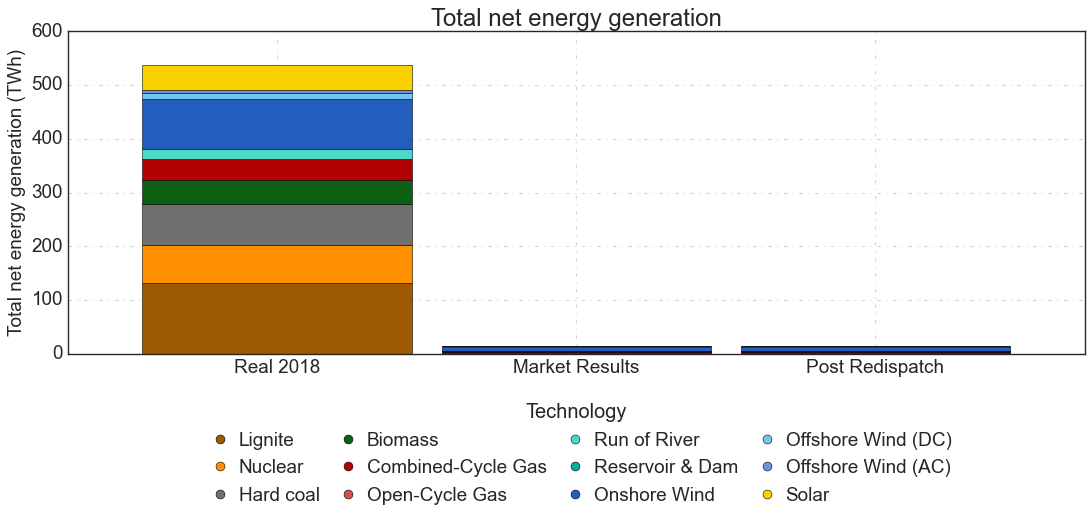

Real 2018  Market Results  Post Redispatch
lignite     131280000.0    1.866919e+06     2.057543e+06
nuclear      72080000.0             NaN              NaN
coal         75000000.0    1.030611e+06     1.185961e+06
biomass      44790000.0    1.049745e+06     1.011287e+06
CCGT         40000000.0    7.139155e+05     8.741011e+05
OCGT                NaN    4.886920e+04     5.782098e+04
ror          17040000.0    6.978191e+05     6.977024e+05
hydro               NaN    4.503475e+04     4.503475e+04
onwind       94350000.0    7.415238e+06     7.388879e+06
offwind-dc   11100000.0    1.308227e+06     8.878050e+05
offwind-ac    5550000.0    3.909448e+05     3.487190e+05
solar        45750000.0    8.795855e+05     8.795627e+05

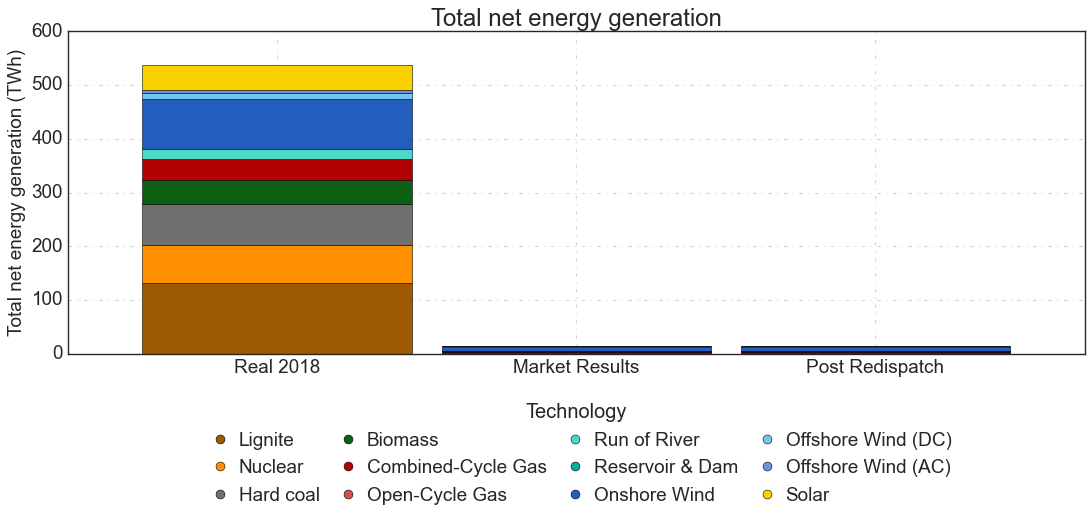

Real 2018  Market Results  Post Redispatch
lignite     131280000.0    2.057543e+06     2.057280e+06
nuclear      72080000.0             NaN              NaN
coal         75000000.0    1.185961e+06     1.170850e+06
biomass      44790000.0    1.011287e+06     1.012663e+06
CCGT         40000000.0    8.741011e+05     8.292056e+05
OCGT                NaN    5.782098e+04     4.843535e+04
ror          17040000.0    6.977024e+05     6.977274e+05
hydro               NaN    4.503475e+04     4.501475e+04
onwind       94350000.0    7.388879e+06     7.460029e+06
offwind-dc   11100000.0    8.878050e+05     8.997103e+05
offwind-ac    5550000.0    3.487190e+05     3.483220e+05
solar        45750000.0    8.795627e+05     8.794652e+05

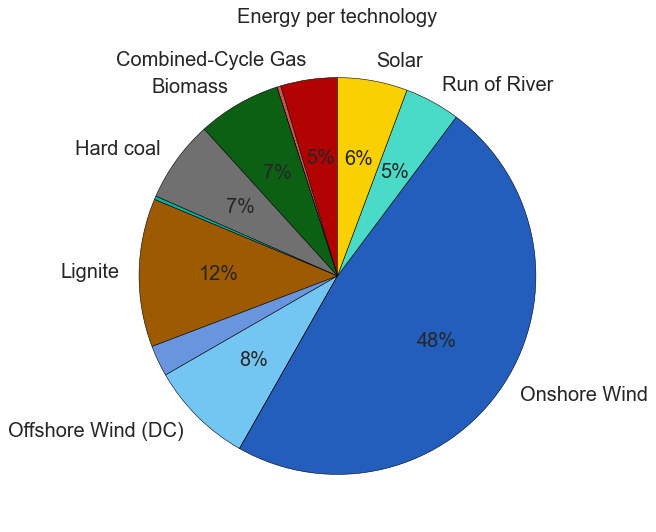

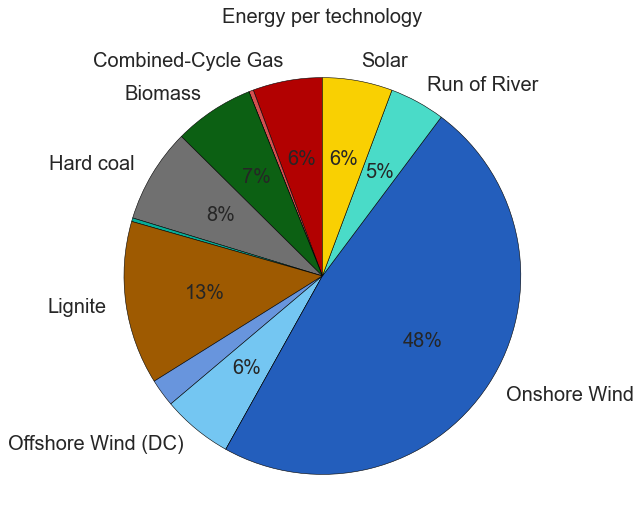

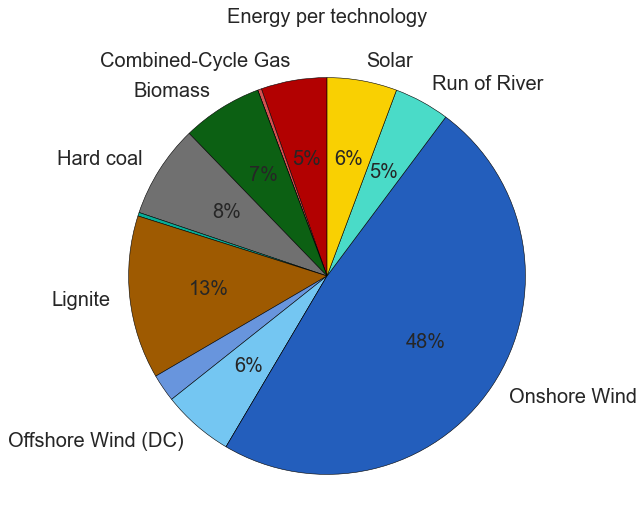

In [155]:
# Test if loadshedding generators are kept or removed
n_d.generators
display(n_d.generators_t.p.sum().groupby(n_d.generators.carrier).sum())
display(n_rd.generators_t.p.sum().groupby(n_rd.generators.carrier).sum())

display(n_d.generators[n_d.generators["carrier"]=="load"].sort_values("marginal_cost"))
display(n_rd.generators[n_rd.generators["carrier"]=="load"].sort_values("marginal_cost"))

fig = energymix_analysis(n_d, n_rd, opts)

fig = energymix_analysis(n_rd, n_rd_bat, opts)

fig1, ax1 = plt.subplots(figsize=(8,8))
plot_total_energy_pie(n_d, ax1)

fig2, ax2 = plt.subplots(figsize=(8,8))
plot_total_energy_pie(n_rd, ax2)

fig3, ax3 = plt.subplots(figsize=(8,8))
plot_total_energy_pie(n_rd_bat, ax3)

In [6]:
# import functions to load the network 
def load_networks(import_path, filename):
    n_d = pypsa.Network(import_path + r"\dispatch\\" + filename + ".nc")
    n_rd = pypsa.Network(import_path + r"\redispatch\\" + filename + ".nc")
    n_rd_bat_load = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_load.nc")
    n_rd_bat_supply = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_supply.nc")
    n_rd_bat_all = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_all.nc")
    n_rd_lcos_load = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_load_LCOS.nc")
    n_rd_lcos_supply = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_supply_LCOS.nc")
    n_rd_lcos_all = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_all_LCOS.nc")
    
    return n_d, n_rd, n_rd_bat_load, n_rd_bat_supply, n_rd_bat_all, n_rd_lcos_load, n_rd_lcos_supply, n_rd_lcos_all

n_d, n_rd, n_rd_bat_load, n_rd_bat_supply, n_rd_bat_all, n_rd_lcos_load, n_rd_lcos_supply, n_rd_lcos_all = load_networks(import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results", filename = r"elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future")

# # import zero cost networks with mean market price = 1
# import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"
# filename = r"elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future"
# n_rd_load1 = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_load_price1.nc")
# n_rd_supply1 = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_supply_price1.nc")
# n_rd_all1 = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_all_price1.nc")


INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future_bat_load.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future_bat_supply.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future_bat_all.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future_bat_load_LCOS.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s3

In [135]:
sum_rd, sum_conv, obj_year, obj_conv, df_obj, df_obj_day = analyze_objective_rd(n_rd)
print("\n////\n")
sum_rd, sum_conv, obj_year, obj_conv, df_obj, df_obj_day = analyze_objective_rd(n_rd_load1)
print("\n////\n")
sum_rd, sum_conv, obj_year, obj_conv, df_obj, df_obj_day = analyze_objective_rd(n_rd_all1)

Total cost: Objective value
2317392478.313611


PHS




23595274.015531834

offwind


19865749.809428155

20269371.481681783

onwind


5162235.96294792

10950421.973136242

solar


-48220.96269839627

52851.88529007184

ror


-785.0342802482925

785.0342802482925

coal


2744884.837730877

11753256.787772538

lignite


8952366.464321287

nuclear


0.0

Gas


14622957.743331686

Biomass


1652694.7146287765

Redispatch energy conventional + renewable


62114982.613568306

Redispatch energy convetional


36990554.91579544

1344250863.3051224

cost renew curtailment
Redispatch cost only convetional
1434467247.948844

////

Total cost: Objective value
2147942567.362048


PHS




15475675.630329434

offwind


19550985.422863364

20253583.349968646

onwind


4213631.463095233

11872666.473739441

solar


-24834.94715982715

43527.87688596862

ror


-767.5166653849758

767.5166653849758

coal


3328306.722466222

12310548.977880241

lignite


10357739.382443443

nuclear


0.0

Gas


11366971.076535143

Biomass


1633204.7056934736

Redispatch energy conventional + renewable


59482750.92283056

Redispatch energy convetional


35668464.14255231

1221016240.7389429

cost renew curtailment
Redispatch cost only convetional
1310396362.1563573

////

Total cost: Objective value
2116983071.3218875


PHS




14387212.10809916

offwind


19444487.7226496

20185809.317668427

onwind


4020357.4126429176

11875774.368527716

solar


-19622.566372482488

38315.49609862395

ror


-777.1589480398252

777.1589480398252

coal


3365164.5407911506

12328862.194590403

lignite


10456655.34543729

nuclear


0.0

Gas


11001689.639432086

Biomass


1620536.989186945

Redispatch energy conventional + renewable


58911834.436684206

Redispatch energy convetional


35407744.16864672

1204707719.2179356

cost renew curtailment
Redispatch cost only convetional
1293580059.046352


Total cost: Objective value
2317392478.313611


PHS




23595274.015531834

offwind


19865749.809428155

20269371.481681783

onwind


5162235.96294792

10950421.973136242

solar


-48220.96269839627

52851.88529007184

ror


-785.0342802482925

785.0342802482925

coal


2744884.837730877

11753256.787772538

lignite


8952366.464321287

nuclear


0.0

Gas


14622957.743331686

Biomass


1652694.7146287765

Redispatch energy conventional + renewable


62114982.613568306

Redispatch energy convetional


36990554.91579544

1344250863.3051224

cost renew curtailment
Redispatch cost only convetional
1434467247.948844

//////


Total cost: Objective value
2163462184.4293113


PHS




15613666.02990352

offwind


19589003.287825026

20240259.9086591

onwind


4257378.942572984

11708332.299488181

solar


-23408.27248340379

42101.20220954526

ror


-690.8317899920494

690.8317899920494

coal


3307748.5742938146

12274832.374998571

lignite


10331612.752382113

nuclear


0.0

Gas


11385234.610967202

Biomass


1635093.7225035562

Redispatch energy conventional + renewable


59519972.23621626

Redispatch energy convetional


35626773.46085144

1219929407.282333

cost renew curtailment
Redispatch cost only convetional
1309329727.771907

//////


Total cost: Objective value
2256454855.5870266


PHS




21489439.323026776

offwind


19656765.704895496

20128525.353826504

onwind


4917510.138805155

11191002.652877599

solar


-36006.260118870174

51773.86257825974

ror


-772.521187539818

772.521187539818

coal


2964370.2570513953

11969405.238829952

lignite


9432893.657299446

nuclear


0.0

Gas


13496868.414100083

Biomass


1640281.1507225614

Redispatch energy conventional + renewable


61186660.2835785

Redispatch energy convetional


36540371.91964011

1300985759.7941797

cost renew curtailment
Redispatch cost only convetional
1390642010.73777

//////


Total cost: Objective value
2136345913.3522048


PHS




14407185.740908368

offwind


19467449.57755864

20159504.227793917

onwind


4111753.5413136976

11783980.445022756

solar


-19607.068451900133

38299.9981780416

ror


-668.6523019458948

668.6523019458948

coal


3340617.5453277677

12337057.595201107

lignite


10414629.935393484

nuclear


0.0

Gas


11022396.977793232

Biomass


1620766.9910660558

Redispatch energy conventional + renewable


59013268.75523002

Redispatch energy convetional


35394851.49945388

1204121613.8857696

cost renew curtailment
Redispatch cost only convetional
1293013400.5263968
No bat        2.317392e+09
bat load      2.163462e+09
bat supply    2.256455e+09
bat all       2.136346e+09
Name: Total RD cost, dtype: float64
No bat        6.211498e+07
bat load      5.951997e+07
bat supply    6.118666e+07
bat all       5.901327e+07
Name: Total redispatch energy, dtype: float64
No bat        1.434467e+09
bat load      1.309330e+09
bat supply    1.390642e+09
bat all       1.293013e+09
Name: Total RD cost, dtype: float64
No bat        3.699055e+07
bat load      3.562677e+07
bat supply    3.654037e+07
bat all       3.539485e+07
Name: Total redispatch energy, dtype: float64


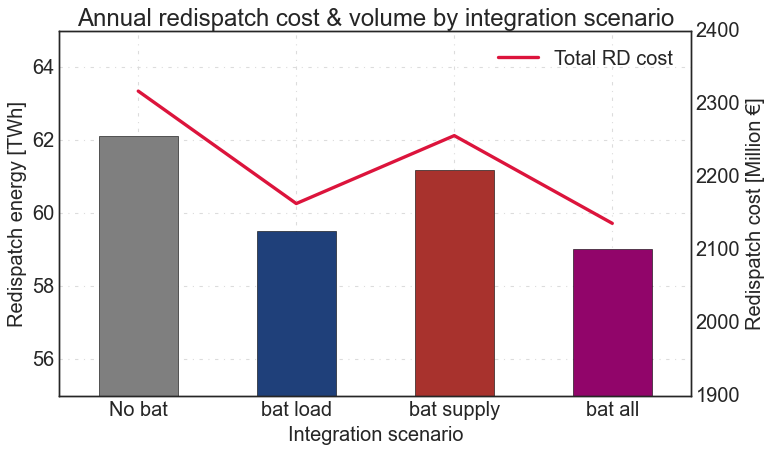

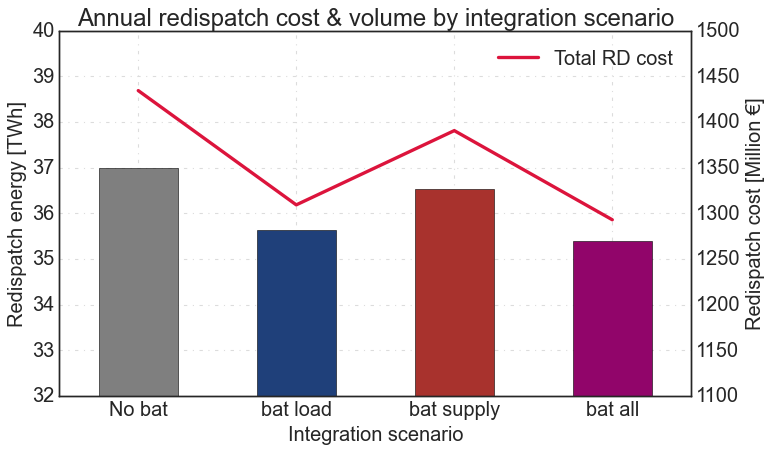

In [148]:
sum_rd1, sum_conv1, obj_year1, obj_conv1, df_obj1, df_obj_day1 = analyze_objective_rd(n_rd)
print("\n//////\n\n")
sum_rd2, sum_conv2, obj_year2, obj_conv2, df_obj2, df_obj_day2 = analyze_objective_rd(n_rd_bat_load)
print("\n//////\n\n")
sum_rd3, sum_conv3, obj_year3, obj_conv3, df_obj3, df_obj_day3 = analyze_objective_rd(n_rd_bat_supply)
print("\n//////\n\n")
sum_rd4, sum_conv4, obj_year4, obj_conv4, df_obj4, df_obj_day4 = analyze_objective_rd(n_rd_bat_all)


list_obj_values = \
[obj_year1,
obj_year2,
obj_year3,
obj_year4]

list_rd_sums = \
[sum_rd1,
sum_rd2,
sum_rd3,
sum_rd4]

list_conv_values = \
[obj_conv1,
obj_conv2,
obj_conv3,
obj_conv4]

list_conv_sums = \
[sum_conv1,
sum_conv2,
sum_conv3,
sum_conv4]


# Redispatch cost "elbow curve"
s_obj_values = pd.Series(list_obj_values, name = "Total RD cost", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Redispatch energy "elbow curve"
s_sum_rd = pd.Series(list_rd_sums, name = "Total redispatch energy", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Redispatch cost "elbow curve"
s_conv_values = pd.Series(list_conv_values, name = "Total RD cost", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Redispatch energy "elbow curve"
s_sum_conv = pd.Series(list_conv_sums, name = "Total redispatch energy", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Colors from power point
colors = \
["#7F7F7F", # grey
 "#1F407A", # eth blue
 "#A8322D", # eth red
 "#91056A"] #eth purple  

print(s_obj_values)
print(s_sum_rd)
print(s_conv_values)
print(s_sum_conv)


# Plot all redispatch ELBOW CURVE with energy and costs
# Relative redispatch cost savings vs absolute savings
#########################################################
fig, ax  = plt.subplots(figsize = (10, 6))
size = 18
# scale y-axis to Million €
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

ax.set_ylabel('Redispatch energy [TWh]',  fontsize = size)
ax.set_xlabel("Integration scenario", fontsize = size)
ax = s_sum_rd.plot.bar(stacked = False, ax = ax, title = "Annual redispatch cost & volume by integration scenario", 
                                  color = colors, legend = False, fontsize = size, width = 0.5)

ax.set_facecolor('white')
#ax.legend(loc = "upper left", fontsize = size)
ax.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax.set_axisbelow(True)
ax.set_ylim((55000000,65000000))

ax.set_xticklabels(s_obj_values.index, rotation=0, ha='center')
ax_ = ax.twinx()
s_obj_values.plot.line(ax = ax_, linewidth = 3, color = "crimson", legend = True, fontsize = size)
# Scale y-axis to Million MWh (TWh)
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax_.yaxis.set_major_formatter(ticks_y)
ax_.set_ylabel('Redispatch cost [Million €]',  fontsize = size)
ax_.legend(loc = "upper right", fontsize = size)
ax_.set_ylim((1900000000,2400000000))
fig.tight_layout()
plt.show()

###################### EXPORT
savename = "Annual redispatch each scenario 2030"
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################


# # Plot for CONVENTIONAL REDISPATCH COST
# # Relative redispatch cost savings vs absolute savings
# #########################################################
fig2, ax2  = plt.subplots(figsize = (10, 6))
size = 18
# scale y-axis to Million €
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax2.yaxis.set_major_formatter(ticks_y)

ax2.set_ylabel('Redispatch energy [TWh]',  fontsize = size)
ax2.set_xlabel("Integration scenario", fontsize = size)
ax2 = s_sum_conv.plot.bar(stacked = False, ax = ax2, title = "Annual redispatch cost & volume by integration scenario", 
                                  color = colors, legend = False, fontsize = size, width = 0.5)

ax2.set_facecolor('white')
#ax.legend(loc = "upper left", fontsize = size)
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)
ax2.set_ylim((32000000,40000000))

ax2.set_xticklabels(s_obj_values.index, rotation=0, ha='center')
ax2_ = ax2.twinx()
s_conv_values.plot.line(ax = ax2_, linewidth = 3, color = "crimson", legend = True, fontsize = size)
# Scale y-axis to Million MWh (TWh)
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax2_.yaxis.set_major_formatter(ticks_y)
ax2_.set_ylabel('Redispatch cost [Million €]',  fontsize = size)
ax2_.legend(loc = "upper right", fontsize = size)
ax2_.set_ylim((1100000000,1500000000))
fig2.tight_layout()

plt.show()


###################### EXPORT
savename = "Annual conventional redispatch each scenario 2030"
fig2.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig2.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################

In [ ]:
fig = energymix_analysis_future(n_d, n_rd, n_rd_bat_all, size=17,opts=opts)



Total cost: Objective value
2317392478.313611


PHS




23595274.015531834

offwind


19865749.809428155

20269371.481681783

onwind


5162235.96294792

10950421.973136242

solar


-48220.96269839627

52851.88529007184

ror


-785.0342802482925

785.0342802482925

coal


2744884.837730877

11753256.787772538

lignite


8952366.464321287

nuclear


0.0

Gas


14622957.743331686

Biomass


1652694.7146287765

Redispatch energy conventional + renewable


62114982.613568306

Redispatch energy convetional


36990554.91579544

1344250863.3051224

cost renew curtailment
Redispatch cost only convetional
1434467247.948844

//////


Total cost: Objective value
2271137033.2939987


PHS




22798647.990575723

offwind


19489590.877529252

20207923.57995193

onwind


4603439.762986507

11749844.096153228

solar


-28108.62493374149

45095.26095478217

ror


-756.5199255153543

756.5199255153543

coal


2722630.8120287424

11734013.498752004

lignite


9579572.409098748

nuclear


0.0

Gas


13092359.209863491

Biomass


1640920.607981575

Redispatch energy conventional + renewable


60196113.61607906

Redispatch energy convetional


36046865.72569582

1276869158.1587331

cost renew curtailment
Redispatch cost only convetional
1366606634.0211089

//////


Total cost: Objective value
2295271678.146953


PHS




23351261.352136437

offwind


19558003.61781177

20097521.44072767

onwind


5127785.374816324

11273345.351096358

solar


-38795.29831934372

53245.045301241145

ror


-814.2475407698682

814.2475407698682

coal


2730172.211419844

11751445.276768459

lignite


9164373.85468443

nuclear


0.0

Gas


14094840.685441365

Biomass


1643285.7413678295

Redispatch energy conventional + renewable


61418613.75504838

Redispatch energy convetional


36655234.1657816

1320130611.920671

cost renew curtailment
Redispatch cost only convetional
1410003744.3426728

//////


Total cost: Objective value
2260930489.6055136


PHS




22665237.41999229

offwind


19445346.386807647

20194155.294154007

onwind


4453080.366027076

11780499.330820972

solar


-23966.127304798174

40959.97874906822

ror


-769.9467480436367

769.9467480436367

coal


2693917.2679237733

11699146.135577068

lignite


9622913.716073394

nuclear


0.0

Gas


12877376.320433049

Biomass


1630946.926074334

Redispatch energy conventional + renewable


59776742.10560217

Redispatch energy convetional


35830383.098157845

1265105596.0303304

cost renew curtailment
Redispatch cost only convetional
1354549028.0844696
No bat        2.317392e+09
bat load      2.271137e+09
bat supply    2.295272e+09
bat all       2.260930e+09
Name: Total RD cost, dtype: float64
No bat        6.211498e+07
bat load      6.019611e+07
bat supply    6.141861e+07
bat all       5.977674e+07
Name: Total redispatch energy, dtype: float64
No bat        1.434467e+09
bat load      1.366607e+09
bat supply    1.410004e+09
bat all       1.354549e+09
Name: Total RD cost, dtype: float64
No bat        3.699055e+07
bat load      3.604687e+07
bat supply    3.665523e+07
bat all       3.583038e+07
Name: Total redispatch energy, dtype: float64


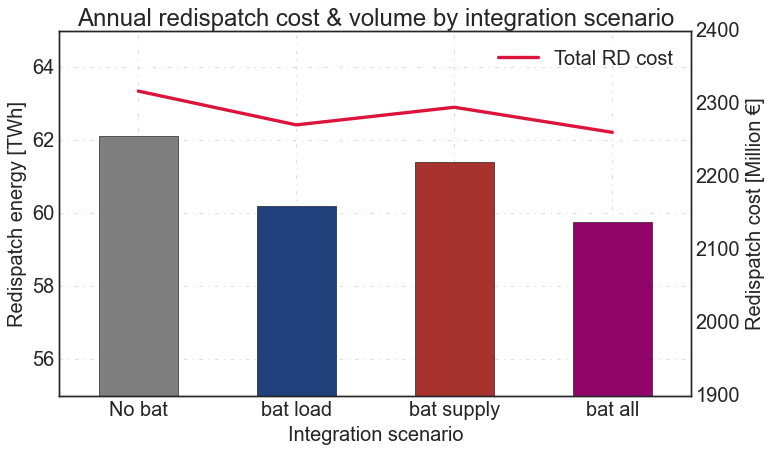

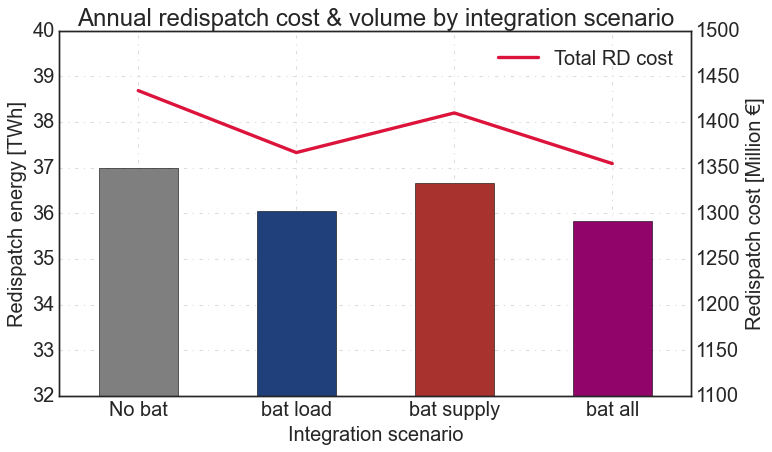

In [150]:
sum_rd1, sum_conv1, obj_year1, obj_conv1, df_obj1, df_obj_day1 = analyze_objective_rd(n_rd)
print("\n//////\n\n")
sum_rd2, sum_conv2, obj_year2, obj_conv2, df_obj2, df_obj_day2 = analyze_objective_rd(n_rd_lcos_load)
print("\n//////\n\n")
sum_rd3, sum_conv3, obj_year3, obj_conv3, df_obj3, df_obj_day3 = analyze_objective_rd(n_rd_lcos_supply)
print("\n//////\n\n")
sum_rd4, sum_conv4, obj_year4, obj_conv4, df_obj4, df_obj_day4 = analyze_objective_rd(n_rd_lcos_all)


list_obj_values_lcos = \
[obj_year1,
obj_year2,
obj_year3,
obj_year4]

list_rd_sums_lcos = \
[sum_rd1,
sum_rd2,
sum_rd3,
sum_rd4]

list_conv_values_lcos = \
[obj_conv1,
obj_conv2,
obj_conv3,
obj_conv4]

list_conv_sums_lcos = \
[sum_conv1,
sum_conv2,
sum_conv3,
sum_conv4]


# Redispatch cost "elbow curve"
s_obj_values_lcos = pd.Series(list_obj_values_lcos, name = "Total RD cost", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Redispatch energy "elbow curve"
s_sum_rd_lcos = pd.Series(list_rd_sums_lcos, name = "Total redispatch energy", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Redispatch cost "elbow curve"
s_conv_values_lcos = pd.Series(list_conv_values_lcos, name = "Total RD cost", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Redispatch energy "elbow curve"
s_sum_conv_lcos = pd.Series(list_conv_sums_lcos, name = "Total redispatch energy", index= \
["No bat",
 "bat load",
 "bat supply",
 "bat all"])

# Colors from power point
colors = \
["#7F7F7F", # grey
 "#1F407A", # eth blue
 "#A8322D", # eth red
 "#91056A"] #eth purple  

print(s_obj_values_lcos)
print(s_sum_rd_lcos)
print(s_conv_values_lcos)
print(s_sum_conv_lcos)



# Plot all redispatch ELBOW CURVE with energy and costs
# Relative redispatch cost savings vs absolute savings
#########################################################
fig, ax  = plt.subplots(figsize = (10, 6))
size = 18
# scale y-axis to Million €
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

ax.set_ylabel('Redispatch energy [TWh]',  fontsize = size)
ax.set_xlabel("Integration scenario", fontsize = size)
ax = s_sum_rd_lcos.plot.bar(stacked = False, ax = ax, title = "Annual redispatch cost & volume by integration scenario", 
                                  color = colors, legend = False, fontsize = size, width = 0.5)

ax.set_facecolor('white')
#ax.legend(loc = "upper left", fontsize = size)
ax.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax.set_axisbelow(True)
ax.set_ylim((55000000,65000000))

ax.set_xticklabels(s_obj_values.index, rotation=0, ha='center')
ax_ = ax.twinx()
s_obj_values_lcos.plot.line(ax = ax_, linewidth = 3, color = "crimson", legend = True, fontsize = size)
# Scale y-axis to Million MWh (TWh)
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax_.yaxis.set_major_formatter(ticks_y)
ax_.set_ylabel('Redispatch cost [Million €]',  fontsize = size)
ax_.legend(loc = "upper right", fontsize = size)
ax_.set_ylim((1900000000,2400000000))
fig.tight_layout()
plt.show()

###################### EXPORT
savename = "Annual redispatch each scenario 2030 LCOS"
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################


# # Plot for CONVENTIONAL REDISPATCH COST
# # Relative redispatch cost savings vs absolute savings
# #########################################################
fig2, ax2  = plt.subplots(figsize = (10, 6))
size = 18
# scale y-axis to Million €
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax2.yaxis.set_major_formatter(ticks_y)

ax2.set_ylabel('Redispatch energy [TWh]',  fontsize = size)
ax2.set_xlabel("Integration scenario", fontsize = size)
ax2 = s_sum_conv_lcos.plot.bar(stacked = False, ax = ax2, title = "Annual redispatch cost & volume by integration scenario", 
                                  color = colors, legend = False, fontsize = size, width = 0.5)

ax2.set_facecolor('white')
#ax.legend(loc = "upper left", fontsize = size)
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)
ax2.set_ylim((32000000,40000000))

ax2.set_xticklabels(s_obj_values.index, rotation=0, ha='center')
ax2_ = ax2.twinx()
s_conv_values_lcos.plot.line(ax = ax2_, linewidth = 3, color = "crimson", legend = True, fontsize = size)
# Scale y-axis to Million MWh (TWh)
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax2_.yaxis.set_major_formatter(ticks_y)
ax2_.set_ylabel('Redispatch cost [Million €]',  fontsize = size)
ax2_.legend(loc = "upper right", fontsize = size)
ax2_.set_ylim((1100000000,1500000000))
fig2.tight_layout()

plt.show()


###################### EXPORT
savename = "Annual redispatch each scenario 2030 LCOS"
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################

RD cost reduction  RD cost reduction LCOS  Total RD energy  \
No bat           2.317392e+09            2.317392e+09     6.211498e+07   
bat load        -1.539303e+08           -4.625545e+07    -2.595010e+06   
bat supply      -6.093762e+07           -2.212080e+07    -9.283223e+05   
bat all         -1.810466e+08           -5.646199e+07    -3.101714e+06   

            Total RD energy LCOS  Cost reduction potential  \
No bat              6.211498e+07                100.000000   
bat load           -1.918869e+06                 -6.642392   
bat supply         -6.963689e+05                 -2.629577   
bat all            -2.338241e+06                 -7.812512   

            % energy reduction  Cost reduction LCOS  % energy reduction LCOS  \
No bat              100.000000           100.000000               100.000000   
bat load             -4.177753            -1.996013                -3.089221   
bat supply           -1.494522            -0.954556                -1.121096   
bat all              -4.993504            -2.436445                -3.764374   

            Share of potential achieved  Share of energy potential achieved  
No bat                       100.000000                          100.000000  
bat load                      30.049605                           73.944560  
bat supply                    36.300727                           75.013693  
bat all                       31.186446                           75.385436

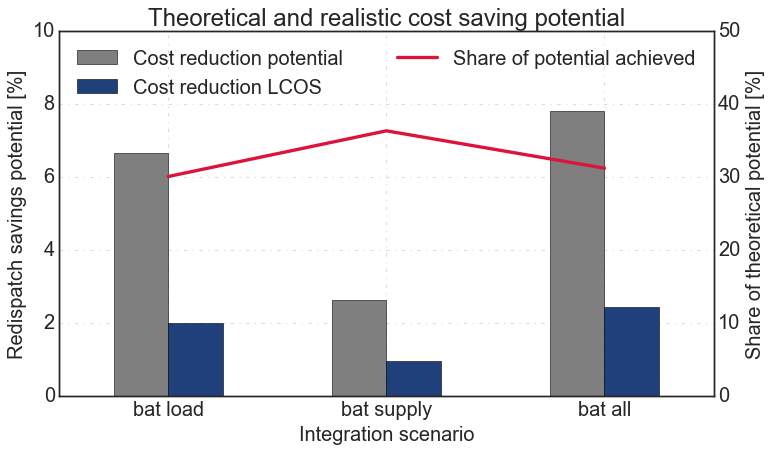

In [140]:
# Comparison: Share of saving potential achieved
# ----------------------------------------------

df_potential_share = pd.concat((s_obj_values,s_obj_values_lcos,s_sum_rd,s_sum_rd_lcos),axis=1)
df_potential_share.columns = ["RD cost reduction","RD cost reduction LCOS","Total RD energy","Total RD energy LCOS"]
df_potential_share.iloc[1:,:] = df_potential_share.iloc[1:,:] - df_potential_share.iloc[0,:]

# determine what share of potential could be achieved

df_potential_share["Cost reduction potential"] = df_potential_share["RD cost reduction"]/df_potential_share["RD cost reduction"].iloc[0] * 100
df_potential_share["% energy reduction"] = df_potential_share["Total RD energy"]/df_potential_share["Total RD energy"].iloc[0] * 100
df_potential_share["Cost reduction LCOS"] = df_potential_share["RD cost reduction LCOS"]/df_potential_share["RD cost reduction LCOS"].iloc[0] * 100
df_potential_share["% energy reduction LCOS"] = df_potential_share["Total RD energy LCOS"]/df_potential_share["Total RD energy LCOS"].iloc[0] * 100

# share of theoretical potential that could be achieved
df_potential_share["Share of potential achieved"] = df_potential_share["RD cost reduction LCOS"]/df_potential_share["RD cost reduction"]*100
df_potential_share["Share of energy potential achieved"] = df_potential_share["Total RD energy LCOS"]/df_potential_share["Total RD energy"]*100

display(df_potential_share)





# plot share of savings
fig2, ax2  = plt.subplots(figsize = (10, 6))
size = 18
# scale y-axis to Million €

ax2.set_ylabel('Redispatch savings potential [%]',  fontsize = size)
ax2.set_xlabel("Integration scenario", fontsize = size)
ax2 = df_potential_share[["Cost reduction potential","Cost reduction LCOS"]].abs().iloc[1:]\
    .plot.bar(stacked = False, ax = ax2, title = "Theoretical and realistic cost saving potential", 
              color = colors, legend = False, fontsize = size, width = 0.5)

ax2.set_facecolor('white')
ax2.legend(loc = "upper left", fontsize = size)
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)
ax2.set_ylim((0,10))
ax2.set_xticklabels(df_potential_share.iloc[1:].index, rotation=0, ha='center')


ax2_ = ax2.twinx()
df_potential_share["Share of potential achieved"].abs().iloc[1:].plot.line(ax = ax2_, linewidth = 3, color = "crimson", legend = True, fontsize = size)
# Scale y-axis to Million MWh (TWh)
ax2_.set_ylabel('Share of theoretical potential [%]',  fontsize = size)
ax2_.legend(loc = "upper right", fontsize = size)
ax2_.set_ylim((0.0,50.0))
fig2.tight_layout()



###################### EXPORT
savename = "Share of theoretical potential achieved"
df_potential_share.to_csv(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".csv", sep=";")
fig2.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig2.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')

######################

-115409.3575321477

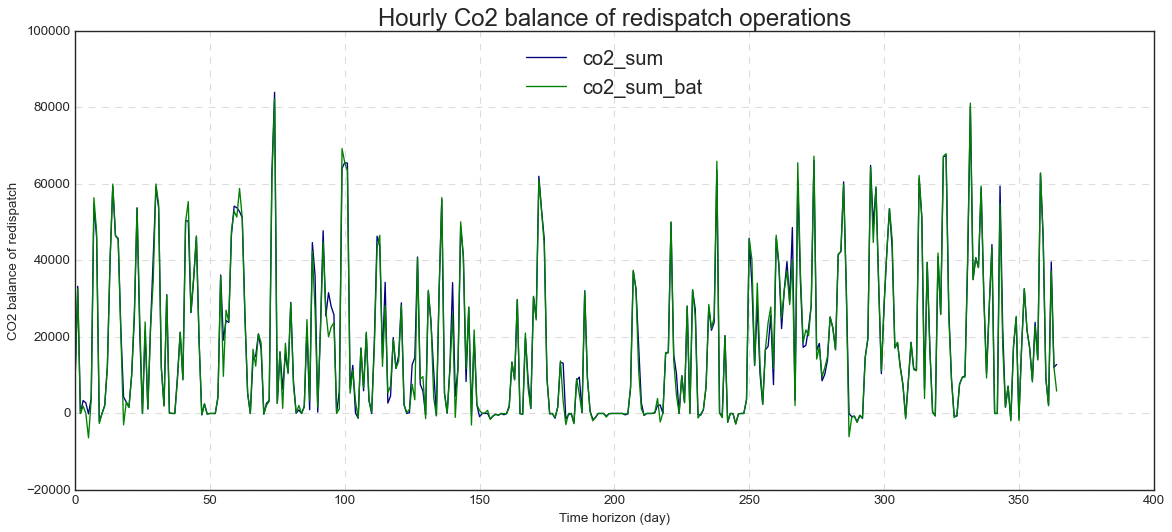

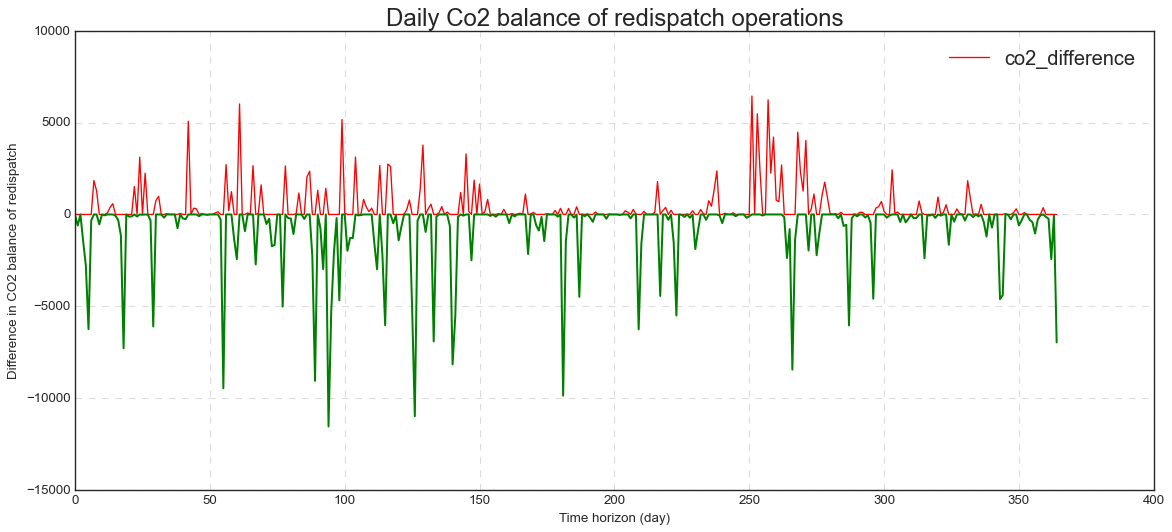

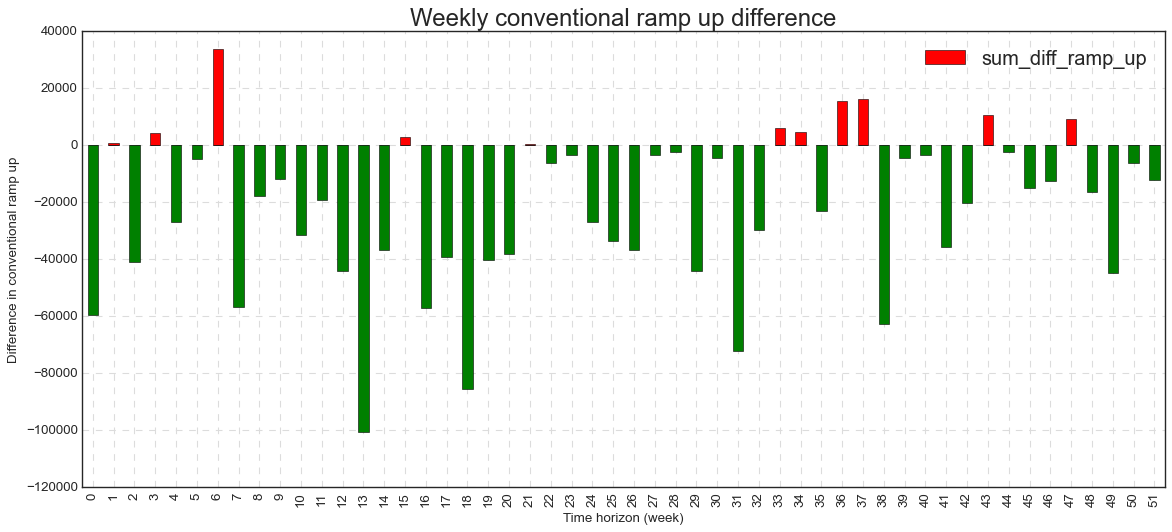

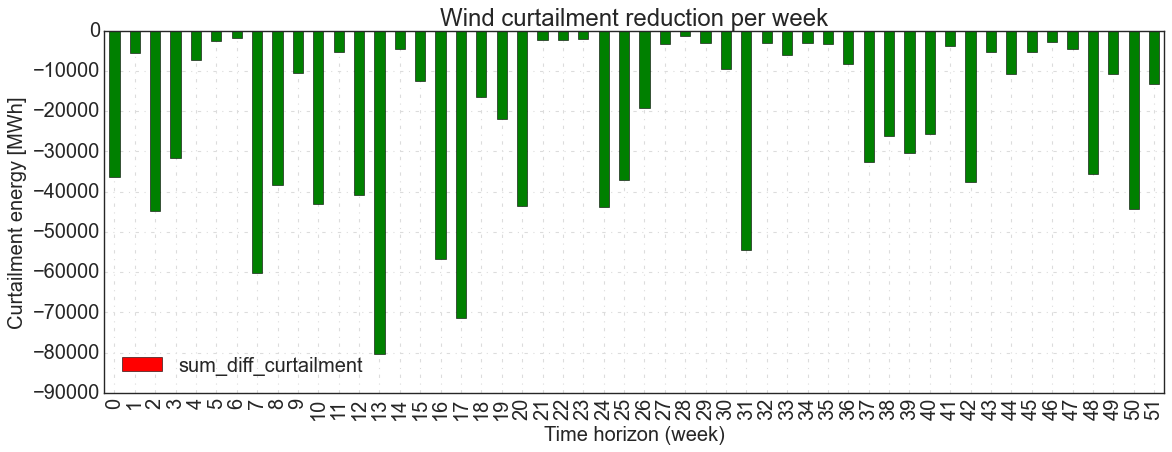

In [93]:
analyze_co2_reduction(n_rd, n_rd_lcos_all)

In [ ]:
# Analzye market price
n_d.buses_t.marginal_price.mean(axis=1).plot(figsize=(25,5))
print(n_d.buses_t.marginal_price.mean(axis=1).mean())

In [18]:
display(n_rd.generators.groupby("carrier").marginal_cost.mean())
display(n_rd.storage_units.marginal_cost.mean())

carrier
CCGT            18.226667
OCGT            22.658120
biomass          0.000000
coal            13.120690
lignite          9.477256
load          1000.000000
offwind-ac       0.005000
offwind-dc       0.005000
oil             47.615776
onwind           0.005000
ror              0.000000
solar            0.003333
Name: marginal_cost, dtype: float64

0.0

-115409.3575321477

name                DE0 0 onwind_neg  DE0 0 onwind_pos  DE0 1 onwind_neg  \
Time horizon (day)                                                         
0                                0.0       -270.726166               0.0   
1                                0.0          0.000000               0.0   
2                                0.0          0.000000               0.0   
3                                0.0          0.000000               0.0   
4                                0.0          0.000000               0.0   
...                              ...               ...               ...   
360                              0.0          0.000000               0.0   
361                              0.0          0.000000               0.0   
362                              0.0          0.000000               0.0   
363                              0.0          0.000000               0.0   
364                              0.0          0.000000               0.0   

name                DE0 1 onwind_pos  DE0 10 onwind_neg  DE0 10 onwind_pos  \
Time horizon (day)                                                           
0                         218.128847                0.0          -1.977061   
1                           0.000000                0.0           0.000000   
2                         -63.860540                0.0          55.357707   
3                        -186.217041                0.0           0.000000   
4                           0.000000                0.0           0.000000   
...                              ...                ...                ...   
360                         0.000000                0.0           0.000000   
361                         0.000000                0.0           0.000000   
362                         0.000000                0.0           0.000000   
363                         0.000000                0.0           0.000000   
364                         0.000000                0.0           0.000000   

name                DE0 100 onwind_neg  DE0 100 onwind_pos  \
Time horizon (day)                                           
0                                  0.0            0.000000   
1                                  0.0            0.000000   
2                                  0.0          179.258557   
3                                  0.0            0.000000   
4                                  0.0         -141.415084   
...                                ...                 ...   
360                                0.0            0.000000   
361                                0.0            0.000000   
362                                0.0            0.000000   
363                                0.0          -83.653993   
364                                0.0            0.000000   

name                DE0 101 onwind_neg  DE0 101 onwind_pos  \
Time horizon (day)                                           
0                                  0.0            0.000000   
1                                  0.0            0.000000   
2                                  0.0         1254.532174   
3                                  0.0            0.000000   
4                                  0.0            0.000000   
...                                ...                 ...   
360                                0.0            0.000000   
361                                0.0            0.000000   
362                                0.0            0.000000   
363                                0.0            0.000000   
364                                0.0            0.000000   

name                DE0 102 onwind_neg  DE0 102 onwind_pos  \
Time horizon (day)                                           
0                                  0.0         -164.587360   
1                                  0.0            0.000000   
2                                  0.0         -174.268970   
3                                  0.0            0.000000   
4         

-25027985.77237608

Total wind reduction
-1129559.0195413535
0.04513183880694354

Onwind reduction
-709155.5969208442


0.13737372758836025

No batteries  With batteries  Ramp up reduction  \
Lignite      8.952366e+06    9.622914e+06      -6.705473e+05   
Hard coal    7.249071e+06    7.196532e+06       5.253911e+04   
Natural Gas  1.449177e+07    1.276596e+07       1.725808e+06   
Oil          9.279206e+03    0.000000e+00       9.279206e+03   

             Relative reduction  
Lignite               -7.490168  
Hard coal              0.724770  
Natural Gas           11.908882  
Oil                  100.000000

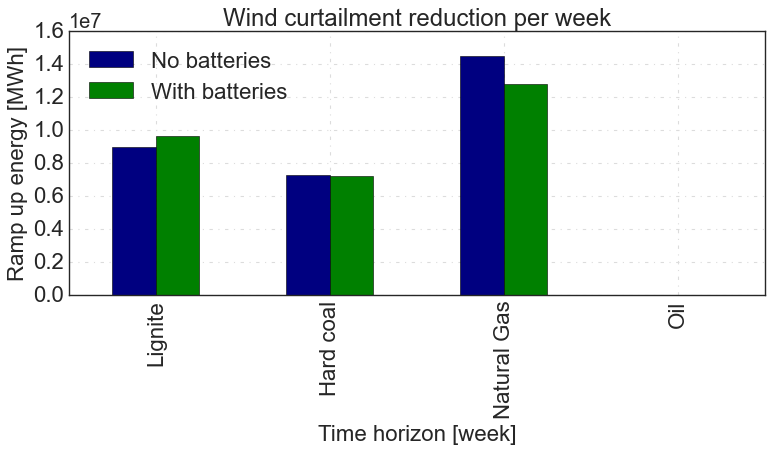

In [174]:
def analyze_co2_reduction(network_rd,network_rd_bat):
    """
    Function to analyze and plot co2 related metrics
    """

    # W/o bat
    df_gen = network_rd.generators.copy()
    dict_co2 = pd.Series(network_rd.carriers["co2_emissions"].values,index=network_rd.carriers.index).to_dict()
    df_gen["co2_emissions"] = df_gen["carrier"].apply(map_values, args = (dict_co2,)) 
    dict_co2_gen = pd.Series(df_gen["co2_emissions"].values,index=df_gen.index).to_dict()
    cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    # assign co2 emissions to the redispatch energy dataframe
    for col in list(df_rd_p):
        df_rd_p[col] = df_rd_p[col] * dict_co2_gen[col]
    df_rd_p["co2_sum"] = df_rd_p.sum(axis = 1)
    df_rd_p.index.rename("Time horizon (hour)", inplace = True)
    
    # With Bat
    df_gen_bat = network_rd_bat.generators.copy()
    dict_co2 = pd.Series(network_rd_bat.carriers["co2_emissions"].values,index=network_rd_bat.carriers.index).to_dict()
    df_gen_bat["co2_emissions"] = df_gen_bat["carrier"].apply(map_values, args = (dict_co2,))
    dict_co2_gen = pd.Series(df_gen_bat["co2_emissions"].values,index=df_gen_bat.index).to_dict()
    cols_rd = [column for column in list(network_rd_bat.generators_t.p) if "pos" in column or "neg" in column]
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    # assign co2 emissions to the redispatch energy dataframe
    for col in list(df_rd_p_bat):
        df_rd_p_bat[col] = df_rd_p_bat[col] * dict_co2_gen[col]
    df_rd_p_bat["co2_sum_bat"] = df_rd_p_bat.sum(axis = 1)
    df_rd_p_bat.index.rename("Time horizon (hour)", inplace = True)

    # Df for direct co2 comparison
    df_co2 = pd.concat([df_rd_p["co2_sum"], df_rd_p_bat["co2_sum_bat"]], axis = 1)
    df_co2["co2_difference"] = df_co2["co2_sum_bat"] - df_co2["co2_sum"]
    df_co2.index.rename("Time horizon (hour)", inplace = True)
    diff_co2_sum = df_co2["co2_difference"].sum()
    
    # Df for daily co2 comparison
    df_co2_day = df_co2.iloc[:-1].groupby(np.arange(len(df_co2.iloc[:-1]))//24).sum()
    co2_sum_day = df_co2_day["co2_difference"].sum()

    display(diff_co2_sum)

    
    
    # Wind curtailment analysis -> reduction in wind curtailment
    # -------------
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    cols_wind = [column for column in list(df_rd_p) if "wind" in column]
    df_rd_wind = df_rd_p[cols_wind]
    df_rd_bat_wind = df_rd_p_bat[cols_wind]
    #dataframes for relative comparison (week)
    df_rd_wind_day = df_rd_wind.groupby(np.arange(len(df_rd_wind))//24).sum()
    df_rd_wind_week= df_rd_wind_day.groupby(np.arange(len(df_rd_wind_day))//7).sum()[:-1]
    
    df_rd_diff_wind = df_rd_wind - df_rd_bat_wind # > 0 more curtailment < 0 less curtailment
    df_rd_diff_wind["sum_diff_curtailment"] = df_rd_diff_wind.sum(axis = 1)
    df_rd_diff_wind["% curtailment reduction"] = df_rd_diff_wind["sum_diff_curtailment"] / df_rd_wind.sum(axis=1)*100
    
    
    # DAILY wind curtailment analysis
    df_rd_diff_wind_day = df_rd_diff_wind.iloc[:,:-1].groupby(np.arange(len(df_rd_diff_wind))//24).sum()
    df_rd_diff_wind_day["% curtailment reduction"] = df_rd_diff_wind_day["sum_diff_curtailment"] / df_rd_wind_day.sum(axis=1)*100
    df_rd_diff_wind_day.index.rename("Time horizon (day)", inplace = True)
    display(df_rd_diff_wind_day)
    
    # WEEKLY wind curtailment analysis
    df_rd_diff_wind_week = df_rd_diff_wind_day.iloc[:,:-1].groupby(np.arange(len(df_rd_diff_wind_day))//7).sum()[:-1]
    df_rd_diff_wind_week["% curtailment reduction"] = df_rd_diff_wind_week["sum_diff_curtailment"] / df_rd_wind_week.sum(axis=1)*100
    df_rd_diff_wind_week.index.rename("Time horizon (week)", inplace = True)
    
    # Curtailment sum (and % of total reduction)
    sum_wind_diff = df_rd_diff_wind["sum_diff_curtailment"].sum()
    rel_wind_diff = df_rd_diff_wind["sum_diff_curtailment"].sum() / df_rd_wind.sum(axis=1).sum()
    print(df_rd_wind.sum(axis=1).sum())
    print("\nTotal wind reduction")
    print(sum_wind_diff)
    print(rel_wind_diff)
    
    # Curtailment sum ONLY ON-SHORE wind
    df_onwind = df_rd_p[[column for column in list(df_rd_p) if "onwind" in column]]
    df_onwind_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "onwind" in column]]
    df_onwind_diff = df_onwind - df_onwind_bat
    sum_onwind_diff = df_onwind_diff.sum(axis=1).sum()
    rel_onwind_diff = sum_onwind_diff / df_onwind.sum(axis=1).sum()
    print("\nOnwind reduction")
    print(sum_onwind_diff)
    display(rel_onwind_diff)
    

    # Conventional analysis -> reduction in conventional ramp up
    # -------------
    df_rd_p = network_rd.generators_t.p[cols_rd].copy()
    df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
    cols_pos = [column for column in list(df_rd_p) if "pos" in column]
    df_ramp_p = df_rd_p[cols_pos]
    df_ramp_p_bat = df_rd_p_bat[cols_pos]
    
    # Only extract columns with conventional carriers 
    cols_gas = [column for column in list(df_ramp_p) if "CCGT" in column or "OCGT" in column]
    cols_oil = [column for column in list(df_ramp_p) if "oil" in column]
    cols_lignite = [column for column in list(df_ramp_p) if "lignite" in column]
    cols_nuclear = [column for column in list(df_ramp_p) if "nuclear" in column]
    cols_coal = [column for column in list(df_ramp_p) if "coal" in column]
    cols_conv = cols_gas + cols_oil + cols_lignite + cols_nuclear + cols_coal + cols_coal
    df_ramp_conv = df_ramp_p[cols_conv]
    df_ramp_conv_bat = df_ramp_p_bat[cols_conv]
    
    # Create pandas dataframe with total sum of ramp up each carrier for nobat and bat
    # ---------------------------
    sum_lignite     = df_ramp_p[cols_lignite].sum(axis=1).sum() 
    sum_coal        = df_ramp_p[cols_coal].sum(axis=1).sum() 
    sum_gas         = df_ramp_p[cols_gas].sum(axis=1).sum() 
    sum_oil         = df_ramp_p[cols_oil].sum(axis=1).sum() 
    sum_lignite_bat = df_ramp_p_bat[cols_lignite].sum(axis=1).sum() 
    sum_coal_bat    = df_ramp_p_bat[cols_coal].sum(axis=1).sum() 
    sum_gas_bat     = df_ramp_p_bat[cols_gas].sum(axis=1).sum() 
    sum_oil_bat     = df_ramp_p_bat[cols_oil].sum(axis=1).sum()
    s_sum = pd.Series([sum_lignite, sum_coal, sum_gas, sum_oil], index=["Lignite","Hard coal","Natural Gas","Oil"], name="No batteries")
    s_sum_bat = pd.Series([sum_lignite_bat, sum_coal_bat, sum_gas_bat, sum_oil_bat], index=["Lignite","Hard coal","Natural Gas","Oil"], name="With batteries")
    df_ramp_carrier = pd.concat((s_sum,s_sum_bat),axis=1)
    df_ramp_carrier["Ramp up reduction"] = df_ramp_carrier["No batteries"] - df_ramp_carrier["With batteries"]
    df_ramp_carrier["Relative reduction"] = df_ramp_carrier["Ramp up reduction"] / df_ramp_carrier["No batteries"] *100
    display(df_ramp_carrier)
    
    df_ramp_diff_conv = df_ramp_conv_bat - df_ramp_conv # < 0 less ramp up > 0 more ramp up
    df_ramp_diff_conv["sum_diff_ramp_up"] = df_ramp_diff_conv.sum(axis = 1)
    # column for sums of diff per energy carrier
    df_ramp_diff_conv["gas_diff_ramp_up"] = df_ramp_diff_conv[cols_gas].sum(axis = 1)
    df_ramp_diff_conv["oil_diff_ramp_up"] = df_ramp_diff_conv[cols_oil].sum(axis = 1)
    df_ramp_diff_conv["lignite_diff_ramp_up"] = df_ramp_diff_conv[cols_lignite].sum(axis = 1)
    df_ramp_diff_conv["nuclear_diff_ramp_up"] = df_ramp_diff_conv[cols_nuclear].sum(axis = 1)
    df_ramp_diff_conv["coal_diff_ramp_up"] = df_ramp_diff_conv[cols_coal].sum(axis = 1)
    # add row with ramp up sums 
    df_ramp_diff_conv = df_ramp_diff_conv.append(df_ramp_diff_conv.sum(axis = 0), ignore_index=True)

    # DAILY conv ramp up analysis
    df_ramp_diff_conv_day = df_ramp_diff_conv.iloc[:-1].groupby(np.arange(len(df_ramp_diff_conv.iloc[:-1]))//24).sum()
    df_ramp_diff_conv_day.index.rename("Time horizon (day)", inplace = True)

    # WEEKLY conv ramp up analysis
    df_ramp_diff_conv_week = df_ramp_diff_conv_day.groupby(np.arange(len(df_ramp_diff_conv_day))//7).sum()[:-1]
    df_ramp_diff_conv_week.index.rename("Time horizon (week)", inplace = True)

    
    # Plot Co2 insights
    # --------------
    #fontsize
    size = 18
    
    
    colors = ["navy","green","lightgreen"]

    # CO2 balance with bat vs. w/o bat DAILY
#     cols = ["co2_sum","co2_sum_bat"]
#     fig, ax  = plt.subplots(figsize = (15, 7))
#     ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
#     ax.set_xlabel("Time horizon (day)", fontsize = 12)
#     ax = df_co2_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
#                                        color = colors, legend = True, linewidth = 1.2, fontsize = 12)
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()
    
#     # Differences in CO2 balances bat vs. no bat 
#     cols = ["co2_difference"]
#     fig, ax  = plt.subplots(figsize =(15, 7))
#     ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
#     ax.set_xlabel("Time horizon (hour)", fontsize = 12)
#     ax = df_co2["co2_difference"].where(df_co2["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
#                                        color = "red", legend = True, linewidth = 1.2, fontsize = 12)
#     df_co2["co2_difference"].where(df_co2["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()
    
#     # Differences in CO2 balances bat vs. no bat DAILY
#     cols = ["co2_difference"]
#     fig, ax  = plt.subplots(figsize =(15, 6))
#     ax.set_ylabel('Difference in CO2 balance of redispatch',  fontsize = size)
#     ax.set_xlabel("Time horizon (day)", fontsize = 12)
#     ax = df_co2_day["co2_difference"].where(df_co2_day["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Daily Co2 balance of redispatch operations", 
#                                        color = "red", legend = True, linewidth = 1.2, fontsize = size)
#     df_co2_day["co2_difference"].where(df_co2_day["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()


#     # Differences in conventional ramp up (without sum row) DAILY
#     fig, ax  = plt.subplots(figsize = (15, 7))
#     ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
#     ax.set_xlabel("Time horizon (day)", fontsize = 12)
#     ax = df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].ge(0), 0)\
#     .plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
#                color = "red", legend = True, linewidth = 1.2, fontsize = 12)
#     df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].lt(0), 0).plot.line(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()

#     # Differences in conventional ramp up (without sum row) WEEKLY
#     fig, ax  = plt.subplots(figsize = (15, 6))
#     ax.set_ylabel('Difference in conventional ramp up',  fontsize = size)
#     ax.set_xlabel("Time horizon (hour)", fontsize = size)
#     ax = df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].ge(0), np.NaN)\
#     .plot.bar(stacked = False, ax = ax, title = "Weekly conventional ramp up difference", 
#                color = "red", legend = True, fontsize = size)
#     df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].lt(0), 
#                                                      0).plot.bar(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
    

#     plt.show()

    # Wind curtailment

#     # Difference in wind curtailment DAILY
#     cols = ["sum_diff_curtailment"]
#     fig, ax  = plt.subplots(figsize = (15, 7))
#     ax.set_ylabel('Difference in wind curtailment',  fontsize = 12)
#     ax.set_xlabel("Time horizon (hour)", fontsize = 12)
#     ax = df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind_day["sum_diff_curtailment"].ge(0), np.NaN)\
#                 .plot.line(stacked = False, ax = ax, title = "Daily wind curtailment difference", 
#                            color = "red", legend = True, linewidth = 1.2, fontsize = 12)
#     df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind_day["sum_diff_curtailment"].lt(0), 0).plot.line(ax = ax, color = "green")
#     ax.set_facecolor('white')
#     ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
#     ax.set_axisbelow(True)
#     fig.tight_layout()
#     plt.show()
    
#     # Difference in wind curtailment WEEKLY
       
#     fig2, ax2  = plt.subplots(figsize = (15, 5))
#     size=20
#     # scale y-axis to Million €
#     ax2.set_ylabel('Curtailment reduction [MWh]',  fontsize = size)
#     ax2.set_xlabel("Time horizon [week]", fontsize = size)
#     ax2 = (df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].ge(0), 0)*(-1))\
#                 .plot.bar(stacked = False, ax = ax2, title = "Wind curtailment reduction per week", color = "red", legend = False, fontsize = size)
#     (df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].lt(0), 0)*(-1))\
#                 .plot.bar(ax = ax2, color = "#72791C", alpha=0.25)
    
#     ax2.set_facecolor('white')
#     #ax2.legend(loc = "upper left", fontsize = size)
#     ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
#     ax2.set_axisbelow(True)
#     fig2.tight_layout()
    
#     ax2_ = ax2.twinx()
#     df_rd_diff_wind_week["% curtailment reduction"].plot.line(ax = ax2_, color = "crimson", legend = False, linewidth = 3, fontsize = size)
#     ax2_.set_ylabel('Curtailment reduction [%]',  fontsize = size)
#     ax2_.legend(loc = "upper right", fontsize = size)
#     #ax2_.set_ylim((1100000000,1500000000))
#     fig2.tight_layout()
#     #"#1F407A"
#     plt.show()
    
#     ###################### EXPORT
#     savename = "Reduction in wind curtailment"
#     fig2.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
#     fig2.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')

#     ######################
    
#     fig3, ax3  = plt.subplots(figsize = (15, 5))
#     size=20
#     # scale y-axis to Million €
#     ax3.set_ylabel('Curtailment reduction [MWh]',  fontsize = size)
#     ax3.set_xlabel("Time horizon [week]", fontsize = size)
#     ax3 = (df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].ge(0), 0)*(-1))\
#                 .plot.bar(stacked = False, ax = ax3, title = "Wind curtailment reduction per week", color = "red", legend = False, fontsize = size)
#     (df_rd_diff_wind_week["sum_diff_curtailment"].where(df_rd_diff_wind_week["sum_diff_curtailment"].lt(0), 0)*(-1))\
#                 .plot.bar(ax = ax3, color = "#72791C")
    
#     ax3.set_facecolor('white')
#     #ax2.legend(loc = "upper left", fontsize = size)
#     ax3.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
#     ax3.set_axisbelow(True)
#     fig3.tight_layout()
    
#     ax3_ = ax3.twinx()
#     df_rd_diff_wind_week["% curtailment reduction"]\
#                 .plot.line(ax = ax3_, color = "crimson", legend = False, linewidth = 3, fontsize = size, alpha=0)
#     ax3_.set_ylabel('Curtailment reduction [%]',  fontsize = size)
#     fig3.tight_layout()
#     plt.show()
    
#     ###################### EXPORT
#     savename = "Reduction in wind curtailment no %"
#     fig3.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
#     fig3.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')

#     ######################
    
    fig4, ax4  = plt.subplots(figsize = (10, 6))
    size=20
    # scale y-axis to Million €
    ax4.set_ylabel('Ramp up energy [MWh]',  fontsize = size)
    ax4.set_xlabel("Time horizon [week]", fontsize = size)
    ax4 = df_ramp_carrier.iloc[:,:-2].plot.bar(stacked = False, ax = ax4, title = "Wind curtailment reduction per week", 
                                   color = colors, legend = False, fontsize = size)
    
    ax4.set_facecolor('white')
    ax4.legend(loc = "upper left", fontsize = size)
    ax4.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
    ax4.set_axisbelow(True)
    fig4.tight_layout()
    
    ###################### EXPORT CSV (graph created in excel)
    savename = "Reduction in fossil ramp up"
    df_ramp_carrier.round(2).to_csv(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".csv", sep=";")
    ######################

analyze_co2_reduction(n_rd, n_rd_lcos_all)    

Market Results  Post Redispatch  Post redispatch bat
carrier                                                         
lignite           0.155768         0.172322             0.173519
nuclear                NaN              NaN                  NaN
coal              0.109816         0.114968             0.114856
biomass           0.086214         0.083299             0.083325
CCGT              0.085044         0.109968             0.106897
OCGT              0.004669         0.006103             0.006037
ror               0.024719         0.024748             0.024744
hydro             0.001535         0.001536             0.001536
onwind            0.244744         0.235609             0.236862
offwind-dc        0.095178         0.061720             0.062324
offwind-ac        0.024550         0.021846             0.022001
solar             0.167764         0.167882             0.167899

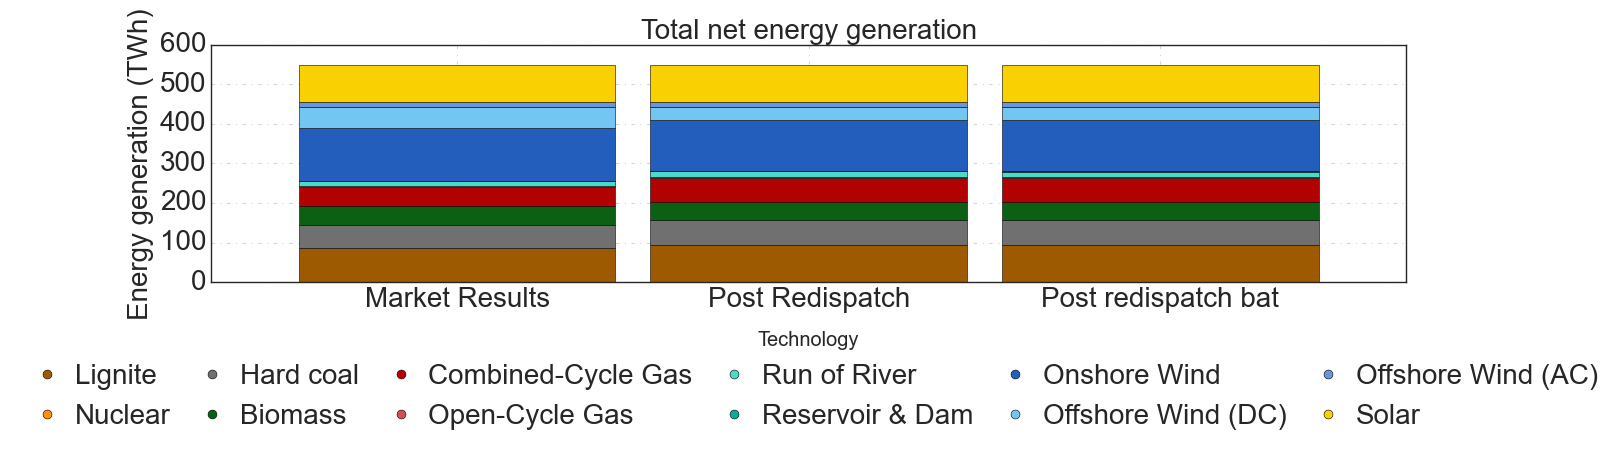

In [130]:
# Energy Mix

fig = energymix_analysis_future(n_d, n_rd, n_rd_lcos_all, size=25, opts=opts, figsize = (20,6))

###################### EXPORT
savename = "Energy Mix 2030"
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################

In [139]:
# SENSITIVITY ANALYSIS 20% LCOS
###############################

# n_rd_bat_all_20 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\results\redispatch\elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future_bat_all_lcos_20%.nc")

# Analyse cost saving for last quarter of the year:
n_rd_copy = n_rd.copy(snapshots=n_rd.snapshots[6570:])

#sum_rd1, sum_conv1, obj_year1, obj_conv1, df_obj1, df_obj_day1 = analyze_objective_rd(n_rd_copy)
sum_rd2, sum_conv2, obj_year2, obj_conv2, df_obj2, df_obj_day2 = analyze_objective_rd(n_rd_bat_all_20)


Total cost: Objective value
770047608.2320297


PHS




4084520.725851653

offwind


6395676.189787189

6543158.843987446

onwind


1700852.4354946176

3937081.8693279093

solar


-9683.070817801721

9683.070817801721

ror


-121.35161828732376

121.35161828732376

coal


729559.9406191581

3536218.414138718

lignite


3026967.8456909717

nuclear


0.0

Gas


4806575.125092668

Biomass


532051.5312333751

Redispatch energy conventional + renewable


20017707.68307314

Redispatch energy convetional


11901812.916155731

436116306.67332196

cost renew curtailment
Redispatch cost only convetional
466981493.6215304


No bat               7.876223e+08
bat all              7.487852e+08
bat all lcos         7.774209e+08
bat all lcos -20%    7.700476e+08
Name: Total RD cost, dtype: float64
No bat               2.056305e+07
bat all              1.986631e+07
bat all lcos         2.011987e+07
bat all lcos -20%    2.001771e+07
Name: Total redispatch energy, dtype: float64
No bat               4.839047e+08
bat all              4.549890e+08
bat all lcos         4.691768e+08
bat all lcos -20%    4.669815e+08
Name: Total RD cost, dtype: float64
No bat               1.219734e+07
bat all              1.180320e+07
bat all lcos         1.194587e+07
bat all lcos -20%    1.190181e+07
Name: Total redispatch energy, dtype: float64


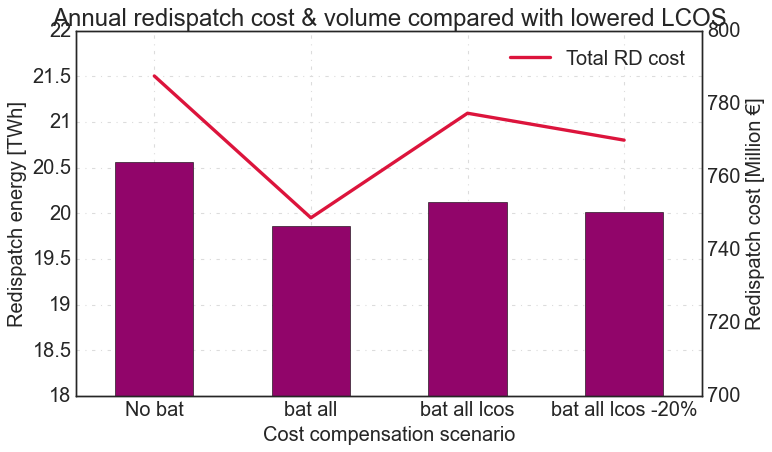

In [20]:
# import last quarter networks for sensitivity analysis
# import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"
# filename = r"elec_s300_220_ec_lcopt_1H-Ep-noex_2030_future"
# n_rd_025 = pypsa.Network(import_path + r"\redispatch\\" + filename + "_6570.nc")
# n_rd_all_025 = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_all_6570.nc")
# n_rd_all_lcos025 = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_all_lcos_6570.nc") 
# n_rd_all_lcos_20percent = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat_all_lcos_20%.nc")

# sum_rd1, sum_conv1, obj_year1, obj_conv1, df_obj1, df_obj_day1 = analyze_objective_rd(n_rd_025)
# print("\n//////\n\n")
# sum_rd2, sum_conv2, obj_year2, obj_conv2, df_obj2, df_obj_day2 = analyze_objective_rd(n_rd_all_025)
# print("\n//////\n\n")
# sum_rd3, sum_conv3, obj_year3, obj_conv3, df_obj3, df_obj_day3 = analyze_objective_rd(n_rd_all_lcos025)
# print("\n//////\n\n")
# sum_rd4, sum_conv4, obj_year4, obj_conv4, df_obj4, df_obj_day4 = analyze_objective_rd(n_rd_all_lcos_20percent)


list_obj_values_lcos = \
[obj_year1,
obj_year2,
obj_year3,
obj_year4]

list_rd_sums_lcos = \
[sum_rd1,
sum_rd2,
sum_rd3,
sum_rd4]

list_conv_values_lcos = \
[obj_conv1,
obj_conv2,
obj_conv3,
obj_conv4]

list_conv_sums_lcos = \
[sum_conv1,
sum_conv2,
sum_conv3,
sum_conv4]


# Redispatch cost "elbow curve"
s_obj_values_lcos = pd.Series(list_obj_values_lcos, name = "Total RD cost", index= \
["No bat",
 "bat no cost",
 "bat all lcos",
 "bat all lcos -20%"])

# Redispatch energy "elbow curve"
s_sum_rd_lcos = pd.Series(list_rd_sums_lcos, name = "Total redispatch energy", index= \
["No bat",
 "bat all",
 "bat all lcos",
 "bat all lcos -20%"])

# Redispatch cost "elbow curve"
s_conv_values_lcos = pd.Series(list_conv_values_lcos, name = "Total RD cost", index= \
["No bat",
 "bat all",
 "bat all lcos",
 "bat all lcos -20%"])

# Redispatch energy "elbow curve"
s_sum_conv_lcos = pd.Series(list_conv_sums_lcos, name = "Total redispatch energy", index= \
["No bat",
 "bat all",
 "bat all lcos",
 "bat all lcos -20%"])

# Colors from power point
colors = \
["#7F7F7F", # grey
 "#1F407A", # eth blue
 "#A8322D", # eth red
 "#91056A"] #eth purple  

print(s_obj_values_lcos)
print(s_sum_rd_lcos)
print(s_conv_values_lcos)
print(s_sum_conv_lcos)


# Plot all redispatch ELBOW CURVE with energy and costs
# Relative redispatch cost savings vs absolute savings
#########################################################
fig, ax  = plt.subplots(figsize = (10, 6))
size = 18
# scale y-axis to Million €
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

ax.set_ylabel('Redispatch energy [TWh]',  fontsize = size)
ax.set_xlabel("Cost compensation scenario", fontsize = size)
ax = s_sum_rd_lcos.plot.bar(stacked = False, ax = ax, title = "Annual redispatch cost & volume compared with lowered LCOS", 
                                  color = "#91056A", legend = False, fontsize = size, width = 0.5)

ax.set_facecolor('white')
#ax.legend(loc = "upper left", fontsize = size)
ax.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax.set_axisbelow(True)
ax.set_ylim((18000000,22000000))

ax.set_xticklabels(s_obj_values_lcos.index, rotation=0, ha='center')
ax_ = ax.twinx()
s_obj_values_lcos.plot.line(ax = ax_, linewidth = 3, color = "crimson", legend = True, fontsize = size)
# Scale y-axis to Million MWh (TWh)
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax_.yaxis.set_major_formatter(ticks_y)
ax_.set_ylabel('Redispatch cost [Million €]',  fontsize = size)
ax_.legend(loc = "upper right", fontsize = size)
ax_.set_ylim((700000000,800000000))
fig.tight_layout()
plt.show()

###################### EXPORT
savename = "Cost reduction sensitivity analysis -20% lcos"
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################


In [19]:
# Comparison: Share of saving potential achieved
# ----------------------------------------------

df_potential_share = pd.concat((s_obj_values_lcos,s_sum_rd_lcos),axis=1)
df_potential_share.columns = ["RD cost reduction","Total RD energy"]
df_potential_share.iloc[1:,:] = df_potential_share.iloc[1:,:] - df_potential_share.iloc[0,:]

# determine what share of potential could be achieved

df_potential_share["% reduction potential"] = df_potential_share["RD cost reduction"]/df_potential_share["RD cost reduction"].iloc[0] * 100
df_potential_share["% energy reduction"] = df_potential_share["Total RD energy"]/df_potential_share["Total RD energy"].iloc[0] * 100

# # share of theoretical potential that could be achieved
df_potential_share["Share of potential achieved"] = df_potential_share["RD cost reduction"]/df_potential_share["RD cost reduction"].iloc[1] * 100
df_potential_share["Share of energy potential achieved"] = df_potential_share["Total RD energy"]/df_potential_share["Total RD energy"].iloc[1] * 100

display(df_potential_share)






RD cost reduction  Total RD energy  % reduction potential  \
No bat                  7.876223e+08     2.056305e+07             100.000000   
bat all                -3.883708e+07    -6.967438e+05              -4.930927   
bat all lcos           -1.020137e+07    -4.431817e+05              -1.295211   
bat all lcos -20%      -1.757470e+07    -5.453419e+05              -2.231361   

                   % energy reduction  Share of potential achieved  \
No bat                     100.000000                 -2028.016415   
bat all                     -3.388329                   100.000000   
bat all lcos                -2.155233                    26.267093   
bat all lcos -20%           -2.652048                    45.252375   

                   Share of energy potential achieved  
No bat                                   -2951.306988  
bat all                                    100.000000  
bat all lcos                                63.607557  
bat all lcos -20%                           78.270078

Index(['CCGT', 'OCGT', 'biomass', 'coal', 'hydro+PHS', 'lignite', 'offwind-ac',
       'offwind-dc', 'onwind', 'ror', 'solar'],
      dtype='object')

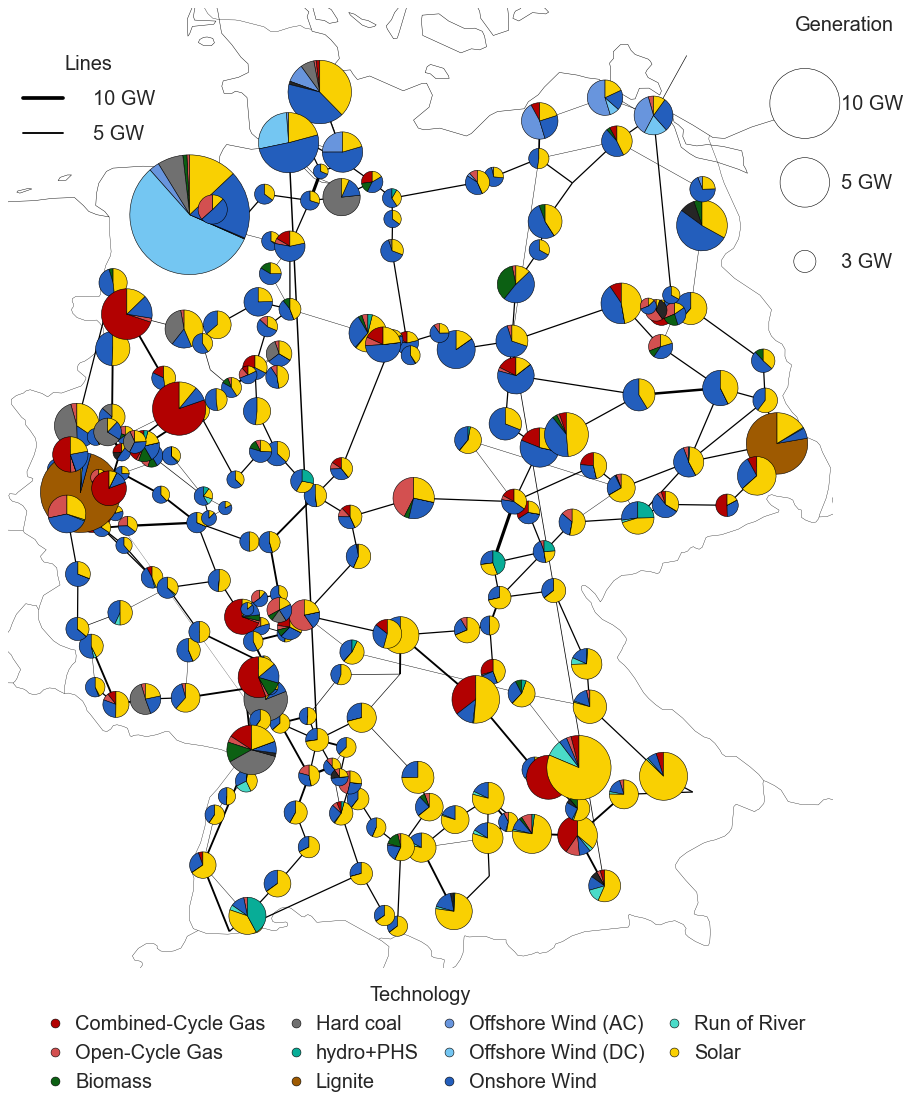

In [26]:
# Plot regionalization. Find nuclear powerplant in northwest
# Plot generation analysis
ncap = load_network_for_plots(n_rd, snakemake.config)
#220 nodes
fig, ax = plt.subplots(figsize=(15,15), subplot_kw={"projection": ccrs.Mollweide()})
plot_map(ncap, ax, snakemake.wildcards.attr, opts, bussize=16e+4)
# Plot energy map
#ax1 = fig.add_axes([-0.19, 0.625, 0.22, 0.22])

#plot_total_energy_pie(ncap, ax1)


###################### EXPORT
savename = "Installed power plant capacity 2030"
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################

bus       e_nom   e_initial      p_set  \
name                                                                           
BESS_0                         DE0 0_BESS  361.221877  180.610938  90.305469   
BESS_1                         DE0 1_BESS  128.293492   64.146746  32.073373   
BESS_2                        DE0 10_BESS  317.679160  158.839580  79.419790   
BESS_3                       DE0 100_BESS   89.515993   44.757996  22.378998   
BESS_4                       DE0 101_BESS   59.079006   29.539503  14.769751   
...                                   ...         ...         ...        ...   
generator_BESS_215  DE0 95_generator_BESS   19.055638    9.527819   4.763910   
generator_BESS_216  DE0 96_generator_BESS   41.046757   20.523378  10.261689   
generator_BESS_217  DE0 97_generator_BESS   21.250425   10.625212   5.312606   
generator_BESS_218  DE0 98_generator_BESS   24.733118   12.366559   6.183279   
generator_BESS_219  DE0 99_generator_BESS   61.493579   30.746789  15.373395   

                    q_set   e_nom_opt type  e_nom_extendable  e_nom_min  \
name                                                                      
BESS_0               0.05  361.221877                  False        0.0   
BESS_1               0.05  128.293492                  False        0.0   
BESS_2               0.05  317.679160                  False        0.0   
BESS_3               0.05   89.515993                  False        0.0   
BESS_4               0.05   59.079006                  False        0.0   
...                   ...         ...  ...               ...        ...   
generator_BESS_215   0.05   19.055638                  False        0.0   
generator_BESS_216   0.05   41.046757                  False        0.0   
generator_BESS_217   0.05   21.250425                  False        0.0   
generator_BESS_218   0.05   24.733118                  False        0.0   
generator_BESS_219   0.05   61.493579                  False        0.0   

                    e_nom_max  e_min_pu  e_max_pu  e_cyclic  sign  \
name                                                                
BESS_0                    inf       0.0       1.0     False   1.0   
BESS_1                    inf       0.0       1.0     False   1.0   
BESS_2                    inf       0.0       1.0     False   1.0   
BESS_3                    inf       0.0       1.0     False   1.0   
BESS_4                    inf       0.0       1.0     False   1.0   
...                       ...       ...       ...       ...   ...   
generator_BESS_215        inf       0.0       1.0     False   1.0   
generator_BESS_216        inf       0.0       1.0     False   1.0   
generator_BESS_217        inf       0.0       1.0     False   1.0   
generator_BESS_218        inf       0.0       1.0     False   1.0   
generator_BESS_219        inf       0.0       1.0     False   1.0   

                    marginal_cost  capital_cost  standing_loss  
name                                                            
BESS_0                        0.0           0.0            0.0  
BESS_1                        0.0           0.0            0.0  
BESS_2                        0.0           0.0            0.0  
BESS_3                        0.0           0.0            0.0  
BESS_4                        0.0           0.0            0.0  
...                           ...           ...            ...  
generator_BESS_215            0.0           0.0            0.0  
generator_BESS_216            0.0           0.0            0.0  
generator_BESS_217            0.0           0.0            0.0  
generator_BESS_218            0.0           0.0            0.0  
generator_BESS_219            0.0           0.0            0.0  

[431 rows x 17 columns]

name
BESS_117                0.000000
BESS_187                0.000000
BESS_99                 0.000000
BESS_152                0.000000
BESS_150                0.000000
                         ...    
BESS_16               514.664628
generator_BESS_160    614.277848
BESS_160              623.788451
BESS_169              682.129661
BESS_151              742.731186
Name: e_nom, Length: 431, dtype: float64

bus
DE0 36_BESS                 0.000000
DE0 203_BESS                0.000000
DE0 204_BESS                0.000000
DE0 152_BESS                0.000000
DE0 188_BESS                0.000000
                             ...    
DE0 90_BESS               193.430717
DE0 119_BESS              216.272735
DE0 119_generator_BESS    218.800471
DE0 45_generator_BESS     233.783119
DE0 45_BESS               234.245361
Length: 431, dtype: float64

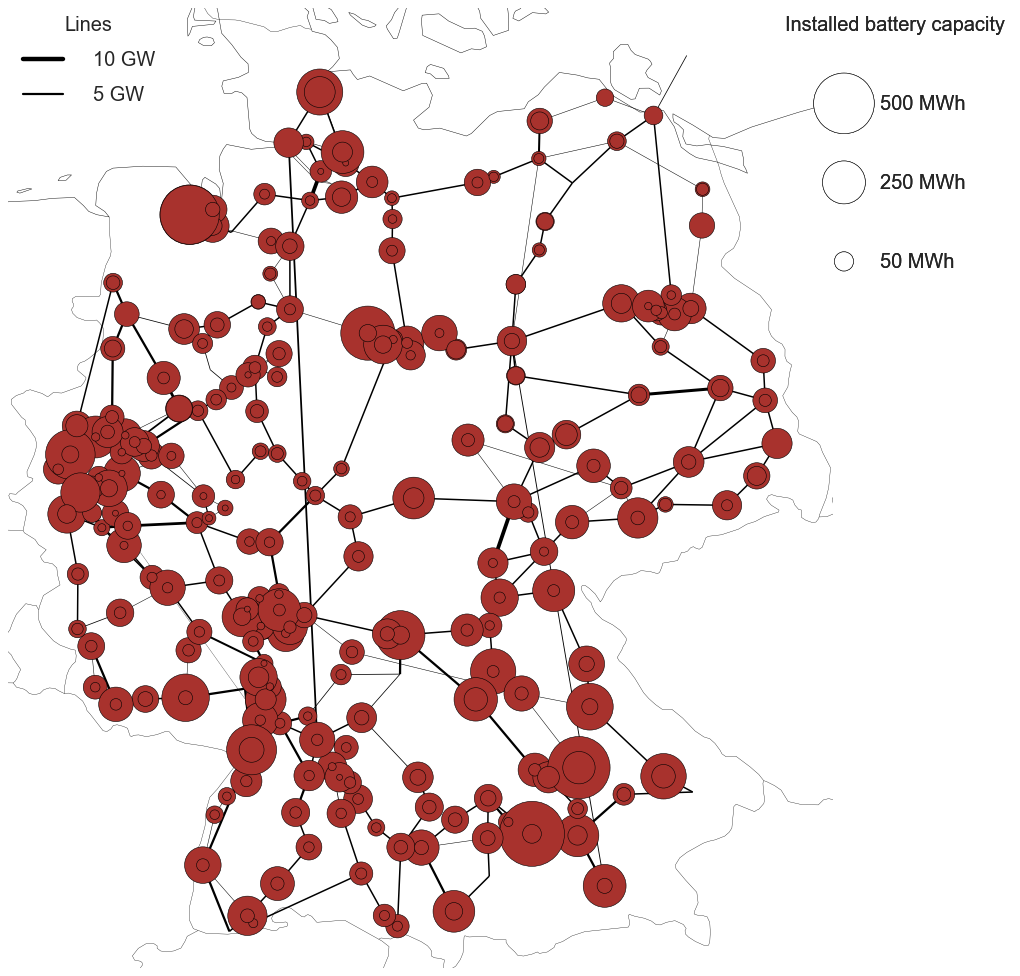

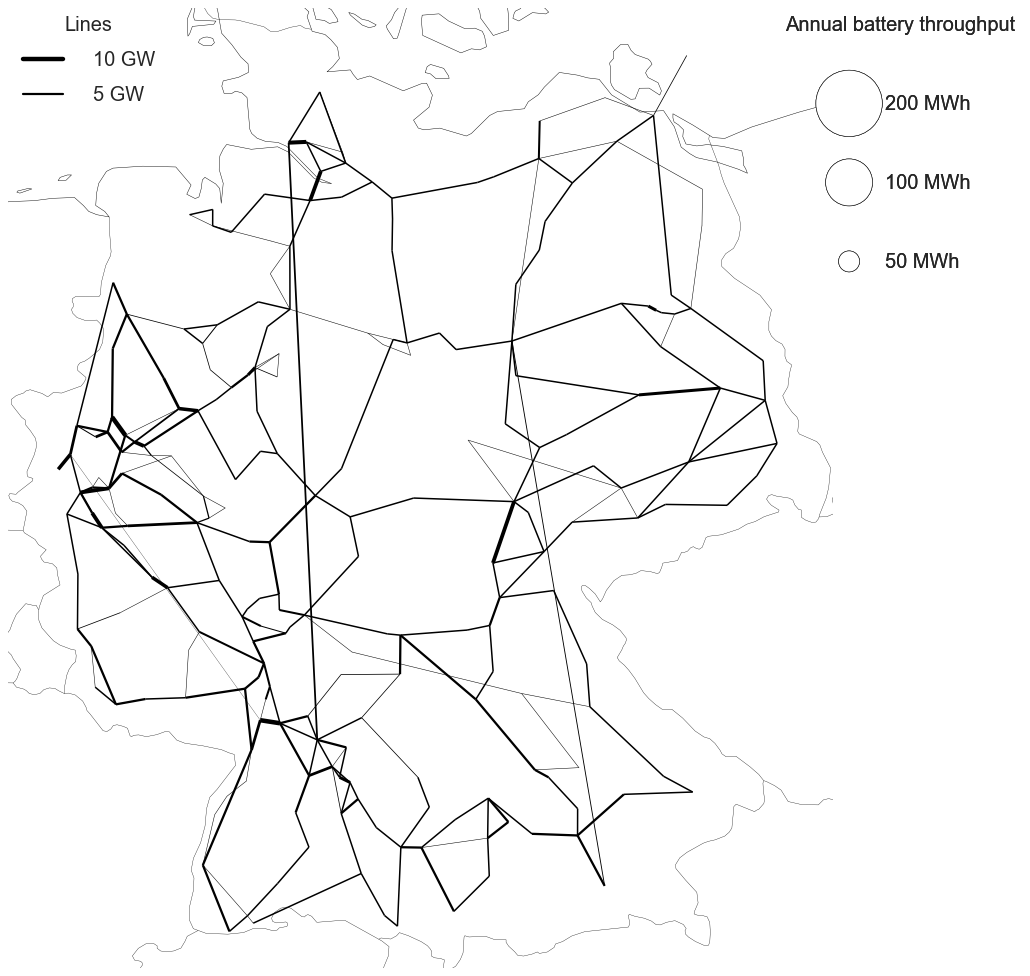

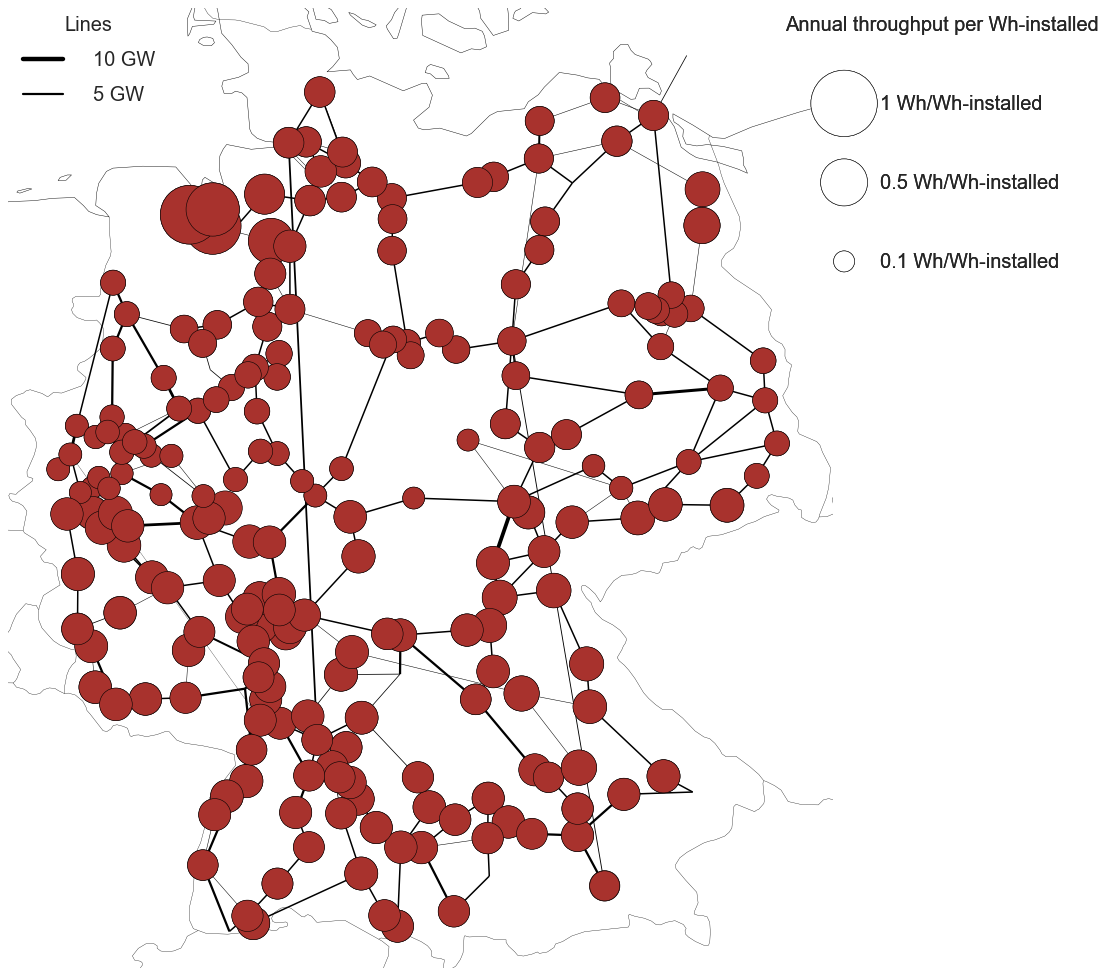

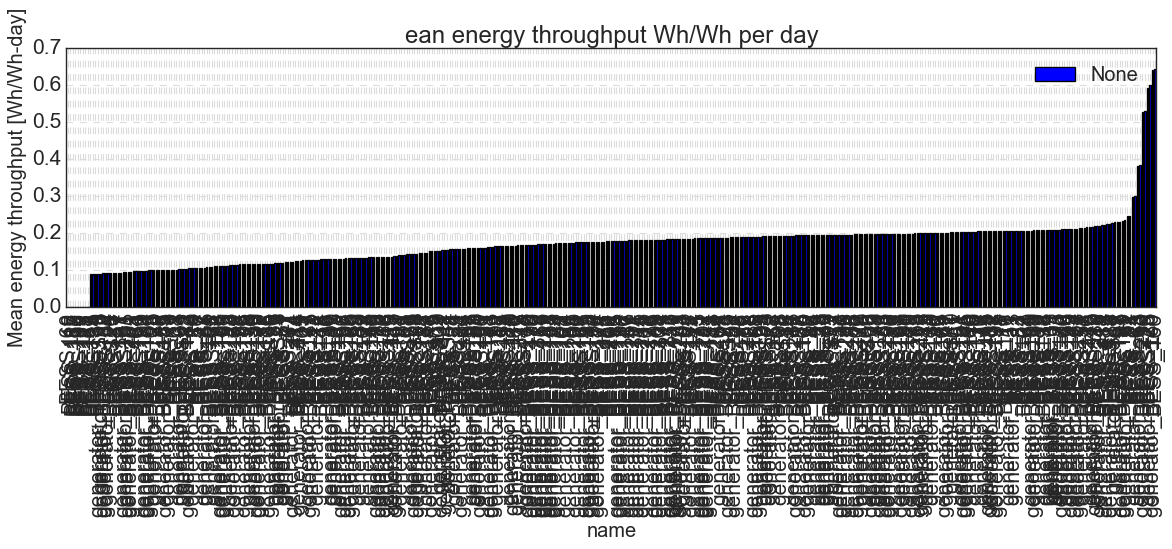

In [58]:
analyze_batteries(n_rd_lcos_all, size=18, bussize=7)

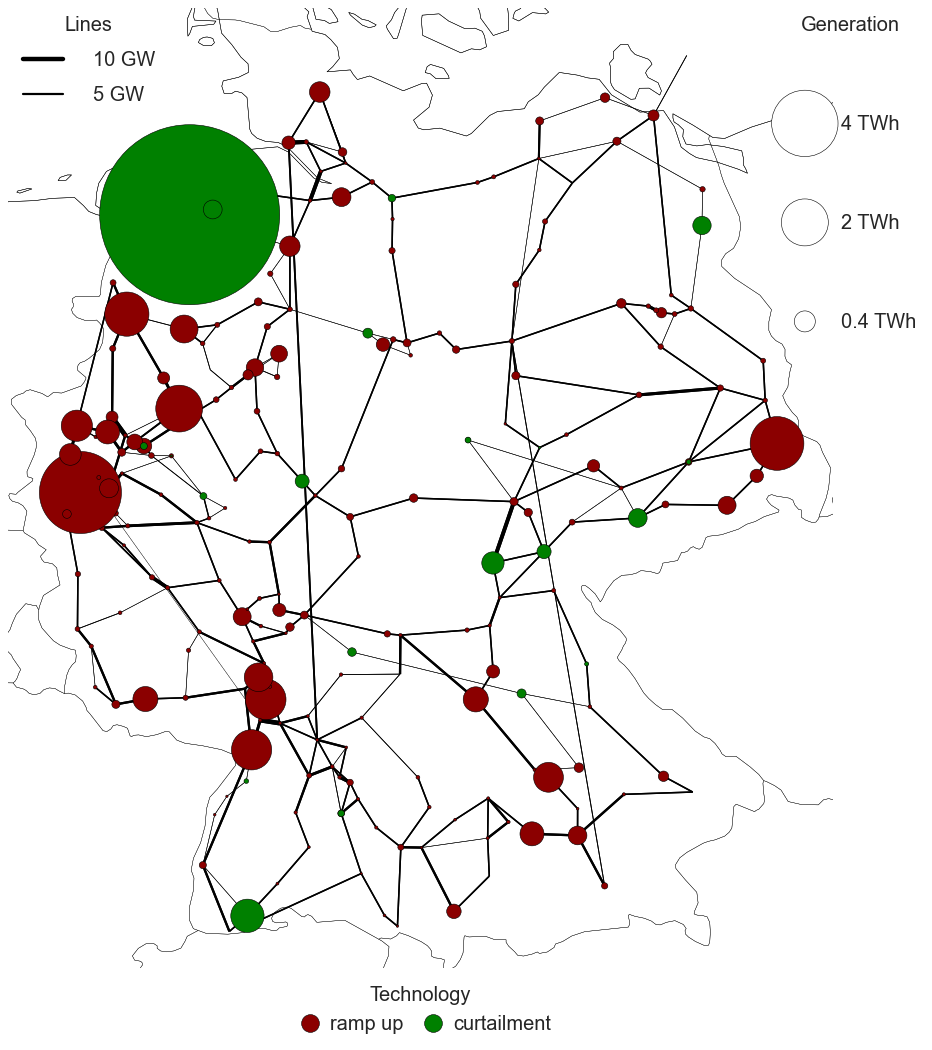

In [73]:
fig, ax = plt.subplots(figsize=(15,15), subplot_kw={"projection": ccrs.Mollweide()})
fig = plot_redispatch_energy_future(n_rd_lcos_all, ax=ax, carrier = "sum", attribute='ramp up', opts=opts, bussize=40)

###################### EXPORT
savename = "Spatial redispatch energy 2030"
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".pdf", bbox_inches='tight')
fig.savefig(r"C:\Users\Willem\Desktop\RWTH\Master\Semester 5\Masterarbeit\Figures\\" + savename + ".svg", bbox_inches='tight')
######################

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


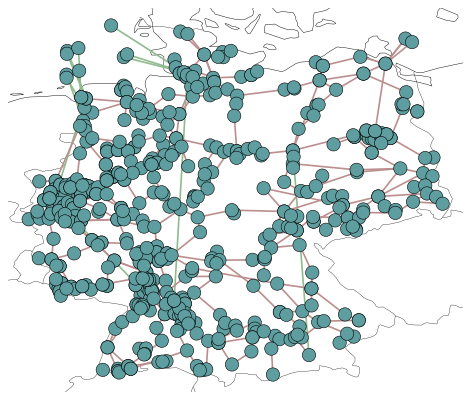

v_nom      symbol  under_construction  \
name                                          
7932  380.0       joint               False   
2332  220.0  Substation               False   
3287  380.0  Substation               False   
3286  220.0  Substation               False   
3288  380.0  Substation               False   
...     ...         ...                 ...   
8591  220.0       joint               False   
8130  220.0       joint               False   
7961  380.0       joint               False   
7960  220.0       joint               False   
8205  220.0       joint               False   

                                                   tags          x          y  \
name                                                                            
7932                                                     11.635895  51.994183   
2332  "oid"=>"49716", "country"=>"DE", "visible"=>"1...  13.509064  52.470233   
3287  "TSO"=>"", "oid"=>"30390", "country"=>"DE", "v...  11.362610  48.852065   
3286  "TSO"=>"", "oid"=>"30390", "country"=>"DE", "v...  11.362610  48.852065   
3288  "TSO"=>"", "oid"=>"30386", "country"=>"DE", "v...  11.501312  48.793295   
...                                                 ...        ...        ...   
8591                                                      8.644867  51.974730   
8130                                                      9.504547  49.783038   
7961                                                      7.175446  49.399356   
7960                                                      7.175446  49.399356   
8205                                                      8.329010  53.235633   

     carrier country  substation_lv  substation_off type  v_mag_pu_set  \
name                                                                     
7932      AC      DE          False           False                1.0   
2332      AC      DE           True            True                1.0   
3287      AC      DE          False            True                1.0   
3286      AC      DE           True           False                1.0   
3288      AC      DE           True            True                1.0   
...      ...     ...            ...             ...  ...           ...   
8591      AC      DE          False           False                1.0   
8130      AC      DE          False           False                1.0   
7961      AC      DE          False           False                1.0   
7960      AC      DE          False           False                1.0   
8205      AC      DE          False           False                1.0   

      v_mag_pu_min  v_mag_pu_max control sub_network  
name                                                  
7932           0.0           inf      PQ              
2332           0.0           inf      PQ              
3287           0.0           inf      PQ              
3286           0.0           inf      PQ              
3288           0.0           inf      PQ              
...            ...           ...     ...         ...  
8591           0.0           inf      PQ              
8130           0.0           inf      PQ              
7961           0.0           inf      PQ              
7960           0.0           inf      PQ              
8205           0.0           inf      PQ              

[571 rows x 16 columns]

bus0  bus1  v_nom  num_parallel     length  underground  \
name                                                             
2378   3286  3289    220           2.0  35.052829        False   
9811   3289  3296    220           2.0  35.379539        False   
10210  3481  3487    220           2.0  45.585606        False   
10211  3487  3488    220           2.0  19.260821        False   
10212  3488  3489    220           2.0  20.954073        False   
...     ...   ...    ...           ...        ...          ...   
4763   8346  8627    380           2.0  47.866694        False   
4760   4489  8627    380           2.0  27.333863        False   
4733   4826  8664    380           2.0   9.128680        False   
4732   4825  8664    380           2.0   6.487753        False   
11073  4823  8664    380           2.0  15.382671        False   

       under_construction                                               tags  \
name                                                                           
2378                False  "MW"=>"None", "TSO"=>"None", "oid"=>"28620", "...   
9811                False                                                      
10210               False                                                      
10211               False                                                      
10212               False                                                      
...                   ...                                                ...   
4763                False  "MW"=>"None", "TSO"=>"None", "oid"=>"31487", "...   
4760                False  "MW"=>"None", "TSO"=>"None", "oid"=>"31484", "...   
4733                False  "MW"=>"None", "TSO"=>"None", "oid"=>"31453", "...   
4732                False  "MW"=>"None", "TSO"=>"None", "oid"=>"31452", "...   
11073               False                                                      

                                                geometry  \
name                                                       
2378   LINESTRING(11.3630567551294 48.8520810508037,1...   
9811   LINESTRING(12.1725434997148 48.6385688104618,1...   
10210  LINESTRING(7.71252141367215 48.1040507369027,7...   
10211  LINESTRING(7.87744612346249 48.4995656124645,8...   
10212  LINESTRING(8.02311166759092 48.6439852561152,8...   
...                                                  ...   
4763   LINESTRING(13.808441 50.952371,13.127289 50.95...   
4760   LINESTRING(13.127289 50.959292,13.003693 50.96...   
4733   LINESTRING(8.97812831748755 49.9803741021194,8...   
4732   LINESTRING(8.80029963331241 49.9328998132513,8...   
11073  LINESTRING(8.850861 49.981254,8.97145836239861...   

                              type  s_max_pu        s_nom  capital_cost    x  \
name                                                                           
2378   Al/St 240/40 2-bundle 220.0       0.7   983.112038   1332.135646  0.0   
9811   Al/St 240/40 2-bundle 220.0       0.7   983.112038   1344.551796  0.0   
10210  Al/St 240/40 2-bundle 220.0       0.7   983.112038   1732.419687  0.0   
10211  Al/St 240/40 2-bundle 220.0       0.7   983.112038    731.981610  0.0   
10212  Al/St 240/40 2-bundle 220.0       0.7   983.112038    796.331383  0.0   
...                            ...       ...          ...           ...  ...   
4763   Al/St 240/40 4-bundle 380.0       0.7  3396.205223   1819.109353  0.0   
4760   Al/St 240/40 4-bundle 380.0       0.7  3396.205223   1038.786726  0.0   
4733   Al/St 240/40 4-bundle 380.0       0.7  3396.205223    346.923228  0.0   
4732   Al/St 240/40 4-bundle 380.0       0.7  3396.205223    246.558325  0.0   
11073  Al/St 240/40 4-bundle 380.0       0.7  3396.205223    584.597728  0.0   

         r    g    b  s_nom_extendable  s_nom_min  s_nom_max  terrain_factor  \
name                                                                           
2378   0.0  0.0  0.0             False        0.0        inf             1.0   
9811   0.0  0.0  0.0             False       

carrier
CCGT           65
OCGT          112
biomass        41
coal           63
lignite        30
nuclear        11
offwind-ac     17
offwind-dc      7
oil            29
onwind        310
ror           678
solar         313
dtype: int64

carrier
PHS      23
hydro     3
dtype: int64

In [3]:
# full resolution network
#n_300 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s_300_ec_lcopt_1H-Ep-noex.nc")
# n_base = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\base.nc")
n_elec = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec.nc")
# n_elec_s = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s.nc")


n_elec.plot()
plt.show()


display(n_elec.buses)
display(n_elec.lines)
display(n_elec.generators.groupby("carrier").size())
display(n_elec.storage_units.groupby("carrier").size())